# Training

### Unified Reasoning Module

In [1]:
import os
import json
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from task import Task
from unified_module import UnifiedReasoningModule
import random
import torch.multiprocessing as mp
import traceback
from trainer import train_model, load_precomputed_tasks

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
MODEL_DIR = "output/models/unified_shape"
DATA_DIR = "precomputed_tasks/training"
METRICS_DIR = "output/metrics"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

# Main function
def main():
    # Load tasks
    print("Loading tasks...")
    tasks = load_precomputed_tasks(DATA_DIR)
    print(f"Loaded {len(tasks)} tasks")
    
    try:
        # Initialize model
        print("Initializing unified model...")
        model = UnifiedReasoningModule(
            input_dim=3,
            hidden_dim=128,
            output_dim=11,
            device=device
        )
        model.model = model.model.to(device)
        
        # Train model with task-aware approach
        print("Starting unified model training...")
        trained_model, history = train_model(
            model=model,
            tasks=tasks,
            num_epochs=1000,
            learning_rate=0.0005,
            weight_decay=1e-5,
            save_dir=MODEL_DIR,
            model_name="unified_shape",
            batch_size=8,
            device=device
        )
        
        print("Training complete!")
        return trained_model, history
        
    except Exception as e:
        print(f"Error in main function: {e}")
        traceback.print_exc()
        return None, None

# Run the main function when executed
if __name__ == "__main__":
    mp.set_start_method('spawn', force=True)
    model, history = main()

ImportError: dlopen(/Users/admin/anaconda3/envs/arclab/lib/python3.12/site-packages/torch/_C.cpython-312-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib
  Referenced from: <5BC09ACF-F7D0-31EF-B863-0779C73CDBF4> /Users/admin/anaconda3/envs/arclab/lib/libtorch_cpu.dylib
  Reason: tried: '/Users/admin/anaconda3/envs/arclab/lib/liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/lib/liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/lib/liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/lib/liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/lib/liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/lib/liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/lib/python3.12/site-packages/torch/lib/liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/lib/python3.12/site-packages/torch/../../../liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/lib/python3.12/site-packages/torch/lib/liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/lib/python3.12/site-packages/torch/../../../liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/bin/../lib/liblapack.3.dylib' (no such file), '/Users/admin/anaconda3/envs/arclab/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)

In [3]:
import os
import json
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from task4 import Task
from unified_module import UnifiedReasoningModule
import random
import traceback
from meta_learning import run_meta_learning, MAMLTrainer, ProtoNetTrainer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
pretrained_model_path = "output/models/unified_reasoning_model_final.pt"
MODEL_DIR = "output/models/unified"
TRAIN_DIR = "data/training"
VAL_DIR = "data/evaluation"
METRICS_DIR = "output/metrics/unified_meta"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

# Load tasks
def load_tasks(directory):
    """Load tasks from directory"""
    tasks = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    data = json.load(f)
                    if "train" not in data or "test" not in data:
                        print(f"Warning: Invalid task format in {file_path}")
                        continue
                    
                    task = Task(
                        task_id=os.path.basename(file_path),
                        train_pairs=[(pair["input"], pair["output"]) for pair in data["train"]],
                        test_pairs=[(pair["input"], pair["output"]) for pair in data["test"]],
                    )
                    tasks.append(task)
    return tasks

# Split tasks into training and validation sets
def split_tasks(tasks, val_ratio=0.2):
    """Split tasks into training and validation sets"""
    random.shuffle(tasks)
    val_size = int(len(tasks) * val_ratio)
    train_tasks = tasks[val_size:]
    val_tasks = tasks[:val_size]
    return train_tasks, val_tasks

# Train meta-learning models
def train_meta_learning(model, train_tasks, val_tasks, method="both"):
    """
    Train meta-learning models.
    
    Args:
        model: UnifiedReasoningModule instance
        train_tasks: List of training tasks
        val_tasks: List of validation tasks
        method: Which method to use ("maml", "proto", or "both")
        
    Returns:
        Dictionary of trained models
    """
    trained_models = {}
    
    if method.lower() == "maml" or method.lower() == "both":
        print("Training MAML model...")
        maml_trainer = run_meta_learning(
            unified_model=model,
            train_tasks=train_tasks,
            val_tasks=val_tasks,
            method="maml",
            epochs=50,
            lr=0.001,
            weight_decay=1e-5,
            log_dir=os.path.join(MODEL_DIR, "maml")
        )
        trained_models["maml"] = maml_trainer
    
    if method.lower() == "proto" or method.lower() == "both":
        print("Training Prototypical Networks model...")
        proto_trainer = run_meta_learning(
            unified_model=model,
            train_tasks=train_tasks,
            val_tasks=val_tasks,
            method="proto",
            epochs=50,
            lr=0.001,
            weight_decay=1e-5,
            log_dir=os.path.join(MODEL_DIR, "proto")
        )
        trained_models["proto"] = proto_trainer
    
    return trained_models

# Test on new tasks
def test_meta_learning(trainer, test_tasks):
    """
    Test meta-learning models on new tasks.
    
    Args:
        trainer: Meta-learning trainer instance
        test_tasks: List of test tasks
        
    Returns:
        Dictionary of test metrics
    """
    print(f"Testing {trainer.__class__.__name__} on {len(test_tasks)} tasks...")
    
    task_metrics = []
    avg_accuracy = 0.0
    
    for i, task in enumerate(test_tasks):
        try:
            # Prepare support and query sets
            support_graphs = task.train_graphs
            query_graphs = task.test_graphs
            
            if not support_graphs or not query_graphs:
                print(f"Skipping task {i} due to empty graphs")
                continue
                
            # Create batches
            support_batch = torch.geometric.data.Batch.from_data_list(support_graphs).to(device)
            query_batch = torch.geometric.data.Batch.from_data_list(query_graphs).to(device)
            
            # Evaluate with few-shot adaptation
            accuracy = trainer.validate_task(support_batch, query_batch)
            
            print(f"Task {i} accuracy: {accuracy:.4f}")
            task_metrics.append({
                "task_id": task.task_id,
                "accuracy": accuracy,
                "num_train": len(support_graphs),
                "num_test": len(query_graphs)
            })
            
            avg_accuracy += accuracy
            
        except Exception as e:
            print(f"Error testing task {i}: {e}")
            traceback.print_exc()
    
    avg_accuracy /= len(task_metrics) if task_metrics else 1.0
    print(f"Average test accuracy: {avg_accuracy:.4f}")
    
    # Save metrics
    method_name = trainer.__class__.__name__.replace("Trainer", "").lower()
    metrics_path = os.path.join(METRICS_DIR, f"{method_name}_test_metrics.json")
    with open(metrics_path, "w") as f:
        json.dump({
            "avg_accuracy": avg_accuracy,
            "task_metrics": task_metrics
        }, f, indent=2)
    
    return {
        "avg_accuracy": avg_accuracy,
        "task_metrics": task_metrics
    }

# Main function
def main():
    # Load tasks
    print("Loading tasks...")
    train_tasks = load_tasks(TRAIN_DIR)
    val_tasks = load_tasks(VAL_DIR)
    print(f"Loaded {len(train_tasks)+len(val_tasks)} tasks")
    
    # Split into train, validation, and test sets
    val_tasks, test_tasks = split_tasks(val_tasks, val_ratio=0.5)
    print(f"Split into {len(train_tasks)} training, {len(val_tasks)} validation, and {len(test_tasks)} test tasks")
    
    try:
        # Initialize model
        print("Initializing unified model...")
        model = UnifiedReasoningModule(
            input_dim=3,
            hidden_dim=128,
            output_dim=11,
            device=device
        )
        model.load_complete_state(pretrained_model_path)
        model.model = model.model.to(device)
        
        # Train meta-learning models
        print("Training meta-learning models...")
        trained_models = train_meta_learning(
            model=model,
            train_tasks=train_tasks,
            val_tasks=val_tasks,
            method="both"  # Train both MAML and Prototypical Networks
        )
        
        # Test meta-learning models
        print("Testing meta-learning models...")
        test_results = {}
        for method, trainer in trained_models.items():
            test_results[method] = test_meta_learning(trainer, test_tasks)
        
        # Compare results
        print("\nComparison of meta-learning methods:")
        for method, results in test_results.items():
            print(f"{method.upper()}: Average accuracy = {results['avg_accuracy']:.4f}")
        
        print("Meta-learning training and evaluation complete!")
        return trained_models, test_results
        
    except Exception as e:
        print(f"Error in main function: {e}")
        traceback.print_exc()
        return None, None

# Run the main function when executed
if __name__ == "__main__":
    models, results = main()

Using device: cuda
Loading tasks...
Loaded 800 tasks
Split into 400 training, 200 validation, and 200 test tasks
Initializing unified model...
Error: State file not found at output/models/unified_reasoning_model_final.pt
Training meta-learning models...
Training MAML model...
Error in main function: CUDA out of memory. Tried to allocate 4.20 GiB. GPU 0 has a total capacity of 94.50 GiB of which 2.42 GiB is free. Including non-PyTorch memory, this process has 92.07 GiB memory in use. Of the allocated memory 88.54 GiB is allocated by PyTorch, and 2.78 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


Traceback (most recent call last):
  File "/tmp/ipykernel_35322/4034748047.py", line 199, in main
    trained_models = train_meta_learning(
  File "/tmp/ipykernel_35322/4034748047.py", line 80, in train_meta_learning
    maml_trainer = run_meta_learning(
  File "/home/ubuntu/thesis-files/meta_learning.py", line 861, in run_meta_learning
    metrics = trainer.train(
  File "/home/ubuntu/thesis-files/meta_learning.py", line 323, in train
    epoch_loss = self.train_epoch(train_tasks, optimizer)
  File "/home/ubuntu/thesis-files/meta_learning.py", line 484, in train_epoch
    adapted_params = self.adapt_params(
  File "/home/ubuntu/thesis-files/meta_learning.py", line 440, in adapt_params
    grads = torch.autograd.grad(
  File "/usr/lib/python3/dist-packages/torch/autograd/__init__.py", line 496, in grad
    result = _engine_run_backward(
  File "/usr/lib/python3/dist-packages/torch/autograd/graph.py", line 823, in _engine_run_backward
    return Variable._execution_engine.run_backward( 

### NLM Reasoning Module

Using device: cuda
Loading tasks...
Loading precomputed tasks from precomputed_tasks/training


Loading tasks from precomputed_tasks/training: 100%|██████████| 2800/2800 [00:16<00:00, 168.55it/s]


Loaded 2800 precomputed tasks
Loaded 2800 tasks
Initializing nlm model...
Starting nlm model training...


Epoch 1/1000: 100%|██████████| 1504/1504 [01:11<00:00, 20.92it/s]


Epoch 1/1000 - Loss: 2.1305 (Node: 2.0305, EdgeTrans: 0.7783, EdgeType: 1.1164, Grid: 0.9998, Shape: 0.3436), Node Acc: 0.5429, Grid Acc: 0.0002, Shape Acc: 0.566606, EdgeTrans Acc: 0.5959, EdgeType Acc: 0.5153


Epoch 2/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.43it/s]


Epoch 2/1000 - Loss: 1.9107 (Node: 1.8107, EdgeTrans: 0.6610, EdgeType: 0.9206, Grid: 1.0000, Shape: 0.2974), Node Acc: 0.5674, Grid Acc: 0.0000, Shape Acc: 0.637203, EdgeTrans Acc: 0.6536, EdgeType Acc: 0.6131


Epoch 3/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.33it/s]


Epoch 3/1000 - Loss: 1.8201 (Node: 1.7201, EdgeTrans: 0.6151, EdgeType: 0.8608, Grid: 0.9999, Shape: 0.2885), Node Acc: 0.5910, Grid Acc: 0.0001, Shape Acc: 0.642192, EdgeTrans Acc: 0.6677, EdgeType Acc: 0.6441


Epoch 4/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.52it/s]


Epoch 4/1000 - Loss: 1.7518 (Node: 1.6518, EdgeTrans: 0.5861, EdgeType: 0.8382, Grid: 1.0000, Shape: 0.2857), Node Acc: 0.6028, Grid Acc: 0.0000, Shape Acc: 0.644936, EdgeTrans Acc: 0.6988, EdgeType Acc: 0.6612


Epoch 5/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.37it/s]


Epoch 5/1000 - Loss: 1.7121 (Node: 1.6121, EdgeTrans: 0.5671, EdgeType: 0.8086, Grid: 0.9999, Shape: 0.2792), Node Acc: 0.6106, Grid Acc: 0.0001, Shape Acc: 0.647763, EdgeTrans Acc: 0.7122, EdgeType Acc: 0.6769
Model state saved to output/models/nlm_shape/nlm_shape_epoch_5.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_5.pt


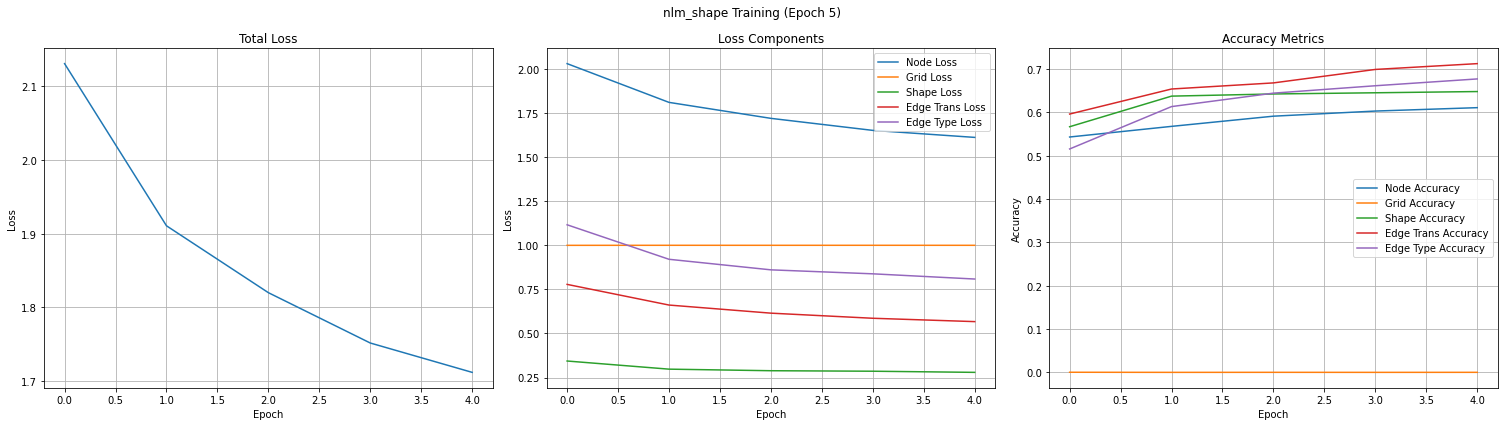

Epoch 6/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.55it/s]


Epoch 6/1000 - Loss: 1.6890 (Node: 1.5890, EdgeTrans: 0.5596, EdgeType: 0.7914, Grid: 1.0000, Shape: 0.2781), Node Acc: 0.6143, Grid Acc: 0.0000, Shape Acc: 0.646100, EdgeTrans Acc: 0.7207, EdgeType Acc: 0.6809


Epoch 7/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.47it/s]


Epoch 7/1000 - Loss: 1.6557 (Node: 1.5557, EdgeTrans: 0.5363, EdgeType: 0.7734, Grid: 0.9999, Shape: 0.2766), Node Acc: 0.6220, Grid Acc: 0.0001, Shape Acc: 0.646848, EdgeTrans Acc: 0.7340, EdgeType Acc: 0.6884


Epoch 8/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.49it/s]


Epoch 8/1000 - Loss: 1.6404 (Node: 1.5404, EdgeTrans: 0.5266, EdgeType: 0.7657, Grid: 0.9999, Shape: 0.2762), Node Acc: 0.6278, Grid Acc: 0.0001, Shape Acc: 0.650175, EdgeTrans Acc: 0.7445, EdgeType Acc: 0.6936


Epoch 9/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.53it/s]


Epoch 9/1000 - Loss: 1.6141 (Node: 1.5141, EdgeTrans: 0.5167, EdgeType: 0.7459, Grid: 1.0000, Shape: 0.2721), Node Acc: 0.6316, Grid Acc: 0.0000, Shape Acc: 0.648512, EdgeTrans Acc: 0.7432, EdgeType Acc: 0.6978


Epoch 10/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.42it/s]


Epoch 10/1000 - Loss: 1.6120 (Node: 1.5120, EdgeTrans: 0.5149, EdgeType: 0.7425, Grid: 0.9999, Shape: 0.2725), Node Acc: 0.6356, Grid Acc: 0.0001, Shape Acc: 0.647514, EdgeTrans Acc: 0.7453, EdgeType Acc: 0.7055
Model state saved to output/models/nlm_shape/nlm_shape_epoch_10.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_10.pt


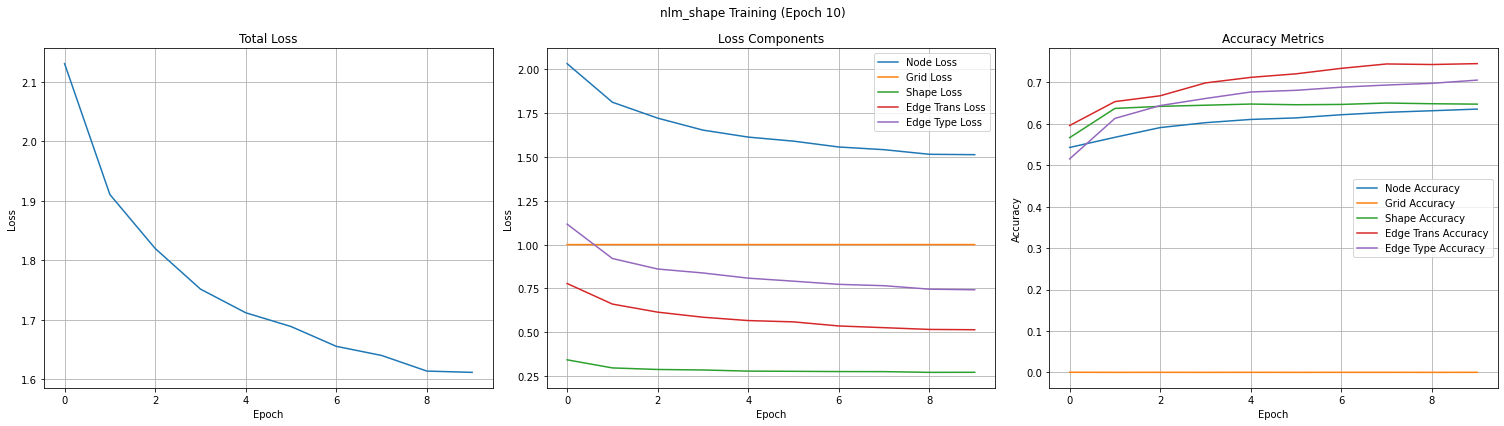

Epoch 11/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.61it/s]


Epoch 11/1000 - Loss: 1.5861 (Node: 1.4862, EdgeTrans: 0.5066, EdgeType: 0.7342, Grid: 0.9998, Shape: 0.2686), Node Acc: 0.6379, Grid Acc: 0.0002, Shape Acc: 0.648927, EdgeTrans Acc: 0.7524, EdgeType Acc: 0.7116


Epoch 12/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.55it/s]


Epoch 12/1000 - Loss: 1.5690 (Node: 1.4690, EdgeTrans: 0.4984, EdgeType: 0.7235, Grid: 1.0000, Shape: 0.2673), Node Acc: 0.6427, Grid Acc: 0.0000, Shape Acc: 0.646266, EdgeTrans Acc: 0.7520, EdgeType Acc: 0.7143


Epoch 13/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.54it/s]


Epoch 13/1000 - Loss: 1.5561 (Node: 1.4561, EdgeTrans: 0.4894, EdgeType: 0.7157, Grid: 0.9998, Shape: 0.2640), Node Acc: 0.6448, Grid Acc: 0.0002, Shape Acc: 0.647846, EdgeTrans Acc: 0.7643, EdgeType Acc: 0.7148


Epoch 14/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.56it/s]


Epoch 14/1000 - Loss: 1.5379 (Node: 1.4379, EdgeTrans: 0.4832, EdgeType: 0.7098, Grid: 1.0000, Shape: 0.2624), Node Acc: 0.6478, Grid Acc: 0.0000, Shape Acc: 0.649759, EdgeTrans Acc: 0.7688, EdgeType Acc: 0.7186


Epoch 15/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.55it/s]


Epoch 15/1000 - Loss: 1.5314 (Node: 1.4314, EdgeTrans: 0.4763, EdgeType: 0.7054, Grid: 0.9999, Shape: 0.2575), Node Acc: 0.6501, Grid Acc: 0.0001, Shape Acc: 0.648096, EdgeTrans Acc: 0.7762, EdgeType Acc: 0.7222
Model state saved to output/models/nlm_shape/nlm_shape_epoch_15.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_15.pt


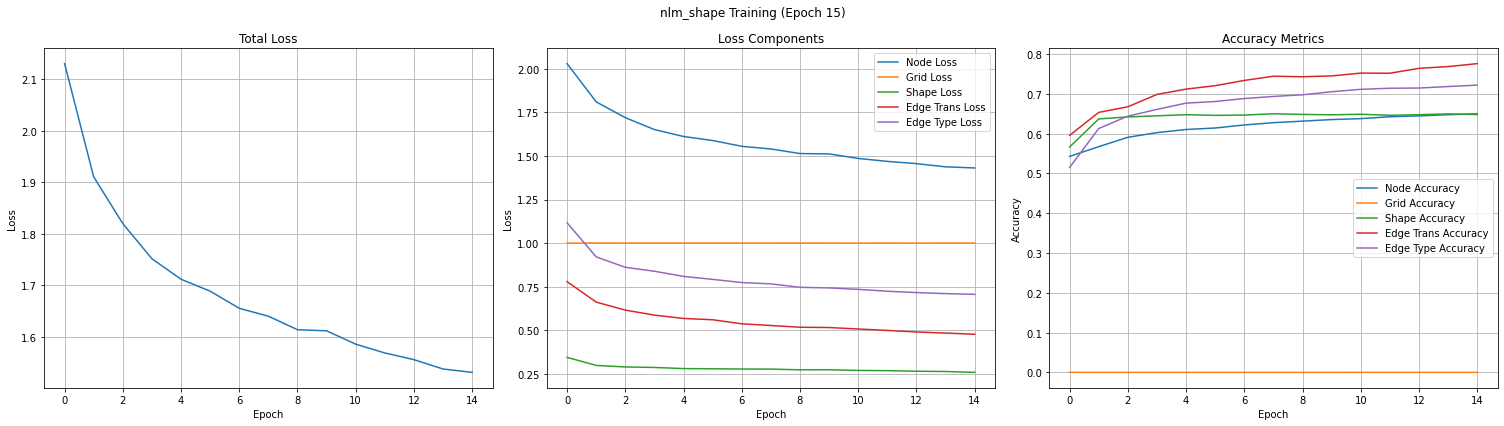

Epoch 16/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.60it/s]


Epoch 16/1000 - Loss: 1.5150 (Node: 1.4150, EdgeTrans: 0.4730, EdgeType: 0.7006, Grid: 1.0000, Shape: 0.2569), Node Acc: 0.6559, Grid Acc: 0.0000, Shape Acc: 0.648428, EdgeTrans Acc: 0.7739, EdgeType Acc: 0.7264


Epoch 17/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.54it/s]


Epoch 17/1000 - Loss: 1.5059 (Node: 1.4059, EdgeTrans: 0.4688, EdgeType: 0.6944, Grid: 0.9999, Shape: 0.2482), Node Acc: 0.6568, Grid Acc: 0.0001, Shape Acc: 0.650840, EdgeTrans Acc: 0.7665, EdgeType Acc: 0.7273


Epoch 18/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.60it/s]


Epoch 18/1000 - Loss: 1.4924 (Node: 1.3924, EdgeTrans: 0.4671, EdgeType: 0.6898, Grid: 0.9999, Shape: 0.2464), Node Acc: 0.6589, Grid Acc: 0.0001, Shape Acc: 0.656494, EdgeTrans Acc: 0.7712, EdgeType Acc: 0.7280


Epoch 19/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.59it/s]


Epoch 19/1000 - Loss: 1.4871 (Node: 1.3871, EdgeTrans: 0.4637, EdgeType: 0.6922, Grid: 0.9999, Shape: 0.2441), Node Acc: 0.6611, Grid Acc: 0.0001, Shape Acc: 0.653667, EdgeTrans Acc: 0.7795, EdgeType Acc: 0.7285


Epoch 20/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.61it/s]


Epoch 20/1000 - Loss: 1.4800 (Node: 1.3800, EdgeTrans: 0.4538, EdgeType: 0.6828, Grid: 1.0000, Shape: 0.2397), Node Acc: 0.6631, Grid Acc: 0.0000, Shape Acc: 0.653917, EdgeTrans Acc: 0.7941, EdgeType Acc: 0.7324
Model state saved to output/models/nlm_shape/nlm_shape_epoch_20.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_20.pt


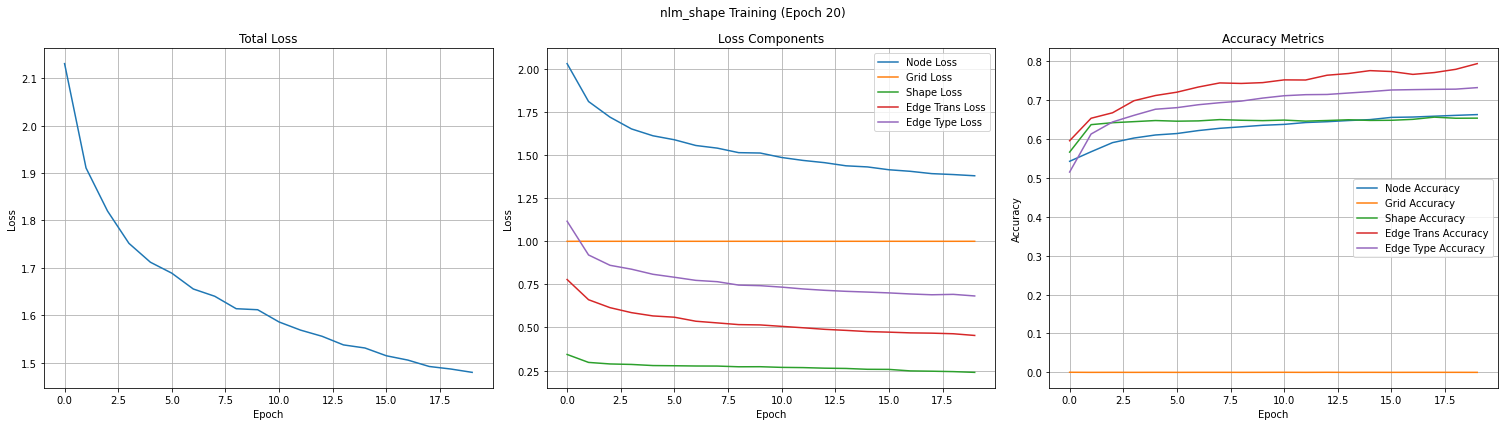

Epoch 21/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.60it/s]


Epoch 21/1000 - Loss: 1.4621 (Node: 1.3621, EdgeTrans: 0.4507, EdgeType: 0.6802, Grid: 0.9999, Shape: 0.2363), Node Acc: 0.6636, Grid Acc: 0.0001, Shape Acc: 0.656411, EdgeTrans Acc: 0.7945, EdgeType Acc: 0.7347


Epoch 22/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.62it/s]


Epoch 22/1000 - Loss: 1.4580 (Node: 1.3580, EdgeTrans: 0.4454, EdgeType: 0.6776, Grid: 0.9999, Shape: 0.2390), Node Acc: 0.6668, Grid Acc: 0.0001, Shape Acc: 0.655330, EdgeTrans Acc: 0.7909, EdgeType Acc: 0.7346


Epoch 23/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.53it/s]


Epoch 23/1000 - Loss: 1.4454 (Node: 1.3454, EdgeTrans: 0.4410, EdgeType: 0.6670, Grid: 0.9998, Shape: 0.2312), Node Acc: 0.6686, Grid Acc: 0.0002, Shape Acc: 0.658573, EdgeTrans Acc: 0.7847, EdgeType Acc: 0.7357


Epoch 24/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.59it/s]


Epoch 24/1000 - Loss: 1.4313 (Node: 1.3313, EdgeTrans: 0.4374, EdgeType: 0.6676, Grid: 0.9999, Shape: 0.2294), Node Acc: 0.6709, Grid Acc: 0.0001, Shape Acc: 0.662232, EdgeTrans Acc: 0.7943, EdgeType Acc: 0.7404


Epoch 25/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.64it/s]


Epoch 25/1000 - Loss: 1.4270 (Node: 1.3270, EdgeTrans: 0.4346, EdgeType: 0.6591, Grid: 0.9999, Shape: 0.2296), Node Acc: 0.6729, Grid Acc: 0.0001, Shape Acc: 0.661982, EdgeTrans Acc: 0.7977, EdgeType Acc: 0.7388
Model state saved to output/models/nlm_shape/nlm_shape_epoch_25.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_25.pt


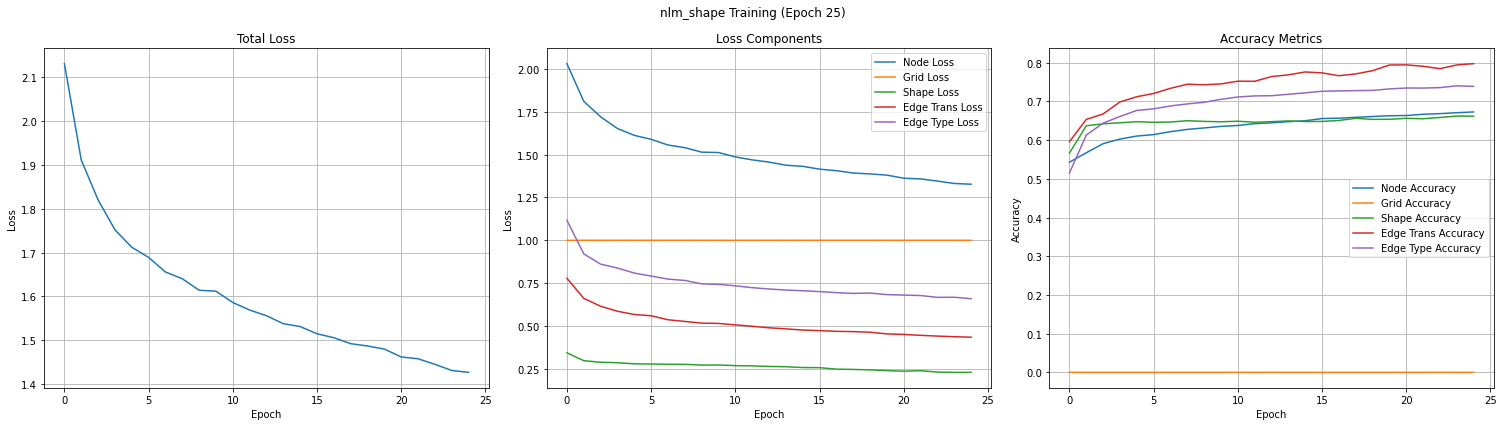

Epoch 26/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.79it/s]


Epoch 26/1000 - Loss: 1.4176 (Node: 1.3176, EdgeTrans: 0.4305, EdgeType: 0.6585, Grid: 0.9998, Shape: 0.2293), Node Acc: 0.6770, Grid Acc: 0.0002, Shape Acc: 0.668468, EdgeTrans Acc: 0.7962, EdgeType Acc: 0.7422


Epoch 27/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.62it/s]


Epoch 27/1000 - Loss: 1.4131 (Node: 1.3131, EdgeTrans: 0.4315, EdgeType: 0.6640, Grid: 0.9998, Shape: 0.2277), Node Acc: 0.6783, Grid Acc: 0.0002, Shape Acc: 0.661816, EdgeTrans Acc: 0.8041, EdgeType Acc: 0.7399


Epoch 28/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.70it/s]


Epoch 28/1000 - Loss: 1.4059 (Node: 1.3060, EdgeTrans: 0.4306, EdgeType: 0.6621, Grid: 0.9998, Shape: 0.2252), Node Acc: 0.6793, Grid Acc: 0.0002, Shape Acc: 0.665974, EdgeTrans Acc: 0.8017, EdgeType Acc: 0.7435


Epoch 29/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 29/1000 - Loss: 1.3906 (Node: 1.2907, EdgeTrans: 0.4262, EdgeType: 0.6557, Grid: 0.9999, Shape: 0.2244), Node Acc: 0.6823, Grid Acc: 0.0001, Shape Acc: 0.665641, EdgeTrans Acc: 0.8071, EdgeType Acc: 0.7432


Epoch 30/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 30/1000 - Loss: 1.3871 (Node: 1.2872, EdgeTrans: 0.4230, EdgeType: 0.6538, Grid: 0.9997, Shape: 0.2218), Node Acc: 0.6844, Grid Acc: 0.0003, Shape Acc: 0.670630, EdgeTrans Acc: 0.8052, EdgeType Acc: 0.7427
Model state saved to output/models/nlm_shape/nlm_shape_epoch_30.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_30.pt


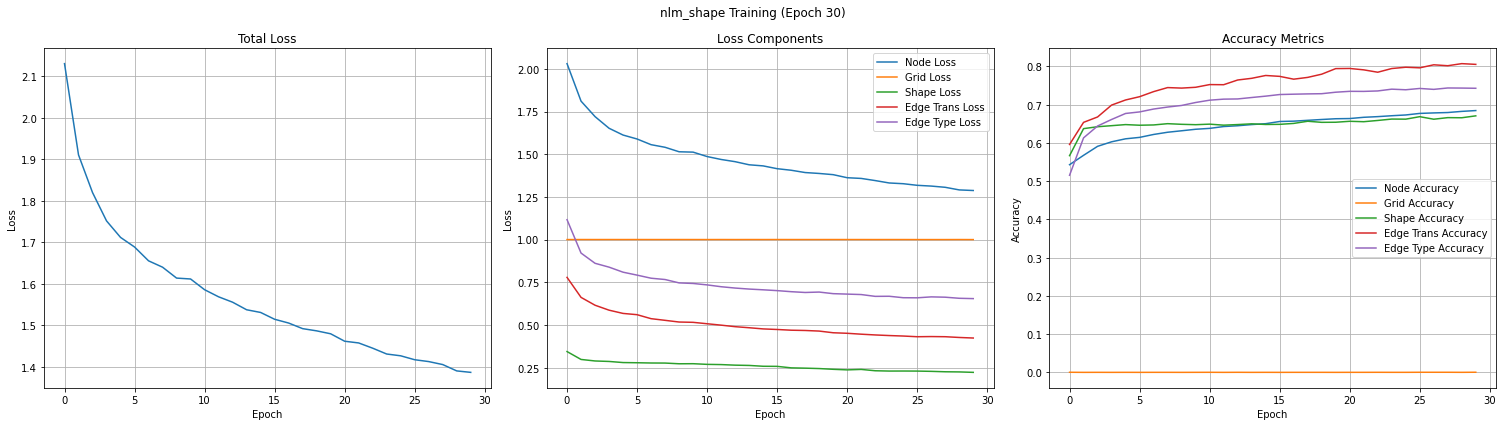

Epoch 31/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.87it/s]


Epoch 31/1000 - Loss: 1.3798 (Node: 1.2798, EdgeTrans: 0.4200, EdgeType: 0.6542, Grid: 0.9997, Shape: 0.2189), Node Acc: 0.6831, Grid Acc: 0.0003, Shape Acc: 0.668385, EdgeTrans Acc: 0.8040, EdgeType Acc: 0.7430


Epoch 32/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.87it/s]


Epoch 32/1000 - Loss: 1.3707 (Node: 1.2708, EdgeTrans: 0.4134, EdgeType: 0.6479, Grid: 0.9998, Shape: 0.2187), Node Acc: 0.6882, Grid Acc: 0.0002, Shape Acc: 0.666722, EdgeTrans Acc: 0.8088, EdgeType Acc: 0.7490


Epoch 33/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.90it/s]


Epoch 33/1000 - Loss: 1.3665 (Node: 1.2666, EdgeTrans: 0.4175, EdgeType: 0.6485, Grid: 0.9999, Shape: 0.2208), Node Acc: 0.6913, Grid Acc: 0.0001, Shape Acc: 0.668302, EdgeTrans Acc: 0.8041, EdgeType Acc: 0.7482


Epoch 34/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.98it/s]


Epoch 34/1000 - Loss: 1.3615 (Node: 1.2615, EdgeTrans: 0.4166, EdgeType: 0.6461, Grid: 0.9998, Shape: 0.2164), Node Acc: 0.6887, Grid Acc: 0.0002, Shape Acc: 0.670880, EdgeTrans Acc: 0.8065, EdgeType Acc: 0.7486


Epoch 35/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.95it/s]


Epoch 35/1000 - Loss: 1.3561 (Node: 1.2561, EdgeTrans: 0.4107, EdgeType: 0.6434, Grid: 0.9999, Shape: 0.2183), Node Acc: 0.6921, Grid Acc: 0.0001, Shape Acc: 0.668053, EdgeTrans Acc: 0.8136, EdgeType Acc: 0.7483
Model state saved to output/models/nlm_shape/nlm_shape_epoch_35.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_35.pt


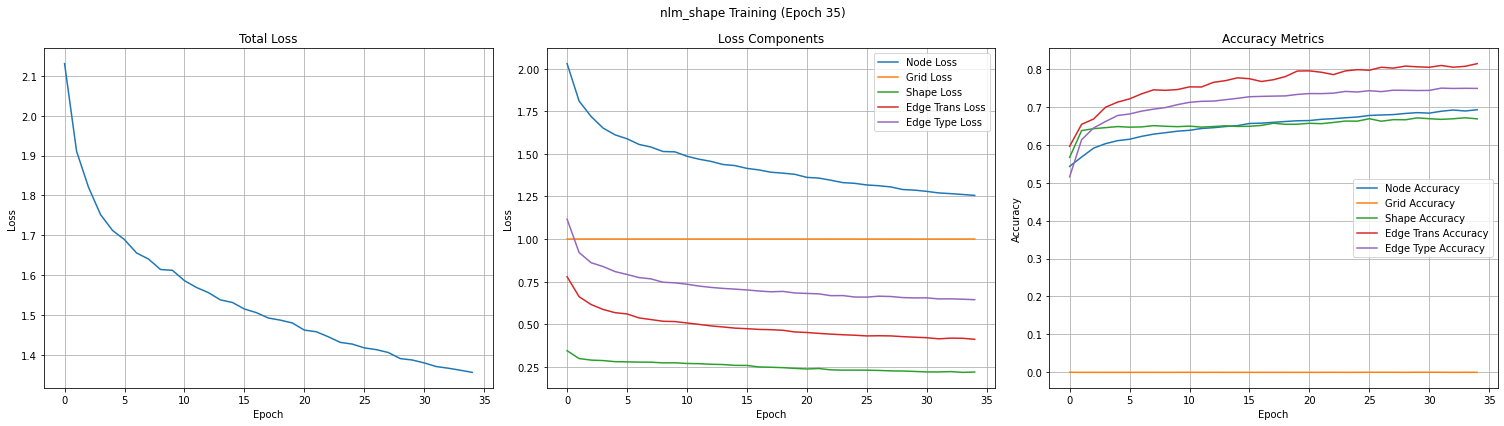

Epoch 36/1000: 100%|██████████| 1504/1504 [01:08<00:00, 22.04it/s]


Epoch 36/1000 - Loss: 1.3568 (Node: 1.2568, EdgeTrans: 0.4132, EdgeType: 0.6463, Grid: 0.9998, Shape: 0.2185), Node Acc: 0.6919, Grid Acc: 0.0002, Shape Acc: 0.670630, EdgeTrans Acc: 0.8069, EdgeType Acc: 0.7486


Epoch 37/1000: 100%|██████████| 1504/1504 [01:08<00:00, 22.01it/s]


Epoch 37/1000 - Loss: 1.3418 (Node: 1.2418, EdgeTrans: 0.4067, EdgeType: 0.6443, Grid: 0.9998, Shape: 0.2126), Node Acc: 0.6932, Grid Acc: 0.0002, Shape Acc: 0.669383, EdgeTrans Acc: 0.8133, EdgeType Acc: 0.7513


Epoch 38/1000: 100%|██████████| 1504/1504 [01:08<00:00, 22.00it/s]


Epoch 38/1000 - Loss: 1.3343 (Node: 1.2343, EdgeTrans: 0.4057, EdgeType: 0.6389, Grid: 0.9997, Shape: 0.2146), Node Acc: 0.6976, Grid Acc: 0.0003, Shape Acc: 0.669549, EdgeTrans Acc: 0.8193, EdgeType Acc: 0.7520


Epoch 39/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.90it/s]


Epoch 39/1000 - Loss: 1.3396 (Node: 1.2396, EdgeTrans: 0.4064, EdgeType: 0.6446, Grid: 0.9996, Shape: 0.2130), Node Acc: 0.7004, Grid Acc: 0.0004, Shape Acc: 0.673291, EdgeTrans Acc: 0.8165, EdgeType Acc: 0.7507


Epoch 40/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.81it/s]


Epoch 40/1000 - Loss: 1.3212 (Node: 1.2212, EdgeTrans: 0.4019, EdgeType: 0.6344, Grid: 0.9997, Shape: 0.2116), Node Acc: 0.7018, Grid Acc: 0.0003, Shape Acc: 0.673125, EdgeTrans Acc: 0.8193, EdgeType Acc: 0.7533
Model state saved to output/models/nlm_shape/nlm_shape_epoch_40.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_40.pt


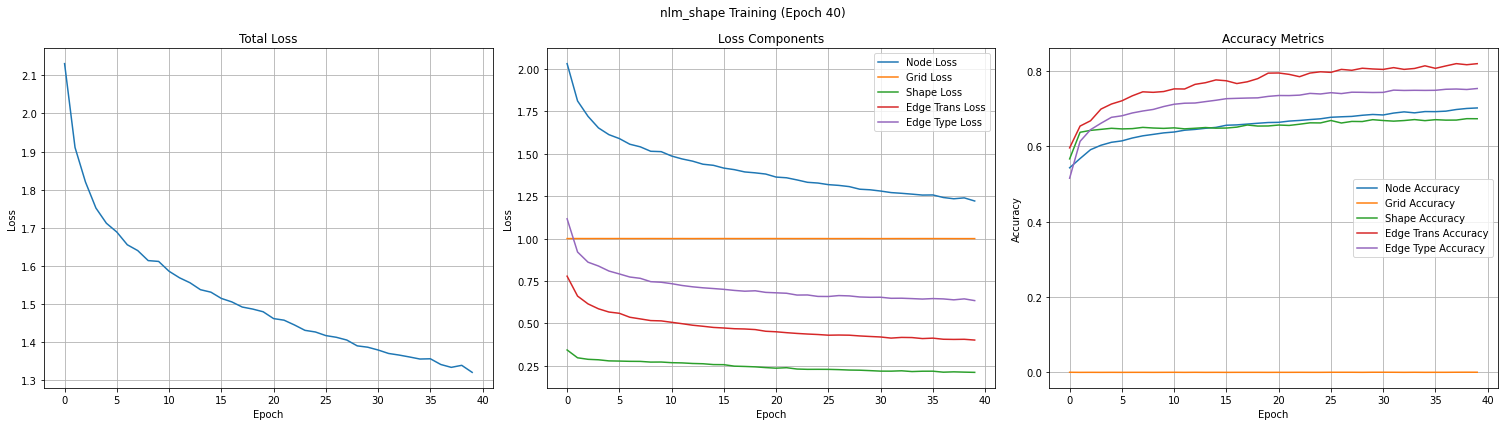

Epoch 41/1000: 100%|██████████| 1504/1504 [01:08<00:00, 22.03it/s]


Epoch 41/1000 - Loss: 1.3185 (Node: 1.2185, EdgeTrans: 0.4066, EdgeType: 0.6336, Grid: 0.9998, Shape: 0.2099), Node Acc: 0.7035, Grid Acc: 0.0002, Shape Acc: 0.672543, EdgeTrans Acc: 0.8182, EdgeType Acc: 0.7564


Epoch 42/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.94it/s]


Epoch 42/1000 - Loss: 1.3123 (Node: 1.2124, EdgeTrans: 0.4005, EdgeType: 0.6293, Grid: 0.9997, Shape: 0.2094), Node Acc: 0.7042, Grid Acc: 0.0003, Shape Acc: 0.671628, EdgeTrans Acc: 0.8162, EdgeType Acc: 0.7553


Epoch 43/1000: 100%|██████████| 1504/1504 [01:08<00:00, 22.01it/s]


Epoch 43/1000 - Loss: 1.3120 (Node: 1.2121, EdgeTrans: 0.3953, EdgeType: 0.6310, Grid: 0.9997, Shape: 0.2064), Node Acc: 0.7046, Grid Acc: 0.0003, Shape Acc: 0.673873, EdgeTrans Acc: 0.8220, EdgeType Acc: 0.7571


Epoch 44/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.90it/s]


Epoch 44/1000 - Loss: 1.3043 (Node: 1.2043, EdgeTrans: 0.3973, EdgeType: 0.6324, Grid: 0.9997, Shape: 0.2080), Node Acc: 0.7075, Grid Acc: 0.0003, Shape Acc: 0.671794, EdgeTrans Acc: 0.8211, EdgeType Acc: 0.7568


Epoch 45/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.97it/s]


Epoch 45/1000 - Loss: 1.2960 (Node: 1.1960, EdgeTrans: 0.3930, EdgeType: 0.6289, Grid: 0.9995, Shape: 0.2063), Node Acc: 0.7081, Grid Acc: 0.0005, Shape Acc: 0.673956, EdgeTrans Acc: 0.8177, EdgeType Acc: 0.7592
Model state saved to output/models/nlm_shape/nlm_shape_epoch_45.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_45.pt


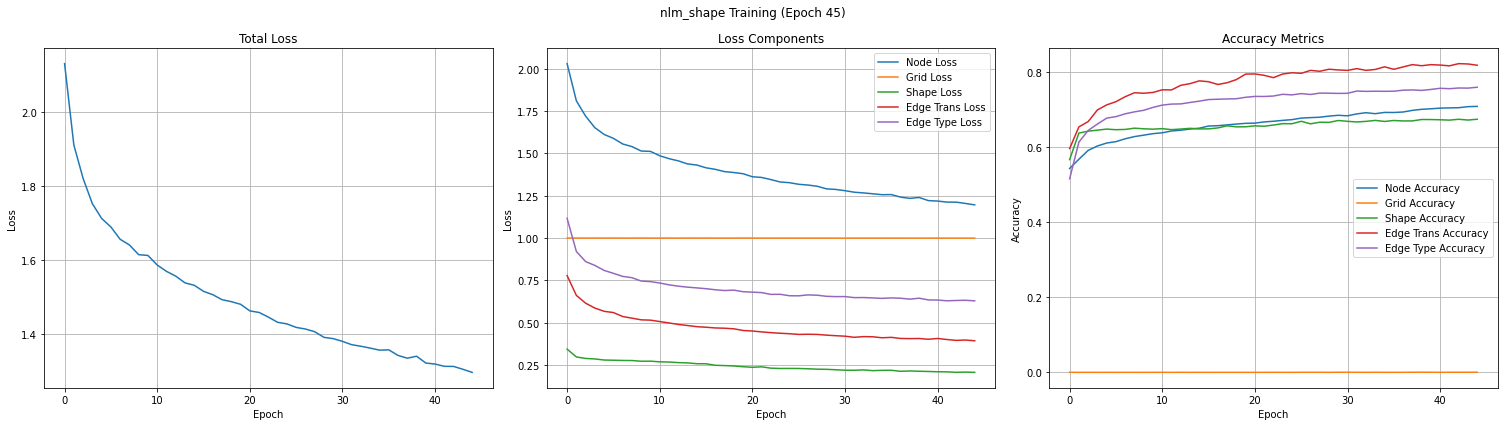

Epoch 46/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.88it/s]


Epoch 46/1000 - Loss: 1.2902 (Node: 1.1902, EdgeTrans: 0.3916, EdgeType: 0.6229, Grid: 0.9998, Shape: 0.2019), Node Acc: 0.7123, Grid Acc: 0.0002, Shape Acc: 0.677283, EdgeTrans Acc: 0.8204, EdgeType Acc: 0.7591


Epoch 47/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.86it/s]


Epoch 47/1000 - Loss: 1.2924 (Node: 1.1924, EdgeTrans: 0.3920, EdgeType: 0.6224, Grid: 0.9998, Shape: 0.2047), Node Acc: 0.7108, Grid Acc: 0.0002, Shape Acc: 0.674788, EdgeTrans Acc: 0.8264, EdgeType Acc: 0.7601


Epoch 48/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.98it/s]


Epoch 48/1000 - Loss: 1.2835 (Node: 1.1835, EdgeTrans: 0.3950, EdgeType: 0.6231, Grid: 0.9998, Shape: 0.2067), Node Acc: 0.7138, Grid Acc: 0.0002, Shape Acc: 0.676368, EdgeTrans Acc: 0.8243, EdgeType Acc: 0.7599


Epoch 49/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.92it/s]


Epoch 49/1000 - Loss: 1.2809 (Node: 1.1810, EdgeTrans: 0.3882, EdgeType: 0.6220, Grid: 0.9998, Shape: 0.1999), Node Acc: 0.7156, Grid Acc: 0.0002, Shape Acc: 0.678447, EdgeTrans Acc: 0.8240, EdgeType Acc: 0.7593


Epoch 50/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.98it/s]


Epoch 50/1000 - Loss: 1.2702 (Node: 1.1703, EdgeTrans: 0.3876, EdgeType: 0.6236, Grid: 0.9995, Shape: 0.2019), Node Acc: 0.7156, Grid Acc: 0.0005, Shape Acc: 0.681274, EdgeTrans Acc: 0.8282, EdgeType Acc: 0.7605
Model state saved to output/models/nlm_shape/nlm_shape_epoch_50.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_50.pt


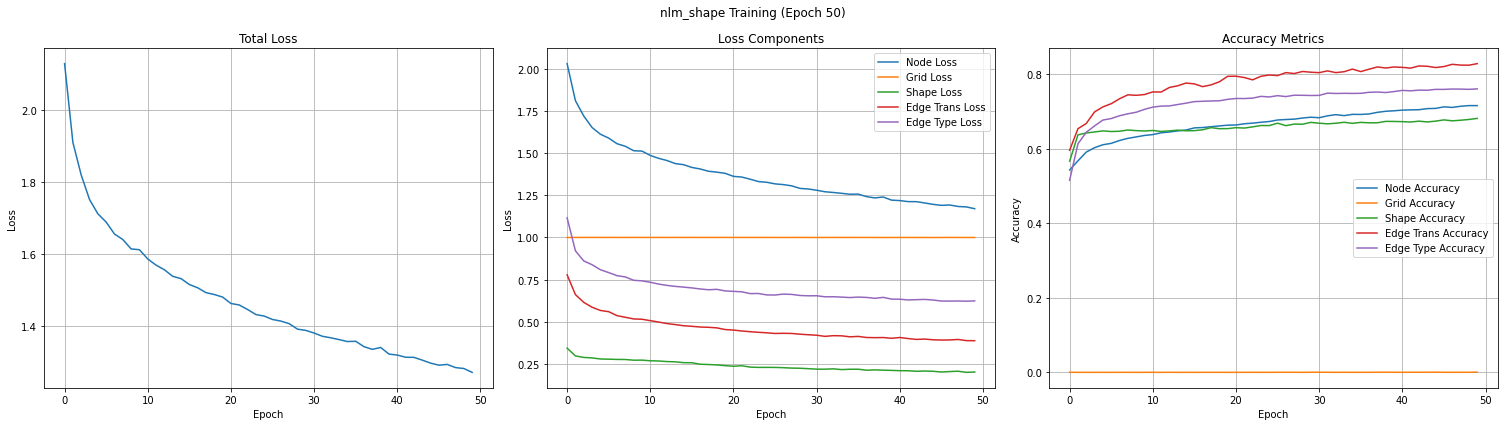

Epoch 51/1000: 100%|██████████| 1504/1504 [01:08<00:00, 22.08it/s]


Epoch 51/1000 - Loss: 1.2665 (Node: 1.1665, EdgeTrans: 0.3887, EdgeType: 0.6160, Grid: 0.9998, Shape: 0.2012), Node Acc: 0.7170, Grid Acc: 0.0002, Shape Acc: 0.677698, EdgeTrans Acc: 0.8170, EdgeType Acc: 0.7598


Epoch 52/1000: 100%|██████████| 1504/1504 [01:08<00:00, 22.05it/s]


Epoch 52/1000 - Loss: 1.2675 (Node: 1.1676, EdgeTrans: 0.3857, EdgeType: 0.6167, Grid: 0.9997, Shape: 0.2010), Node Acc: 0.7196, Grid Acc: 0.0003, Shape Acc: 0.678031, EdgeTrans Acc: 0.8321, EdgeType Acc: 0.7619


Epoch 53/1000: 100%|██████████| 1504/1504 [01:08<00:00, 22.11it/s]


Epoch 53/1000 - Loss: 1.2627 (Node: 1.1628, EdgeTrans: 0.3872, EdgeType: 0.6199, Grid: 0.9996, Shape: 0.1980), Node Acc: 0.7205, Grid Acc: 0.0004, Shape Acc: 0.678696, EdgeTrans Acc: 0.8316, EdgeType Acc: 0.7629


Epoch 54/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.95it/s]


Epoch 54/1000 - Loss: 1.2596 (Node: 1.1597, EdgeTrans: 0.3811, EdgeType: 0.6135, Grid: 0.9993, Shape: 0.1995), Node Acc: 0.7229, Grid Acc: 0.0007, Shape Acc: 0.681440, EdgeTrans Acc: 0.8309, EdgeType Acc: 0.7625


Epoch 55/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.93it/s]


Epoch 55/1000 - Loss: 1.2583 (Node: 1.1584, EdgeTrans: 0.3832, EdgeType: 0.6189, Grid: 0.9998, Shape: 0.1960), Node Acc: 0.7213, Grid Acc: 0.0002, Shape Acc: 0.682355, EdgeTrans Acc: 0.8309, EdgeType Acc: 0.7618
Model state saved to output/models/nlm_shape/nlm_shape_epoch_55.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_55.pt


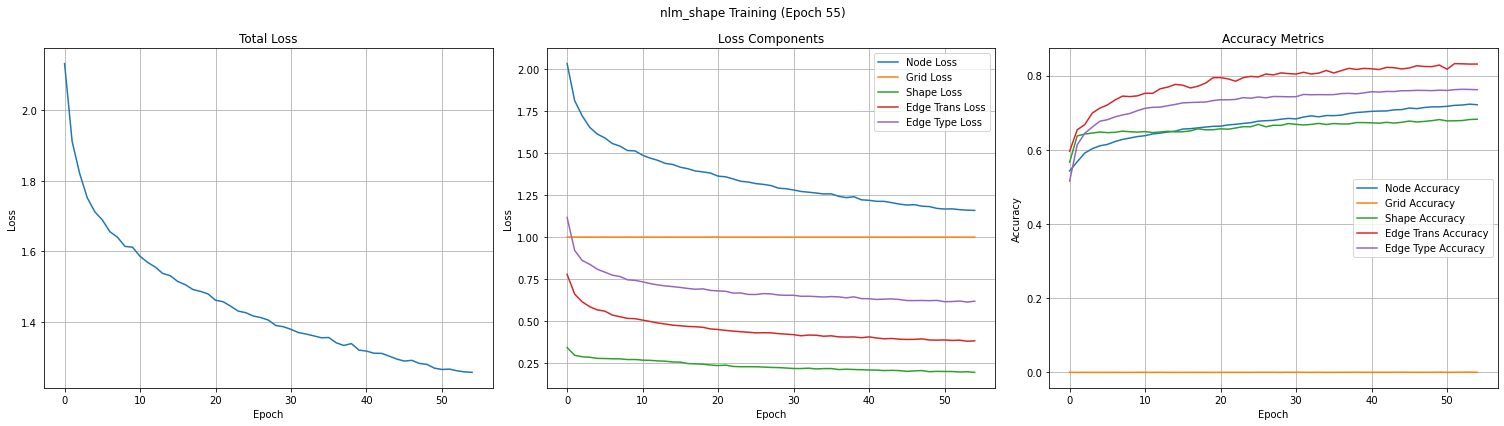

Epoch 56/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.94it/s]


Epoch 56/1000 - Loss: 1.2542 (Node: 1.1542, EdgeTrans: 0.3800, EdgeType: 0.6152, Grid: 0.9998, Shape: 0.1955), Node Acc: 0.7232, Grid Acc: 0.0002, Shape Acc: 0.682438, EdgeTrans Acc: 0.8292, EdgeType Acc: 0.7633


Epoch 57/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.89it/s]


Epoch 57/1000 - Loss: 1.2508 (Node: 1.1508, EdgeTrans: 0.3825, EdgeType: 0.6144, Grid: 1.0000, Shape: 0.1960), Node Acc: 0.7263, Grid Acc: 0.0000, Shape Acc: 0.677366, EdgeTrans Acc: 0.8305, EdgeType Acc: 0.7642


Epoch 58/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.96it/s]


Epoch 58/1000 - Loss: 1.2447 (Node: 1.1448, EdgeTrans: 0.3835, EdgeType: 0.6157, Grid: 0.9995, Shape: 0.1958), Node Acc: 0.7257, Grid Acc: 0.0005, Shape Acc: 0.682438, EdgeTrans Acc: 0.8312, EdgeType Acc: 0.7623


Epoch 59/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.93it/s]


Epoch 59/1000 - Loss: 1.2436 (Node: 1.1436, EdgeTrans: 0.3785, EdgeType: 0.6123, Grid: 0.9998, Shape: 0.1957), Node Acc: 0.7259, Grid Acc: 0.0002, Shape Acc: 0.680775, EdgeTrans Acc: 0.8359, EdgeType Acc: 0.7640


Epoch 60/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.91it/s]


Epoch 60/1000 - Loss: 1.2342 (Node: 1.1343, EdgeTrans: 0.3754, EdgeType: 0.6123, Grid: 0.9998, Shape: 0.1933), Node Acc: 0.7267, Grid Acc: 0.0002, Shape Acc: 0.677283, EdgeTrans Acc: 0.8382, EdgeType Acc: 0.7647
Model state saved to output/models/nlm_shape/nlm_shape_epoch_60.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_60.pt


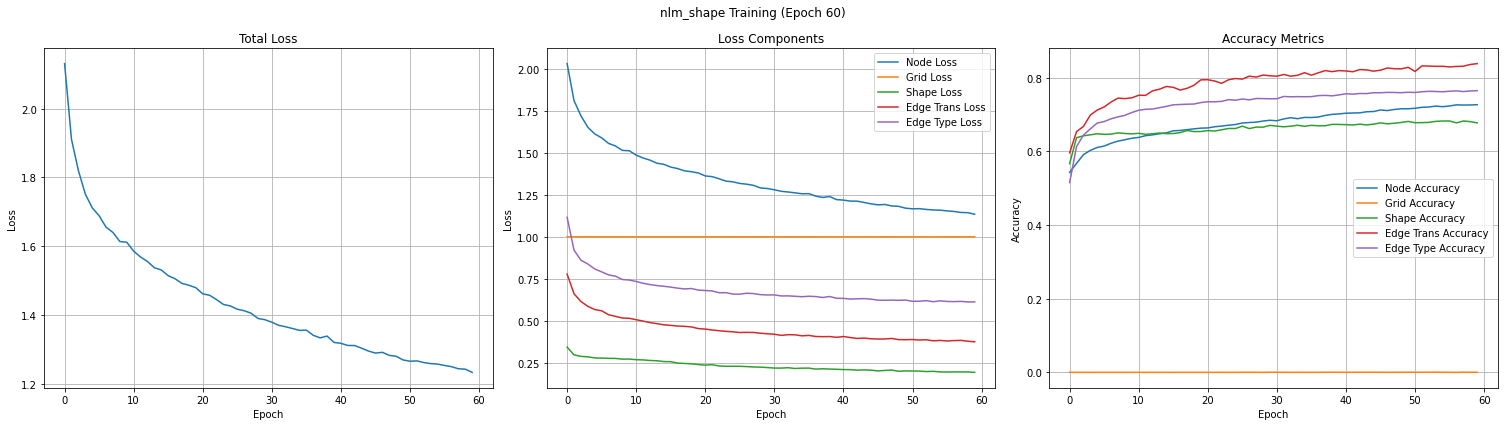

Epoch 61/1000: 100%|██████████| 1504/1504 [02:10<00:00, 11.51it/s]


Epoch 61/1000 - Loss: 1.2334 (Node: 1.1334, EdgeTrans: 0.3804, EdgeType: 0.6070, Grid: 0.9993, Shape: 0.1944), Node Acc: 0.7301, Grid Acc: 0.0007, Shape Acc: 0.681274, EdgeTrans Acc: 0.8411, EdgeType Acc: 0.7668


Epoch 62/1000: 100%|██████████| 1504/1504 [02:15<00:00, 11.07it/s]


Epoch 62/1000 - Loss: 1.2297 (Node: 1.1297, EdgeTrans: 0.3758, EdgeType: 0.6033, Grid: 0.9996, Shape: 0.1942), Node Acc: 0.7305, Grid Acc: 0.0004, Shape Acc: 0.682272, EdgeTrans Acc: 0.8341, EdgeType Acc: 0.7657


Epoch 63/1000: 100%|██████████| 1504/1504 [02:14<00:00, 11.16it/s]


Epoch 63/1000 - Loss: 1.2290 (Node: 1.1291, EdgeTrans: 0.3715, EdgeType: 0.6066, Grid: 0.9998, Shape: 0.1901), Node Acc: 0.7315, Grid Acc: 0.0002, Shape Acc: 0.685515, EdgeTrans Acc: 0.8347, EdgeType Acc: 0.7670


Epoch 64/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.45it/s]


Epoch 64/1000 - Loss: 1.2171 (Node: 1.1171, EdgeTrans: 0.3713, EdgeType: 0.6067, Grid: 0.9998, Shape: 0.1902), Node Acc: 0.7343, Grid Acc: 0.0002, Shape Acc: 0.681607, EdgeTrans Acc: 0.8346, EdgeType Acc: 0.7650


Epoch 65/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.48it/s]


Epoch 65/1000 - Loss: 1.2089 (Node: 1.1089, EdgeTrans: 0.3726, EdgeType: 0.6086, Grid: 0.9998, Shape: 0.1884), Node Acc: 0.7372, Grid Acc: 0.0002, Shape Acc: 0.680609, EdgeTrans Acc: 0.8345, EdgeType Acc: 0.7677
Model state saved to output/models/nlm_shape/nlm_shape_epoch_65.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_65.pt


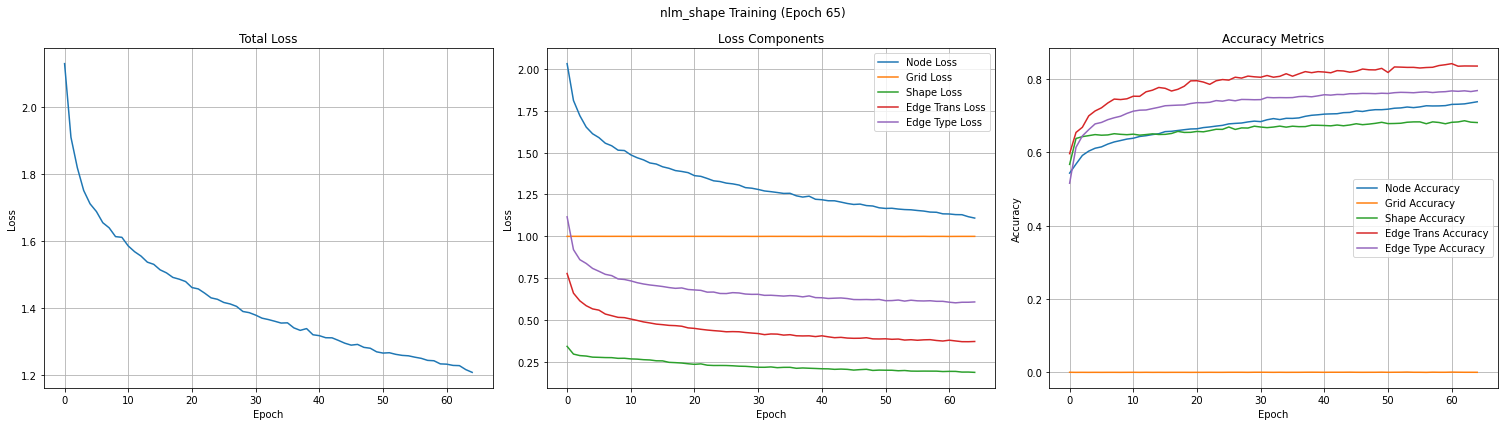

Epoch 66/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.63it/s]


Epoch 66/1000 - Loss: 1.2088 (Node: 1.1089, EdgeTrans: 0.3722, EdgeType: 0.6017, Grid: 0.9993, Shape: 0.1929), Node Acc: 0.7363, Grid Acc: 0.0007, Shape Acc: 0.682189, EdgeTrans Acc: 0.8360, EdgeType Acc: 0.7681


Epoch 67/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.71it/s]


Epoch 67/1000 - Loss: 1.2139 (Node: 1.1140, EdgeTrans: 0.3734, EdgeType: 0.6068, Grid: 0.9998, Shape: 0.1885), Node Acc: 0.7353, Grid Acc: 0.0002, Shape Acc: 0.684184, EdgeTrans Acc: 0.8427, EdgeType Acc: 0.7674


Epoch 68/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.50it/s]


Epoch 68/1000 - Loss: 1.2139 (Node: 1.1139, EdgeTrans: 0.3734, EdgeType: 0.6080, Grid: 0.9995, Shape: 0.1918), Node Acc: 0.7382, Grid Acc: 0.0005, Shape Acc: 0.683103, EdgeTrans Acc: 0.8347, EdgeType Acc: 0.7681


Epoch 69/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.49it/s]


Epoch 69/1000 - Loss: 1.2031 (Node: 1.1031, EdgeTrans: 0.3690, EdgeType: 0.6007, Grid: 0.9997, Shape: 0.1889), Node Acc: 0.7379, Grid Acc: 0.0003, Shape Acc: 0.685182, EdgeTrans Acc: 0.8441, EdgeType Acc: 0.7682


Epoch 70/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.46it/s]


Epoch 70/1000 - Loss: 1.2050 (Node: 1.1050, EdgeTrans: 0.3721, EdgeType: 0.5997, Grid: 0.9998, Shape: 0.1903), Node Acc: 0.7377, Grid Acc: 0.0002, Shape Acc: 0.685847, EdgeTrans Acc: 0.8397, EdgeType Acc: 0.7709
Model state saved to output/models/nlm_shape/nlm_shape_epoch_70.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_70.pt


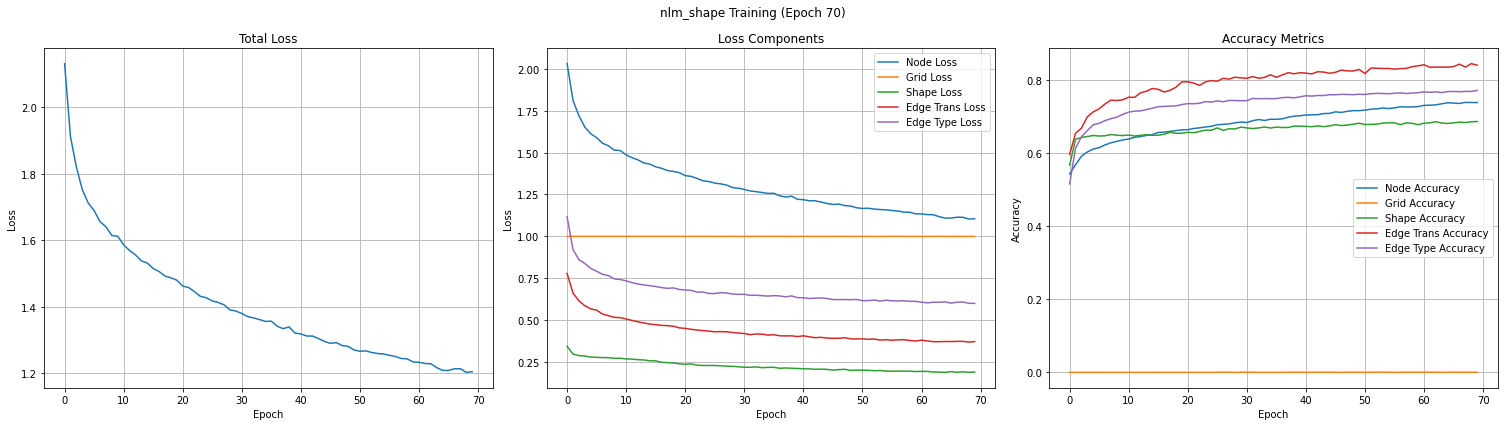

Epoch 71/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.48it/s]


Epoch 71/1000 - Loss: 1.1996 (Node: 1.0997, EdgeTrans: 0.3691, EdgeType: 0.6026, Grid: 0.9996, Shape: 0.1914), Node Acc: 0.7403, Grid Acc: 0.0004, Shape Acc: 0.688591, EdgeTrans Acc: 0.8429, EdgeType Acc: 0.7695


Epoch 72/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.44it/s]


Epoch 72/1000 - Loss: 1.1923 (Node: 1.0923, EdgeTrans: 0.3658, EdgeType: 0.5958, Grid: 0.9997, Shape: 0.1864), Node Acc: 0.7423, Grid Acc: 0.0003, Shape Acc: 0.685930, EdgeTrans Acc: 0.8375, EdgeType Acc: 0.7702


Epoch 73/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.48it/s]


Epoch 73/1000 - Loss: 1.1957 (Node: 1.0958, EdgeTrans: 0.3667, EdgeType: 0.5982, Grid: 0.9996, Shape: 0.1911), Node Acc: 0.7419, Grid Acc: 0.0004, Shape Acc: 0.684683, EdgeTrans Acc: 0.8455, EdgeType Acc: 0.7721


Epoch 74/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.47it/s]


Epoch 74/1000 - Loss: 1.1857 (Node: 1.0857, EdgeTrans: 0.3671, EdgeType: 0.5986, Grid: 0.9997, Shape: 0.1859), Node Acc: 0.7425, Grid Acc: 0.0003, Shape Acc: 0.683436, EdgeTrans Acc: 0.8504, EdgeType Acc: 0.7708


Epoch 75/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.42it/s]


Epoch 75/1000 - Loss: 1.1871 (Node: 1.0871, EdgeTrans: 0.3665, EdgeType: 0.5947, Grid: 0.9997, Shape: 0.1864), Node Acc: 0.7428, Grid Acc: 0.0003, Shape Acc: 0.683685, EdgeTrans Acc: 0.8405, EdgeType Acc: 0.7709
Model state saved to output/models/nlm_shape/nlm_shape_epoch_75.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_75.pt


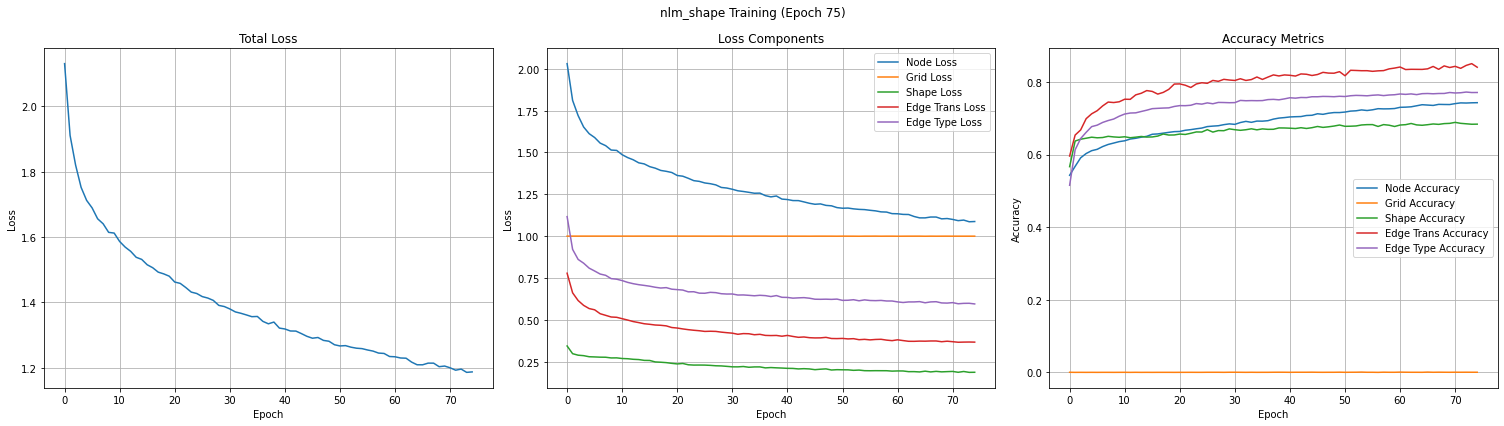

Epoch 76/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.46it/s]


Epoch 76/1000 - Loss: 1.1828 (Node: 1.0828, EdgeTrans: 0.3627, EdgeType: 0.6001, Grid: 0.9999, Shape: 0.1890), Node Acc: 0.7467, Grid Acc: 0.0001, Shape Acc: 0.687594, EdgeTrans Acc: 0.8484, EdgeType Acc: 0.7702


Epoch 77/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.45it/s]


Epoch 77/1000 - Loss: 1.1725 (Node: 1.0725, EdgeTrans: 0.3627, EdgeType: 0.5939, Grid: 0.9998, Shape: 0.1805), Node Acc: 0.7479, Grid Acc: 0.0002, Shape Acc: 0.688425, EdgeTrans Acc: 0.8414, EdgeType Acc: 0.7715


Epoch 78/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.48it/s]


Epoch 78/1000 - Loss: 1.1794 (Node: 1.0794, EdgeTrans: 0.3622, EdgeType: 0.6012, Grid: 0.9998, Shape: 0.1831), Node Acc: 0.7487, Grid Acc: 0.0002, Shape Acc: 0.685515, EdgeTrans Acc: 0.8441, EdgeType Acc: 0.7699


Epoch 79/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.50it/s]


Epoch 79/1000 - Loss: 1.1827 (Node: 1.0827, EdgeTrans: 0.3620, EdgeType: 0.6002, Grid: 0.9996, Shape: 0.1861), Node Acc: 0.7469, Grid Acc: 0.0004, Shape Acc: 0.688342, EdgeTrans Acc: 0.8500, EdgeType Acc: 0.7714


Epoch 80/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.49it/s]


Epoch 80/1000 - Loss: 1.1679 (Node: 1.0679, EdgeTrans: 0.3599, EdgeType: 0.5949, Grid: 0.9995, Shape: 0.1809), Node Acc: 0.7474, Grid Acc: 0.0005, Shape Acc: 0.688425, EdgeTrans Acc: 0.8488, EdgeType Acc: 0.7730
Model state saved to output/models/nlm_shape/nlm_shape_epoch_80.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_80.pt


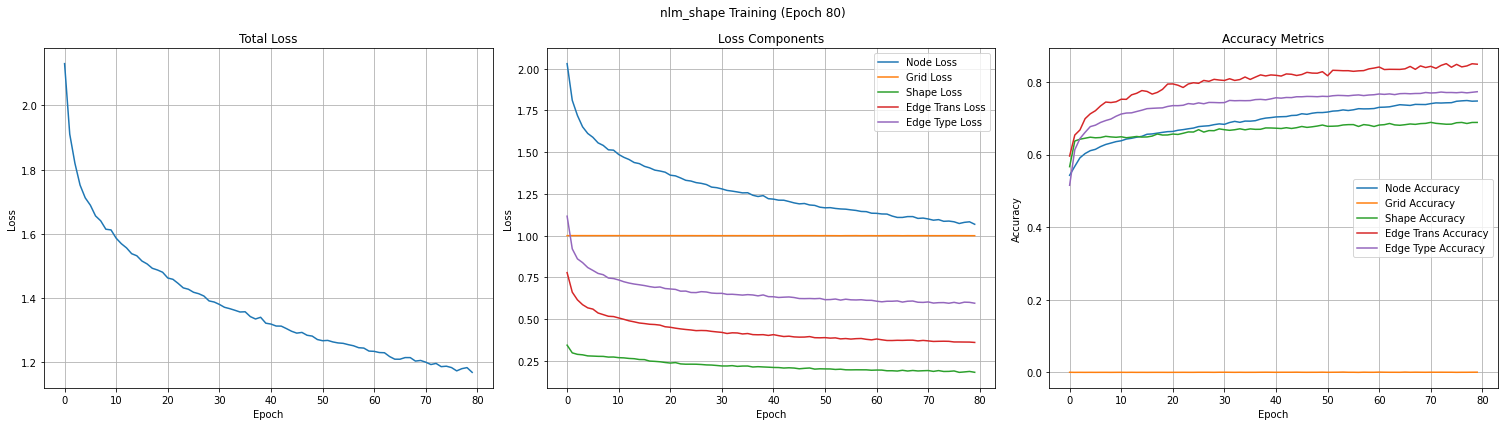

Epoch 81/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.51it/s]


Epoch 81/1000 - Loss: 1.1651 (Node: 1.0652, EdgeTrans: 0.3595, EdgeType: 0.5956, Grid: 0.9997, Shape: 0.1872), Node Acc: 0.7497, Grid Acc: 0.0003, Shape Acc: 0.682604, EdgeTrans Acc: 0.8408, EdgeType Acc: 0.7713


Epoch 82/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.48it/s]


Epoch 82/1000 - Loss: 1.1697 (Node: 1.0697, EdgeTrans: 0.3583, EdgeType: 0.5976, Grid: 0.9998, Shape: 0.1849), Node Acc: 0.7505, Grid Acc: 0.0002, Shape Acc: 0.686346, EdgeTrans Acc: 0.8472, EdgeType Acc: 0.7736


Epoch 83/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.54it/s]


Epoch 83/1000 - Loss: 1.1667 (Node: 1.0667, EdgeTrans: 0.3606, EdgeType: 0.5910, Grid: 0.9993, Shape: 0.1838), Node Acc: 0.7511, Grid Acc: 0.0007, Shape Acc: 0.688092, EdgeTrans Acc: 0.8414, EdgeType Acc: 0.7726


Epoch 84/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.57it/s]


Epoch 84/1000 - Loss: 1.1659 (Node: 1.0660, EdgeTrans: 0.3565, EdgeType: 0.5929, Grid: 0.9995, Shape: 0.1844), Node Acc: 0.7518, Grid Acc: 0.0005, Shape Acc: 0.687011, EdgeTrans Acc: 0.8507, EdgeType Acc: 0.7748


Epoch 85/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.48it/s]


Epoch 85/1000 - Loss: 1.1615 (Node: 1.0615, EdgeTrans: 0.3548, EdgeType: 0.5905, Grid: 0.9997, Shape: 0.1819), Node Acc: 0.7533, Grid Acc: 0.0003, Shape Acc: 0.689173, EdgeTrans Acc: 0.8468, EdgeType Acc: 0.7731
Model state saved to output/models/nlm_shape/nlm_shape_epoch_85.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_85.pt


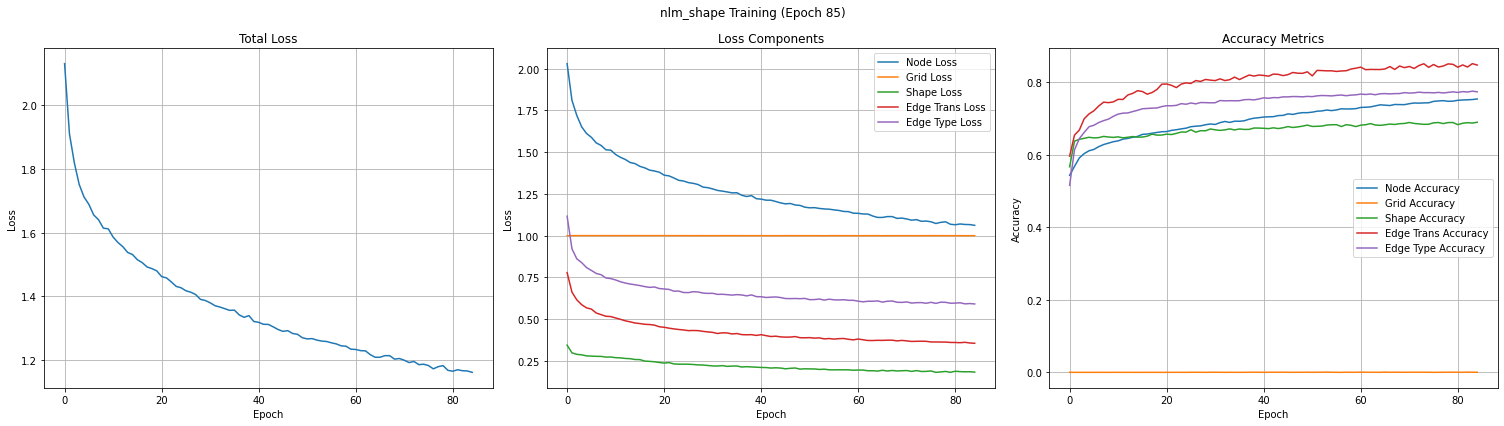

Epoch 86/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.58it/s]


Epoch 86/1000 - Loss: 1.1509 (Node: 1.0510, EdgeTrans: 0.3567, EdgeType: 0.5909, Grid: 0.9995, Shape: 0.1799), Node Acc: 0.7558, Grid Acc: 0.0005, Shape Acc: 0.685847, EdgeTrans Acc: 0.8430, EdgeType Acc: 0.7732


Epoch 87/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.54it/s]


Epoch 87/1000 - Loss: 1.1489 (Node: 1.0489, EdgeTrans: 0.3582, EdgeType: 0.5895, Grid: 0.9998, Shape: 0.1822), Node Acc: 0.7565, Grid Acc: 0.0002, Shape Acc: 0.686097, EdgeTrans Acc: 0.8513, EdgeType Acc: 0.7746


Epoch 88/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.62it/s]


Epoch 88/1000 - Loss: 1.1507 (Node: 1.0507, EdgeTrans: 0.3550, EdgeType: 0.5885, Grid: 0.9993, Shape: 0.1820), Node Acc: 0.7559, Grid Acc: 0.0007, Shape Acc: 0.687261, EdgeTrans Acc: 0.8486, EdgeType Acc: 0.7747


Epoch 89/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.65it/s]


Epoch 89/1000 - Loss: 1.1511 (Node: 1.0512, EdgeTrans: 0.3540, EdgeType: 0.5877, Grid: 0.9992, Shape: 0.1793), Node Acc: 0.7569, Grid Acc: 0.0008, Shape Acc: 0.688009, EdgeTrans Acc: 0.8518, EdgeType Acc: 0.7740


Epoch 90/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.57it/s]


Epoch 90/1000 - Loss: 1.1432 (Node: 1.0432, EdgeTrans: 0.3514, EdgeType: 0.5820, Grid: 0.9998, Shape: 0.1801), Node Acc: 0.7571, Grid Acc: 0.0002, Shape Acc: 0.684600, EdgeTrans Acc: 0.8533, EdgeType Acc: 0.7750
Model state saved to output/models/nlm_shape/nlm_shape_epoch_90.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_90.pt


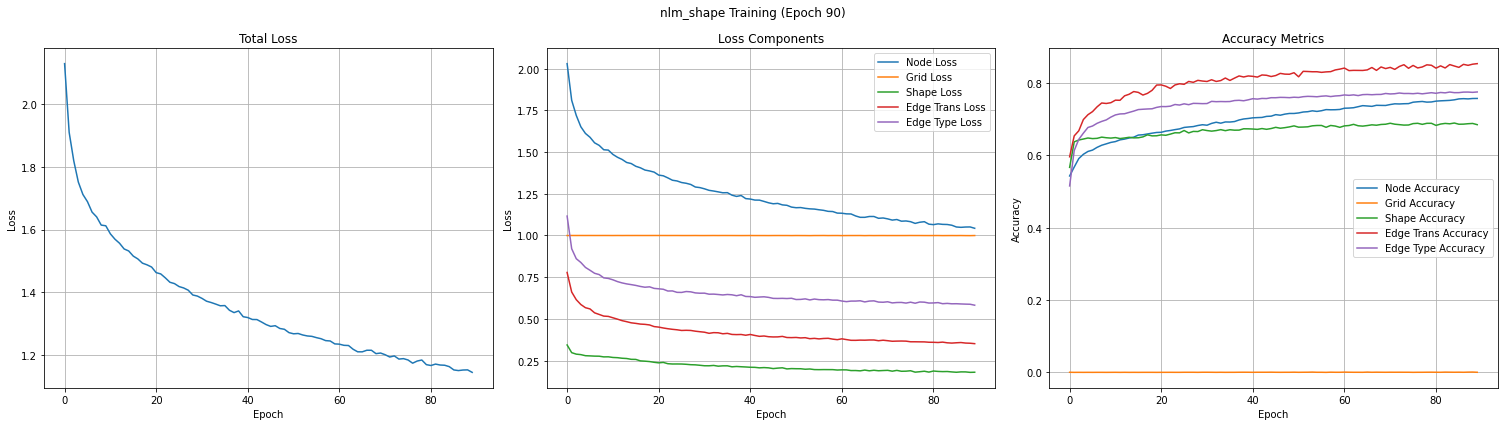

Epoch 92/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.65it/s]


Epoch 92/1000 - Loss: 1.1259 (Node: 1.0260, EdgeTrans: 0.3520, EdgeType: 0.5796, Grid: 0.9995, Shape: 0.1782), Node Acc: 0.7605, Grid Acc: 0.0005, Shape Acc: 0.689839, EdgeTrans Acc: 0.8488, EdgeType Acc: 0.7771


Epoch 93/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 93/1000 - Loss: 1.1369 (Node: 1.0370, EdgeTrans: 0.3557, EdgeType: 0.5872, Grid: 0.9993, Shape: 0.1759), Node Acc: 0.7584, Grid Acc: 0.0007, Shape Acc: 0.688758, EdgeTrans Acc: 0.8452, EdgeType Acc: 0.7766


Epoch 94/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.65it/s]


Epoch 94/1000 - Loss: 1.1379 (Node: 1.0379, EdgeTrans: 0.3575, EdgeType: 0.5890, Grid: 0.9993, Shape: 0.1781), Node Acc: 0.7594, Grid Acc: 0.0007, Shape Acc: 0.690920, EdgeTrans Acc: 0.8455, EdgeType Acc: 0.7770


Epoch 95/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.66it/s]


Epoch 95/1000 - Loss: 1.1278 (Node: 1.0278, EdgeTrans: 0.3523, EdgeType: 0.5874, Grid: 0.9994, Shape: 0.1764), Node Acc: 0.7607, Grid Acc: 0.0006, Shape Acc: 0.686263, EdgeTrans Acc: 0.8437, EdgeType Acc: 0.7768
Model state saved to output/models/nlm_shape/nlm_shape_epoch_95.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_95.pt


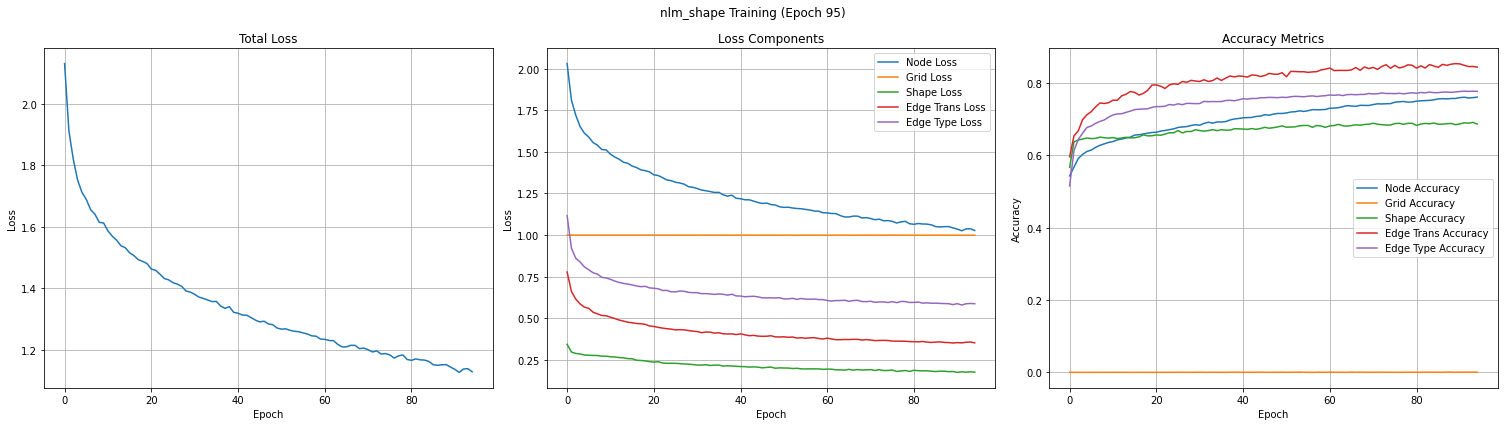

Epoch 97/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.76it/s]


Epoch 97/1000 - Loss: 1.1270 (Node: 1.0271, EdgeTrans: 0.3535, EdgeType: 0.5886, Grid: 0.9993, Shape: 0.1777), Node Acc: 0.7630, Grid Acc: 0.0007, Shape Acc: 0.685598, EdgeTrans Acc: 0.8455, EdgeType Acc: 0.7750


Epoch 98/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.74it/s]


Epoch 98/1000 - Loss: 1.1327 (Node: 1.0327, EdgeTrans: 0.3525, EdgeType: 0.5826, Grid: 0.9996, Shape: 0.1763), Node Acc: 0.7606, Grid Acc: 0.0004, Shape Acc: 0.688342, EdgeTrans Acc: 0.8498, EdgeType Acc: 0.7777


Epoch 99/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.79it/s]


Epoch 99/1000 - Loss: 1.1152 (Node: 1.0152, EdgeTrans: 0.3474, EdgeType: 0.5806, Grid: 0.9994, Shape: 0.1748), Node Acc: 0.7634, Grid Acc: 0.0006, Shape Acc: 0.690338, EdgeTrans Acc: 0.8570, EdgeType Acc: 0.7788


Epoch 101/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.88it/s]


Epoch 101/1000 - Loss: 1.1169 (Node: 1.0169, EdgeTrans: 0.3506, EdgeType: 0.5796, Grid: 0.9993, Shape: 0.1789), Node Acc: 0.7632, Grid Acc: 0.0007, Shape Acc: 0.690254, EdgeTrans Acc: 0.8466, EdgeType Acc: 0.7755


Epoch 102/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 102/1000 - Loss: 1.1172 (Node: 1.0173, EdgeTrans: 0.3489, EdgeType: 0.5836, Grid: 0.9993, Shape: 0.1746), Node Acc: 0.7665, Grid Acc: 0.0007, Shape Acc: 0.692001, EdgeTrans Acc: 0.8521, EdgeType Acc: 0.7782


Epoch 103/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.78it/s]


Epoch 103/1000 - Loss: 1.1097 (Node: 1.0097, EdgeTrans: 0.3491, EdgeType: 0.5810, Grid: 0.9991, Shape: 0.1745), Node Acc: 0.7665, Grid Acc: 0.0009, Shape Acc: 0.691252, EdgeTrans Acc: 0.8518, EdgeType Acc: 0.7784


Epoch 105/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.91it/s]


Epoch 105/1000 - Loss: 1.1156 (Node: 1.0156, EdgeTrans: 0.3508, EdgeType: 0.5802, Grid: 0.9994, Shape: 0.1762), Node Acc: 0.7667, Grid Acc: 0.0006, Shape Acc: 0.692749, EdgeTrans Acc: 0.8540, EdgeType Acc: 0.7796
Model state saved to output/models/nlm_shape/nlm_shape_epoch_105.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_105.pt


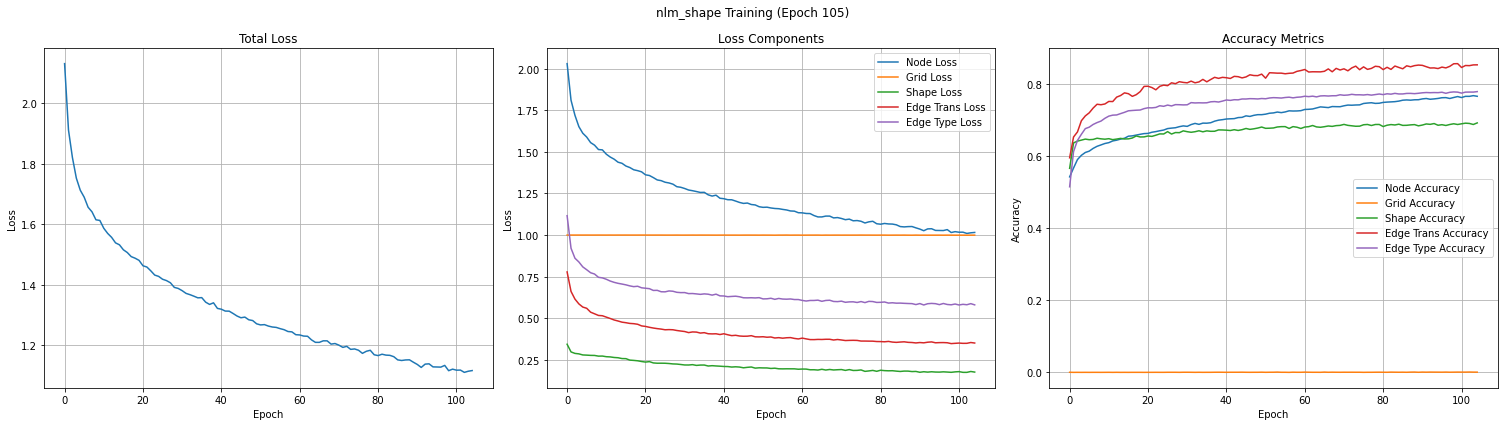

Epoch 106/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.92it/s]


Epoch 106/1000 - Loss: 1.1092 (Node: 1.0092, EdgeTrans: 0.3475, EdgeType: 0.5816, Grid: 0.9994, Shape: 0.1742), Node Acc: 0.7678, Grid Acc: 0.0006, Shape Acc: 0.689340, EdgeTrans Acc: 0.8516, EdgeType Acc: 0.7787


Epoch 107/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.86it/s]


Epoch 107/1000 - Loss: 1.1071 (Node: 1.0072, EdgeTrans: 0.3449, EdgeType: 0.5778, Grid: 0.9995, Shape: 0.1760), Node Acc: 0.7699, Grid Acc: 0.0005, Shape Acc: 0.690005, EdgeTrans Acc: 0.8590, EdgeType Acc: 0.7791


Epoch 108/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.89it/s]


Epoch 108/1000 - Loss: 1.1016 (Node: 1.0017, EdgeTrans: 0.3459, EdgeType: 0.5763, Grid: 0.9995, Shape: 0.1732), Node Acc: 0.7689, Grid Acc: 0.0005, Shape Acc: 0.688009, EdgeTrans Acc: 0.8532, EdgeType Acc: 0.7794


Epoch 109/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.83it/s]


Epoch 109/1000 - Loss: 1.1019 (Node: 1.0020, EdgeTrans: 0.3466, EdgeType: 0.5789, Grid: 0.9992, Shape: 0.1727), Node Acc: 0.7713, Grid Acc: 0.0008, Shape Acc: 0.693082, EdgeTrans Acc: 0.8523, EdgeType Acc: 0.7791


Epoch 110/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.83it/s]


Epoch 110/1000 - Loss: 1.1032 (Node: 1.0032, EdgeTrans: 0.3473, EdgeType: 0.5792, Grid: 0.9993, Shape: 0.1708), Node Acc: 0.7702, Grid Acc: 0.0007, Shape Acc: 0.693497, EdgeTrans Acc: 0.8526, EdgeType Acc: 0.7813
Model state saved to output/models/nlm_shape/nlm_shape_epoch_110.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_110.pt


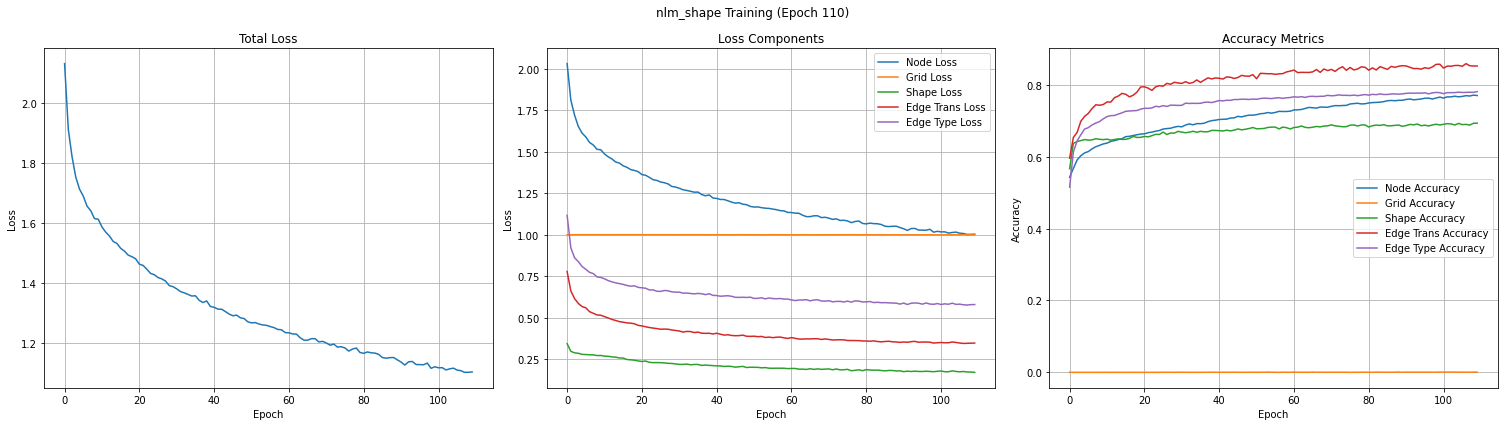

Epoch 111/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.89it/s]


Epoch 111/1000 - Loss: 1.0993 (Node: 0.9993, EdgeTrans: 0.3447, EdgeType: 0.5789, Grid: 0.9993, Shape: 0.1711), Node Acc: 0.7723, Grid Acc: 0.0007, Shape Acc: 0.693165, EdgeTrans Acc: 0.8550, EdgeType Acc: 0.7808


Epoch 112/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.92it/s]


Epoch 112/1000 - Loss: 1.0959 (Node: 0.9960, EdgeTrans: 0.3459, EdgeType: 0.5787, Grid: 0.9993, Shape: 0.1715), Node Acc: 0.7726, Grid Acc: 0.0007, Shape Acc: 0.688508, EdgeTrans Acc: 0.8541, EdgeType Acc: 0.7794


Epoch 113/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.81it/s]


Epoch 113/1000 - Loss: 1.1006 (Node: 1.0007, EdgeTrans: 0.3455, EdgeType: 0.5767, Grid: 0.9996, Shape: 0.1769), Node Acc: 0.7712, Grid Acc: 0.0004, Shape Acc: 0.694495, EdgeTrans Acc: 0.8468, EdgeType Acc: 0.7801


Epoch 114/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.82it/s]


Epoch 114/1000 - Loss: 1.0912 (Node: 0.9913, EdgeTrans: 0.3448, EdgeType: 0.5753, Grid: 0.9992, Shape: 0.1704), Node Acc: 0.7727, Grid Acc: 0.0008, Shape Acc: 0.691003, EdgeTrans Acc: 0.8497, EdgeType Acc: 0.7813


Epoch 115/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.84it/s]


Epoch 115/1000 - Loss: 1.0886 (Node: 0.9887, EdgeTrans: 0.3454, EdgeType: 0.5711, Grid: 0.9993, Shape: 0.1724), Node Acc: 0.7747, Grid Acc: 0.0007, Shape Acc: 0.691086, EdgeTrans Acc: 0.8469, EdgeType Acc: 0.7833
Model state saved to output/models/nlm_shape/nlm_shape_epoch_115.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_115.pt


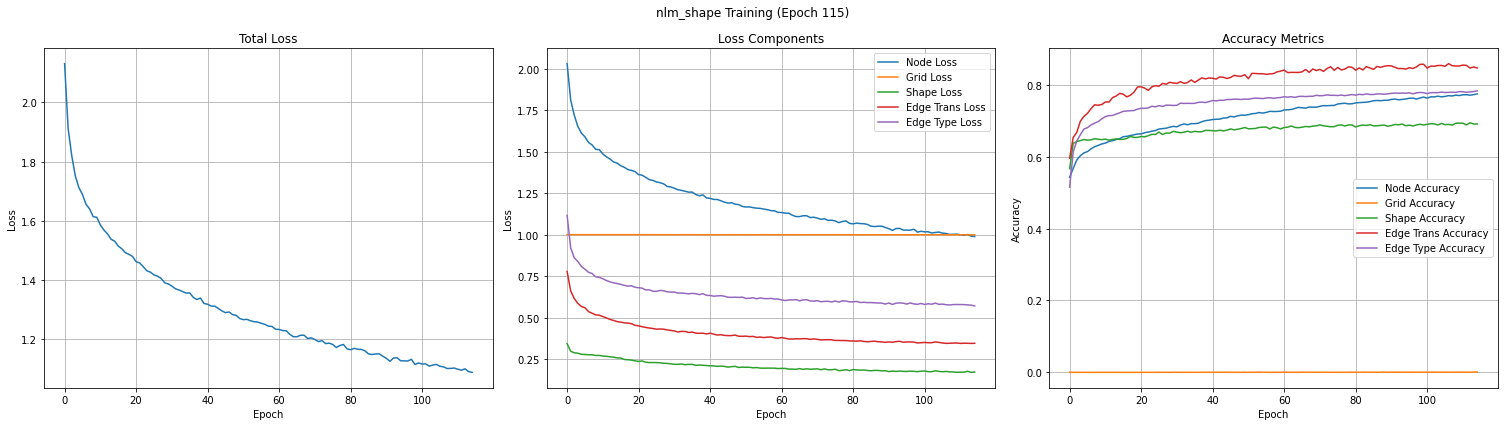

Epoch 116/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.82it/s]


Epoch 116/1000 - Loss: 1.0875 (Node: 0.9875, EdgeTrans: 0.3424, EdgeType: 0.5743, Grid: 0.9992, Shape: 0.1704), Node Acc: 0.7733, Grid Acc: 0.0008, Shape Acc: 0.694828, EdgeTrans Acc: 0.8547, EdgeType Acc: 0.7818


Epoch 117/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.87it/s]


Epoch 117/1000 - Loss: 1.0773 (Node: 0.9774, EdgeTrans: 0.3460, EdgeType: 0.5803, Grid: 0.9994, Shape: 0.1702), Node Acc: 0.7770, Grid Acc: 0.0006, Shape Acc: 0.696657, EdgeTrans Acc: 0.8484, EdgeType Acc: 0.7809


Epoch 118/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.82it/s]


Epoch 118/1000 - Loss: 1.0771 (Node: 0.9771, EdgeTrans: 0.3444, EdgeType: 0.5717, Grid: 0.9995, Shape: 0.1720), Node Acc: 0.7756, Grid Acc: 0.0005, Shape Acc: 0.692001, EdgeTrans Acc: 0.8613, EdgeType Acc: 0.7814


Epoch 119/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.86it/s]


Epoch 119/1000 - Loss: 1.0790 (Node: 0.9791, EdgeTrans: 0.3420, EdgeType: 0.5705, Grid: 0.9993, Shape: 0.1721), Node Acc: 0.7768, Grid Acc: 0.0007, Shape Acc: 0.695410, EdgeTrans Acc: 0.8598, EdgeType Acc: 0.7806


Epoch 120/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.83it/s]


Epoch 120/1000 - Loss: 1.0785 (Node: 0.9786, EdgeTrans: 0.3411, EdgeType: 0.5755, Grid: 0.9993, Shape: 0.1705), Node Acc: 0.7772, Grid Acc: 0.0007, Shape Acc: 0.692500, EdgeTrans Acc: 0.8577, EdgeType Acc: 0.7828
Model state saved to output/models/nlm_shape/nlm_shape_epoch_120.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_120.pt


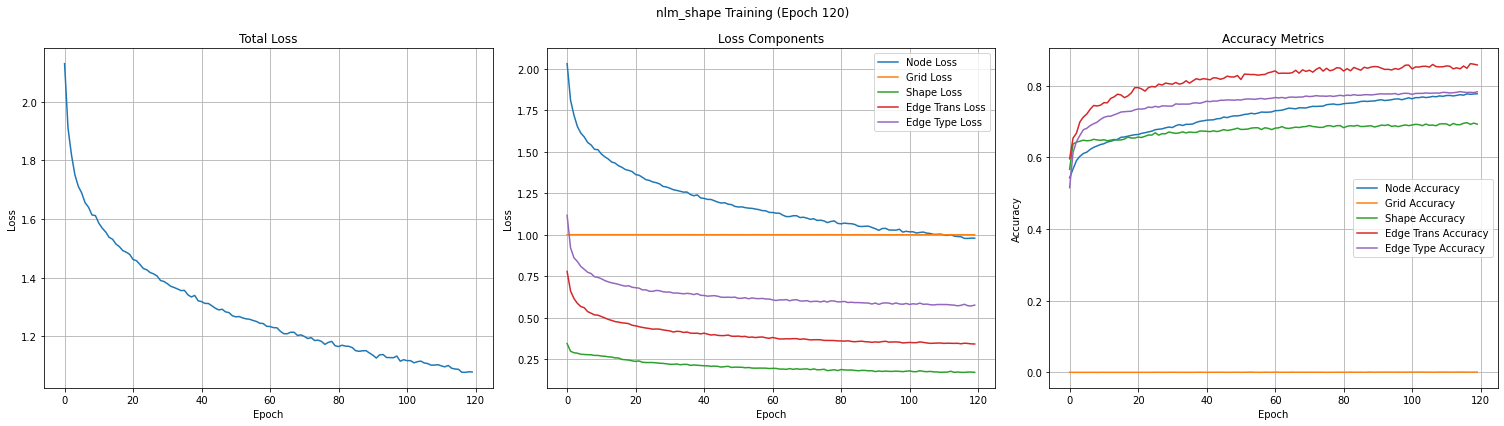

Epoch 121/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.87it/s]


Epoch 121/1000 - Loss: 1.0709 (Node: 0.9710, EdgeTrans: 0.3410, EdgeType: 0.5747, Grid: 0.9995, Shape: 0.1667), Node Acc: 0.7788, Grid Acc: 0.0005, Shape Acc: 0.694246, EdgeTrans Acc: 0.8566, EdgeType Acc: 0.7811


Epoch 122/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.89it/s]


Epoch 122/1000 - Loss: 1.0792 (Node: 0.9793, EdgeTrans: 0.3435, EdgeType: 0.5749, Grid: 0.9994, Shape: 0.1802), Node Acc: 0.7751, Grid Acc: 0.0006, Shape Acc: 0.693165, EdgeTrans Acc: 0.8503, EdgeType Acc: 0.7826


Epoch 124/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.82it/s]


Epoch 124/1000 - Loss: 1.0657 (Node: 0.9658, EdgeTrans: 0.3393, EdgeType: 0.5738, Grid: 0.9994, Shape: 0.1727), Node Acc: 0.7797, Grid Acc: 0.0006, Shape Acc: 0.695410, EdgeTrans Acc: 0.8530, EdgeType Acc: 0.7818


Epoch 125/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.81it/s]


Epoch 125/1000 - Loss: 1.0680 (Node: 0.9681, EdgeTrans: 0.3360, EdgeType: 0.5682, Grid: 0.9991, Shape: 0.1726), Node Acc: 0.7790, Grid Acc: 0.0009, Shape Acc: 0.692416, EdgeTrans Acc: 0.8562, EdgeType Acc: 0.7819
Model state saved to output/models/nlm_shape/nlm_shape_epoch_125.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_125.pt


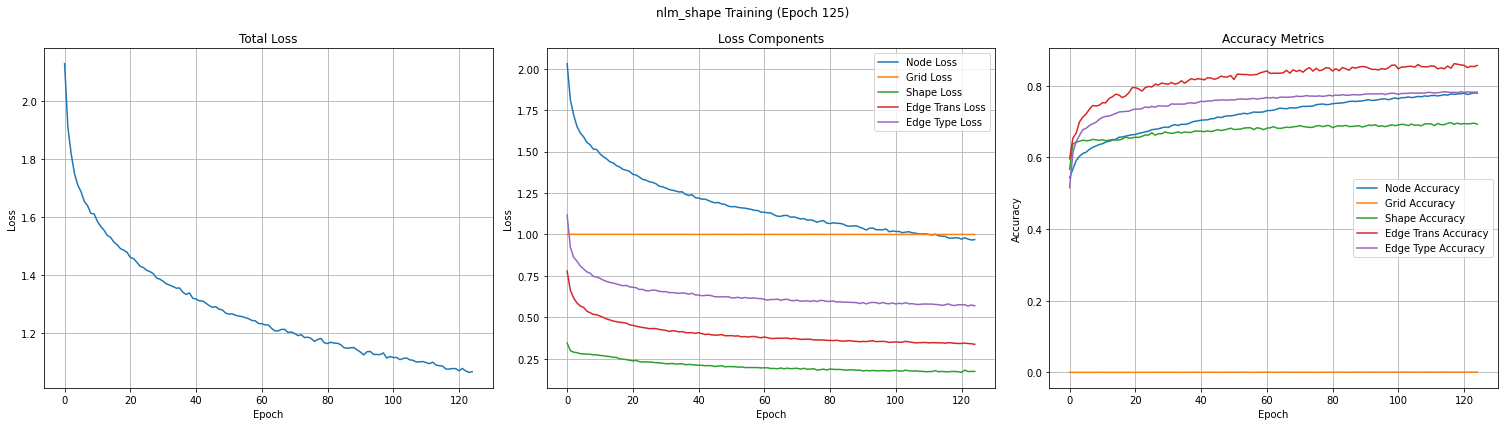

Epoch 126/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.85it/s]


Epoch 126/1000 - Loss: 1.0652 (Node: 0.9653, EdgeTrans: 0.3412, EdgeType: 0.5736, Grid: 0.9991, Shape: 0.1666), Node Acc: 0.7811, Grid Acc: 0.0009, Shape Acc: 0.693747, EdgeTrans Acc: 0.8551, EdgeType Acc: 0.7837


Epoch 127/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.93it/s]


Epoch 127/1000 - Loss: 1.0691 (Node: 0.9692, EdgeTrans: 0.3382, EdgeType: 0.5719, Grid: 0.9992, Shape: 0.1741), Node Acc: 0.7791, Grid Acc: 0.0008, Shape Acc: 0.693996, EdgeTrans Acc: 0.8612, EdgeType Acc: 0.7831


Epoch 128/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.85it/s]


Epoch 128/1000 - Loss: 1.0725 (Node: 0.9726, EdgeTrans: 0.3400, EdgeType: 0.5747, Grid: 0.9991, Shape: 0.1662), Node Acc: 0.7804, Grid Acc: 0.0009, Shape Acc: 0.695743, EdgeTrans Acc: 0.8564, EdgeType Acc: 0.7819


Epoch 129/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.88it/s]


Epoch 129/1000 - Loss: 1.0573 (Node: 0.9574, EdgeTrans: 0.3389, EdgeType: 0.5739, Grid: 0.9993, Shape: 0.1691), Node Acc: 0.7821, Grid Acc: 0.0007, Shape Acc: 0.696824, EdgeTrans Acc: 0.8595, EdgeType Acc: 0.7819


IOPub message rate exceeded.   | 594/1504 [00:26<00:38, 23.95it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 381/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.76it/s]


Epoch 381/1000 - Loss: 0.8458 (Node: 0.7459, EdgeTrans: 0.2997, EdgeType: 0.5253, Grid: 0.9988, Shape: 0.1345), Node Acc: 0.8403, Grid Acc: 0.0012, Shape Acc: 0.714119, EdgeTrans Acc: 0.8765, EdgeType Acc: 0.7945


Epoch 382/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.79it/s]


Epoch 382/1000 - Loss: 0.8418 (Node: 0.7419, EdgeTrans: 0.2952, EdgeType: 0.5243, Grid: 0.9986, Shape: 0.1349), Node Acc: 0.8436, Grid Acc: 0.0014, Shape Acc: 0.716365, EdgeTrans Acc: 0.8760, EdgeType Acc: 0.7984


Epoch 383/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.79it/s]


Epoch 383/1000 - Loss: 0.8522 (Node: 0.7523, EdgeTrans: 0.2999, EdgeType: 0.5260, Grid: 0.9993, Shape: 0.1292), Node Acc: 0.8418, Grid Acc: 0.0007, Shape Acc: 0.715866, EdgeTrans Acc: 0.8730, EdgeType Acc: 0.7975


Epoch 384/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.73it/s]


Epoch 384/1000 - Loss: 0.8448 (Node: 0.7450, EdgeTrans: 0.2991, EdgeType: 0.5273, Grid: 0.9984, Shape: 0.1277), Node Acc: 0.8410, Grid Acc: 0.0016, Shape Acc: 0.715450, EdgeTrans Acc: 0.8776, EdgeType Acc: 0.7980


Epoch 385/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.72it/s]


Epoch 385/1000 - Loss: 0.8428 (Node: 0.7429, EdgeTrans: 0.2988, EdgeType: 0.5239, Grid: 0.9988, Shape: 0.1278), Node Acc: 0.8413, Grid Acc: 0.0012, Shape Acc: 0.716780, EdgeTrans Acc: 0.8799, EdgeType Acc: 0.7961
Model state saved to output/models/nlm_shape/nlm_shape_epoch_385.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_385.pt


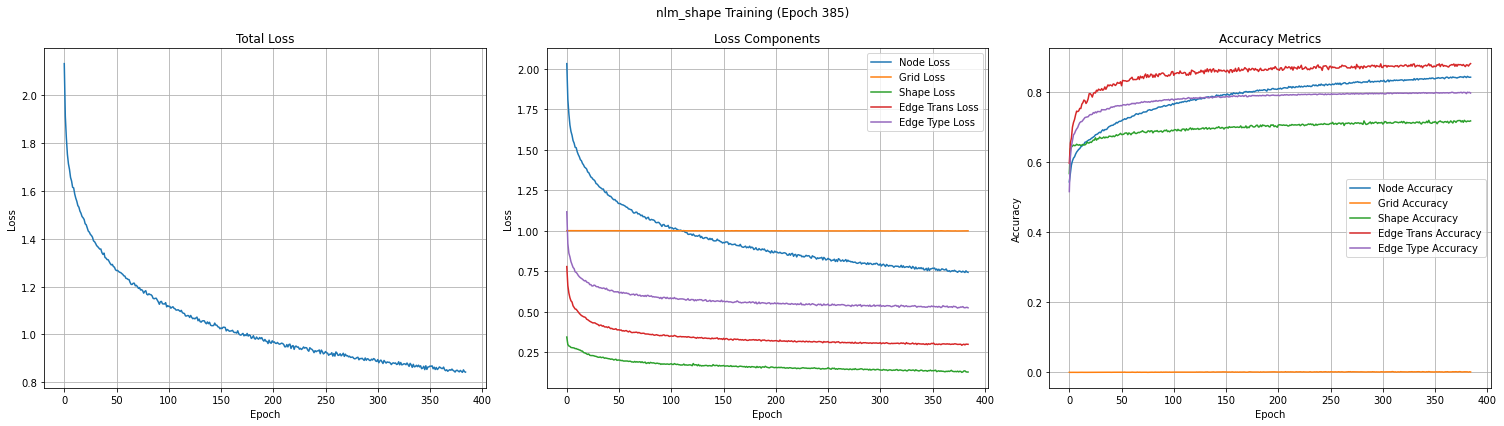

Epoch 386/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.76it/s]


Epoch 386/1000 - Loss: 0.8463 (Node: 0.7464, EdgeTrans: 0.2965, EdgeType: 0.5253, Grid: 0.9987, Shape: 0.1289), Node Acc: 0.8417, Grid Acc: 0.0013, Shape Acc: 0.714868, EdgeTrans Acc: 0.8787, EdgeType Acc: 0.7965


IOPub message rate exceeded.   | 407/1504 [00:18<00:49, 22.20it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 439/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.90it/s]


Epoch 439/1000 - Loss: 0.8263 (Node: 0.7264, EdgeTrans: 0.2954, EdgeType: 0.5255, Grid: 0.9988, Shape: 0.1297), Node Acc: 0.8477, Grid Acc: 0.0012, Shape Acc: 0.716947, EdgeTrans Acc: 0.8769, EdgeType Acc: 0.7987


Epoch 440/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.96it/s]


Epoch 440/1000 - Loss: 0.8204 (Node: 0.7206, EdgeTrans: 0.2931, EdgeType: 0.5226, Grid: 0.9988, Shape: 0.1246), Node Acc: 0.8492, Grid Acc: 0.0012, Shape Acc: 0.718277, EdgeTrans Acc: 0.8792, EdgeType Acc: 0.7992
Model state saved to output/models/nlm_shape/nlm_shape_epoch_440.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_440.pt


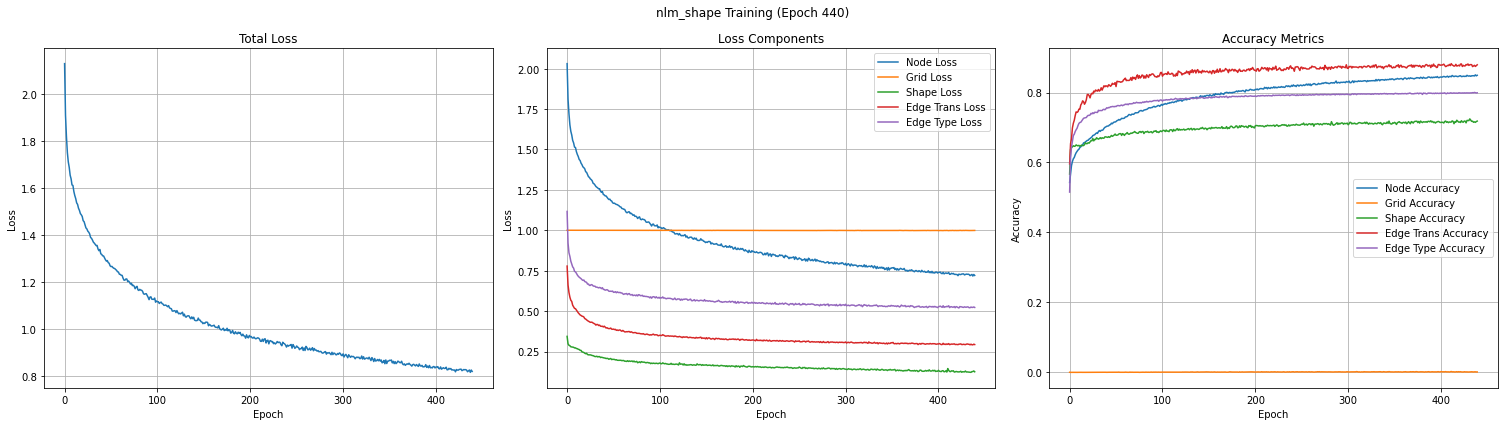

Epoch 441/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.30it/s]


Epoch 441/1000 - Loss: 0.8200 (Node: 0.7202, EdgeTrans: 0.2917, EdgeType: 0.5236, Grid: 0.9978, Shape: 0.1261), Node Acc: 0.8497, Grid Acc: 0.0022, Shape Acc: 0.719774, EdgeTrans Acc: 0.8764, EdgeType Acc: 0.7989


Epoch 442/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.30it/s]


Epoch 442/1000 - Loss: 0.8166 (Node: 0.7168, EdgeTrans: 0.2925, EdgeType: 0.5265, Grid: 0.9978, Shape: 0.1225), Node Acc: 0.8488, Grid Acc: 0.0022, Shape Acc: 0.716281, EdgeTrans Acc: 0.8804, EdgeType Acc: 0.7991


Epoch 443/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.34it/s]


Epoch 443/1000 - Loss: 0.8223 (Node: 0.7225, EdgeTrans: 0.2926, EdgeType: 0.5250, Grid: 0.9986, Shape: 0.1287), Node Acc: 0.8481, Grid Acc: 0.0014, Shape Acc: 0.721853, EdgeTrans Acc: 0.8759, EdgeType Acc: 0.7990


Epoch 444/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.34it/s]


Epoch 444/1000 - Loss: 0.8236 (Node: 0.7237, EdgeTrans: 0.2948, EdgeType: 0.5208, Grid: 0.9986, Shape: 0.1211), Node Acc: 0.8470, Grid Acc: 0.0014, Shape Acc: 0.715866, EdgeTrans Acc: 0.8751, EdgeType Acc: 0.7980


Epoch 445/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.28it/s]


Epoch 445/1000 - Loss: 0.8241 (Node: 0.7243, EdgeTrans: 0.2940, EdgeType: 0.5236, Grid: 0.9985, Shape: 0.1240), Node Acc: 0.8490, Grid Acc: 0.0015, Shape Acc: 0.716365, EdgeTrans Acc: 0.8789, EdgeType Acc: 0.7986
Model state saved to output/models/nlm_shape/nlm_shape_epoch_445.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_445.pt


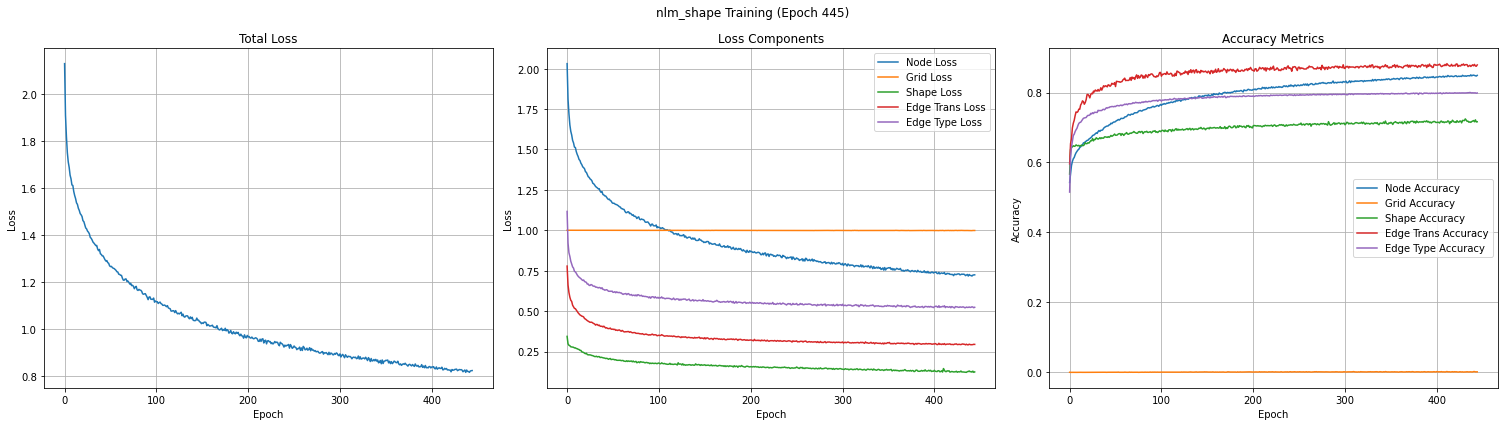

Epoch 446/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.35it/s]


Epoch 446/1000 - Loss: 0.8257 (Node: 0.7259, EdgeTrans: 0.2911, EdgeType: 0.5203, Grid: 0.9978, Shape: 0.1210), Node Acc: 0.8473, Grid Acc: 0.0022, Shape Acc: 0.715616, EdgeTrans Acc: 0.8825, EdgeType Acc: 0.7979


Epoch 447/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.33it/s]


Epoch 447/1000 - Loss: 0.8176 (Node: 0.7177, EdgeTrans: 0.2945, EdgeType: 0.5236, Grid: 0.9983, Shape: 0.1232), Node Acc: 0.8493, Grid Acc: 0.0017, Shape Acc: 0.720522, EdgeTrans Acc: 0.8796, EdgeType Acc: 0.7975


Epoch 448/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.42it/s]


Epoch 448/1000 - Loss: 0.8182 (Node: 0.7184, EdgeTrans: 0.2934, EdgeType: 0.5269, Grid: 0.9985, Shape: 0.1191), Node Acc: 0.8488, Grid Acc: 0.0015, Shape Acc: 0.717529, EdgeTrans Acc: 0.8811, EdgeType Acc: 0.7999


Epoch 449/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.40it/s]


Epoch 449/1000 - Loss: 0.8170 (Node: 0.7171, EdgeTrans: 0.2937, EdgeType: 0.5252, Grid: 0.9984, Shape: 0.1216), Node Acc: 0.8487, Grid Acc: 0.0016, Shape Acc: 0.717279, EdgeTrans Acc: 0.8780, EdgeType Acc: 0.7987


Epoch 450/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.35it/s]


Epoch 450/1000 - Loss: 0.8186 (Node: 0.7187, EdgeTrans: 0.2952, EdgeType: 0.5272, Grid: 0.9988, Shape: 0.1213), Node Acc: 0.8490, Grid Acc: 0.0012, Shape Acc: 0.718942, EdgeTrans Acc: 0.8802, EdgeType Acc: 0.7991
Model state saved to output/models/nlm_shape/nlm_shape_epoch_450.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_450.pt


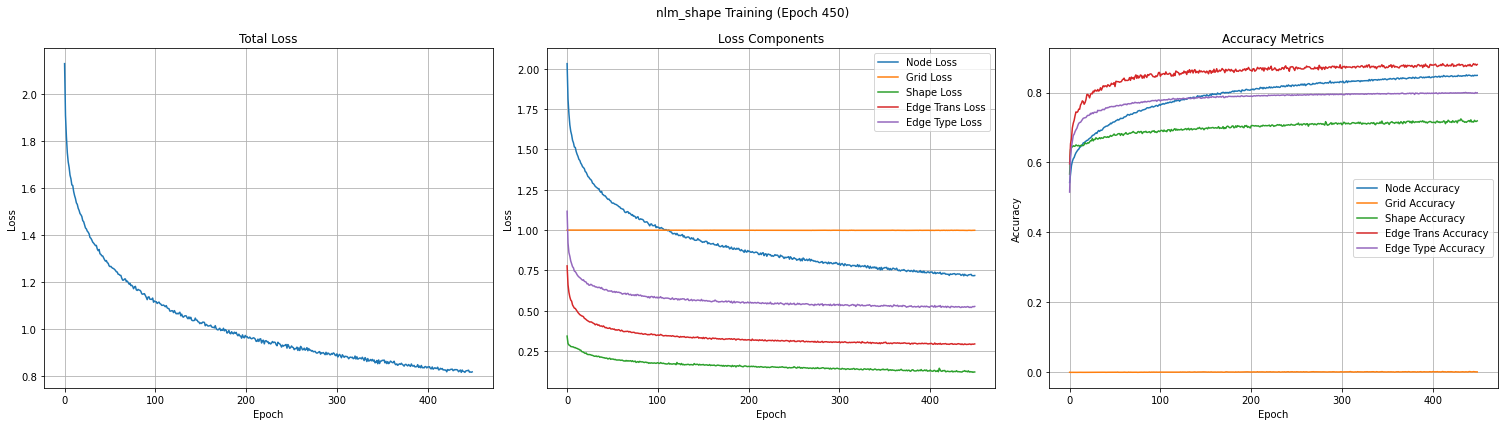

Epoch 451/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.41it/s]


Epoch 451/1000 - Loss: 0.8107 (Node: 0.7108, EdgeTrans: 0.2913, EdgeType: 0.5244, Grid: 0.9987, Shape: 0.1266), Node Acc: 0.8518, Grid Acc: 0.0013, Shape Acc: 0.716281, EdgeTrans Acc: 0.8778, EdgeType Acc: 0.7996


Epoch 452/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.35it/s]


Epoch 452/1000 - Loss: 0.8129 (Node: 0.7130, EdgeTrans: 0.2947, EdgeType: 0.5222, Grid: 0.9982, Shape: 0.1220), Node Acc: 0.8498, Grid Acc: 0.0018, Shape Acc: 0.720522, EdgeTrans Acc: 0.8802, EdgeType Acc: 0.8000


Epoch 454/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.35it/s]


Epoch 454/1000 - Loss: 0.8218 (Node: 0.7220, EdgeTrans: 0.2931, EdgeType: 0.5248, Grid: 0.9982, Shape: 0.1272), Node Acc: 0.8503, Grid Acc: 0.0018, Shape Acc: 0.718028, EdgeTrans Acc: 0.8762, EdgeType Acc: 0.7988


Epoch 455/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.29it/s]


Epoch 455/1000 - Loss: 0.8137 (Node: 0.7139, EdgeTrans: 0.2920, EdgeType: 0.5226, Grid: 0.9979, Shape: 0.1199), Node Acc: 0.8505, Grid Acc: 0.0021, Shape Acc: 0.718776, EdgeTrans Acc: 0.8781, EdgeType Acc: 0.7990
Model state saved to output/models/nlm_shape/nlm_shape_epoch_455.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_455.pt


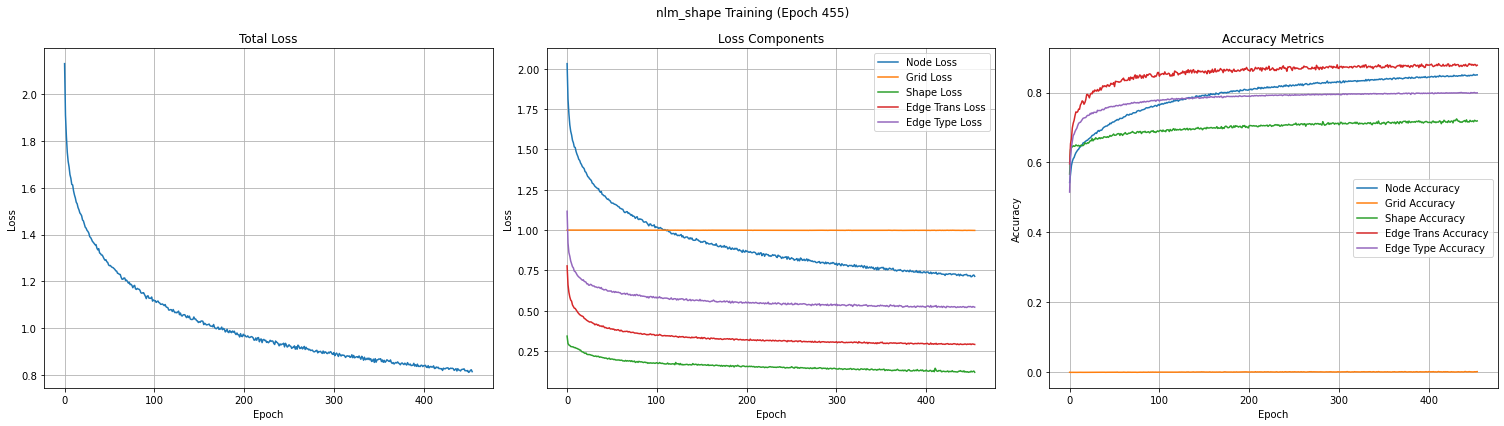

Epoch 456/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.29it/s]


Epoch 456/1000 - Loss: 0.8110 (Node: 0.7111, EdgeTrans: 0.2900, EdgeType: 0.5213, Grid: 0.9983, Shape: 0.1218), Node Acc: 0.8506, Grid Acc: 0.0017, Shape Acc: 0.719358, EdgeTrans Acc: 0.8821, EdgeType Acc: 0.7991


Epoch 457/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.36it/s]


Epoch 457/1000 - Loss: 0.8099 (Node: 0.7101, EdgeTrans: 0.2904, EdgeType: 0.5244, Grid: 0.9986, Shape: 0.1246), Node Acc: 0.8522, Grid Acc: 0.0014, Shape Acc: 0.718194, EdgeTrans Acc: 0.8823, EdgeType Acc: 0.7994


Epoch 458/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.38it/s]


Epoch 458/1000 - Loss: 0.8185 (Node: 0.7186, EdgeTrans: 0.2934, EdgeType: 0.5214, Grid: 0.9987, Shape: 0.1282), Node Acc: 0.8489, Grid Acc: 0.0013, Shape Acc: 0.711874, EdgeTrans Acc: 0.8844, EdgeType Acc: 0.7999


Epoch 461/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.40it/s]


Epoch 461/1000 - Loss: 0.8168 (Node: 0.7170, EdgeTrans: 0.2922, EdgeType: 0.5219, Grid: 0.9981, Shape: 0.1204), Node Acc: 0.8491, Grid Acc: 0.0019, Shape Acc: 0.718776, EdgeTrans Acc: 0.8737, EdgeType Acc: 0.7988


Epoch 462/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.41it/s]


Epoch 462/1000 - Loss: 0.8105 (Node: 0.7106, EdgeTrans: 0.2917, EdgeType: 0.5188, Grid: 0.9988, Shape: 0.1238), Node Acc: 0.8506, Grid Acc: 0.0012, Shape Acc: 0.719940, EdgeTrans Acc: 0.8756, EdgeType Acc: 0.7991


Epoch 463/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.40it/s]


Epoch 463/1000 - Loss: 0.8134 (Node: 0.7135, EdgeTrans: 0.2912, EdgeType: 0.5226, Grid: 0.9986, Shape: 0.1203), Node Acc: 0.8494, Grid Acc: 0.0014, Shape Acc: 0.717778, EdgeTrans Acc: 0.8779, EdgeType Acc: 0.8001


Epoch 464/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.37it/s]


Epoch 464/1000 - Loss: 0.8172 (Node: 0.7174, EdgeTrans: 0.2939, EdgeType: 0.5280, Grid: 0.9979, Shape: 0.1199), Node Acc: 0.8492, Grid Acc: 0.0021, Shape Acc: 0.716531, EdgeTrans Acc: 0.8825, EdgeType Acc: 0.7992


Epoch 465/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.38it/s]


Epoch 465/1000 - Loss: 0.8124 (Node: 0.7126, EdgeTrans: 0.2913, EdgeType: 0.5239, Grid: 0.9988, Shape: 0.1205), Node Acc: 0.8515, Grid Acc: 0.0012, Shape Acc: 0.721603, EdgeTrans Acc: 0.8814, EdgeType Acc: 0.8001
Model state saved to output/models/nlm_shape/nlm_shape_epoch_465.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_465.pt


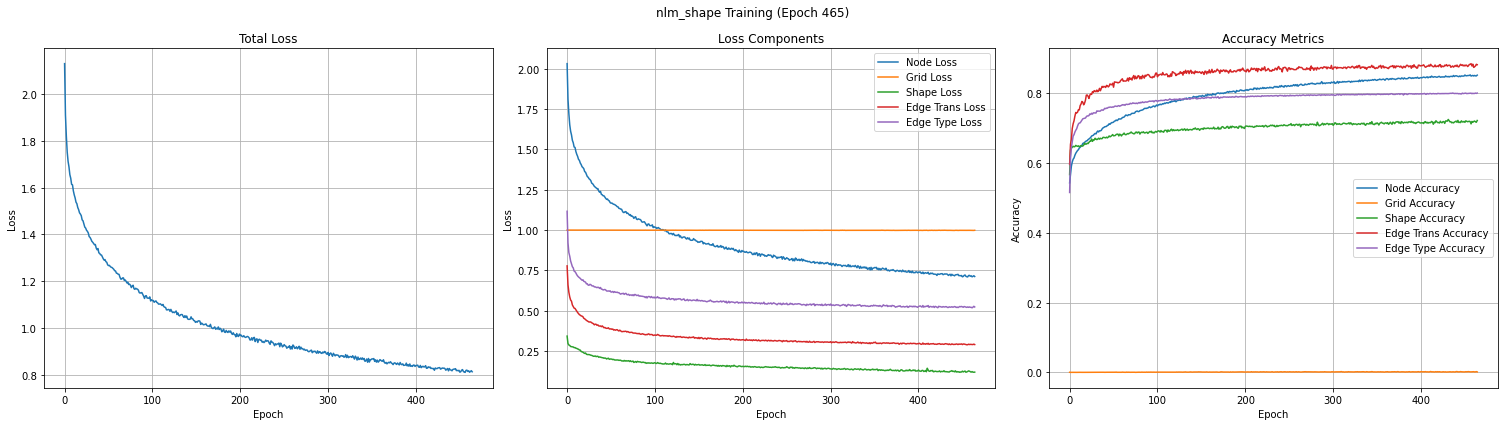

Epoch 466/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.40it/s]


Epoch 466/1000 - Loss: 0.8259 (Node: 0.7260, EdgeTrans: 0.2904, EdgeType: 0.5218, Grid: 0.9988, Shape: 0.1215), Node Acc: 0.8487, Grid Acc: 0.0012, Shape Acc: 0.717196, EdgeTrans Acc: 0.8803, EdgeType Acc: 0.7992


IOPub message rate exceeded.   | 310/1504 [00:14<00:54, 21.84it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 477/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.62it/s]


Epoch 477/1000 - Loss: 0.8073 (Node: 0.7074, EdgeTrans: 0.2895, EdgeType: 0.5223, Grid: 0.9987, Shape: 0.1178), Node Acc: 0.8534, Grid Acc: 0.0013, Shape Acc: 0.721271, EdgeTrans Acc: 0.8824, EdgeType Acc: 0.7995


Epoch 478/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 478/1000 - Loss: 0.8077 (Node: 0.7079, EdgeTrans: 0.2917, EdgeType: 0.5225, Grid: 0.9983, Shape: 0.1233), Node Acc: 0.8512, Grid Acc: 0.0017, Shape Acc: 0.720356, EdgeTrans Acc: 0.8768, EdgeType Acc: 0.7993


Epoch 480/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.60it/s]


Epoch 480/1000 - Loss: 0.8121 (Node: 0.7123, EdgeTrans: 0.2939, EdgeType: 0.5248, Grid: 0.9978, Shape: 0.1194), Node Acc: 0.8535, Grid Acc: 0.0022, Shape Acc: 0.721187, EdgeTrans Acc: 0.8769, EdgeType Acc: 0.8002
Model state saved to output/models/nlm_shape/nlm_shape_epoch_480.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_480.pt


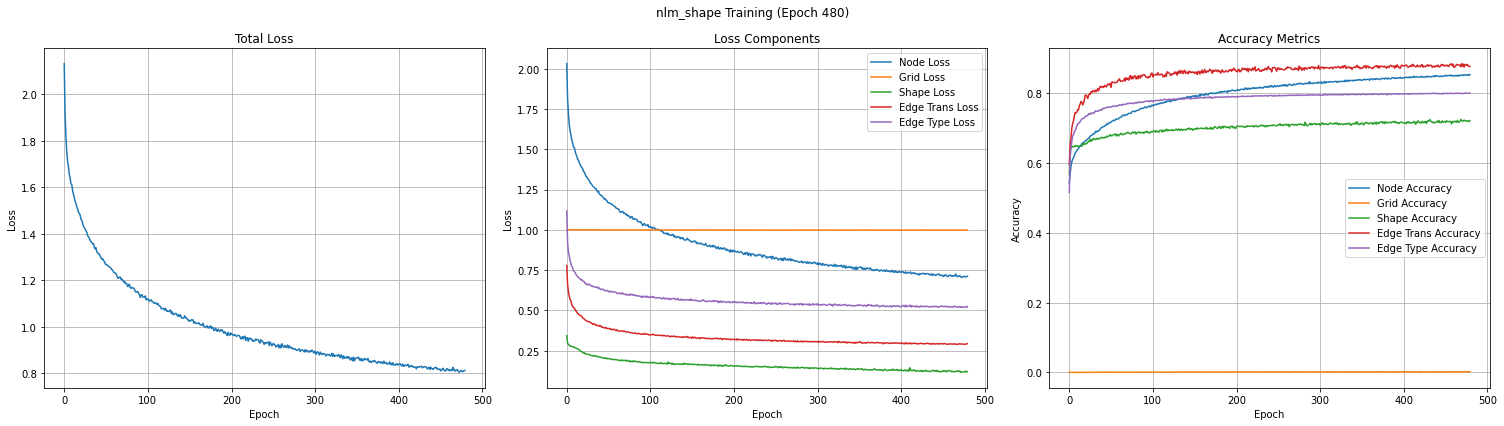

Epoch 481/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.71it/s]


Epoch 481/1000 - Loss: 0.8041 (Node: 0.7043, EdgeTrans: 0.2931, EdgeType: 0.5212, Grid: 0.9985, Shape: 0.1184), Node Acc: 0.8525, Grid Acc: 0.0015, Shape Acc: 0.718111, EdgeTrans Acc: 0.8820, EdgeType Acc: 0.7989


Epoch 482/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 482/1000 - Loss: 0.8059 (Node: 0.7061, EdgeTrans: 0.2855, EdgeType: 0.5221, Grid: 0.9985, Shape: 0.1204), Node Acc: 0.8533, Grid Acc: 0.0015, Shape Acc: 0.717944, EdgeTrans Acc: 0.8815, EdgeType Acc: 0.7987


Epoch 483/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.64it/s]


Epoch 483/1000 - Loss: 0.8102 (Node: 0.7104, EdgeTrans: 0.2930, EdgeType: 0.5223, Grid: 0.9981, Shape: 0.1176), Node Acc: 0.8520, Grid Acc: 0.0019, Shape Acc: 0.721354, EdgeTrans Acc: 0.8791, EdgeType Acc: 0.8001


Epoch 486/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 486/1000 - Loss: 0.8079 (Node: 0.7081, EdgeTrans: 0.2925, EdgeType: 0.5214, Grid: 0.9983, Shape: 0.1215), Node Acc: 0.8522, Grid Acc: 0.0017, Shape Acc: 0.723931, EdgeTrans Acc: 0.8791, EdgeType Acc: 0.7976


Epoch 488/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.67it/s]


Epoch 488/1000 - Loss: 0.8015 (Node: 0.7017, EdgeTrans: 0.2903, EdgeType: 0.5176, Grid: 0.9983, Shape: 0.1197), Node Acc: 0.8536, Grid Acc: 0.0017, Shape Acc: 0.719940, EdgeTrans Acc: 0.8805, EdgeType Acc: 0.8010


Epoch 489/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.67it/s]


Epoch 489/1000 - Loss: 0.8083 (Node: 0.7085, EdgeTrans: 0.2930, EdgeType: 0.5249, Grid: 0.9986, Shape: 0.1224), Node Acc: 0.8534, Grid Acc: 0.0014, Shape Acc: 0.719608, EdgeTrans Acc: 0.8795, EdgeType Acc: 0.8002


Epoch 490/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.66it/s]


Epoch 490/1000 - Loss: 0.8088 (Node: 0.7090, EdgeTrans: 0.2922, EdgeType: 0.5211, Grid: 0.9980, Shape: 0.1208), Node Acc: 0.8535, Grid Acc: 0.0020, Shape Acc: 0.720689, EdgeTrans Acc: 0.8793, EdgeType Acc: 0.7995
Model state saved to output/models/nlm_shape/nlm_shape_epoch_490.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_490.pt


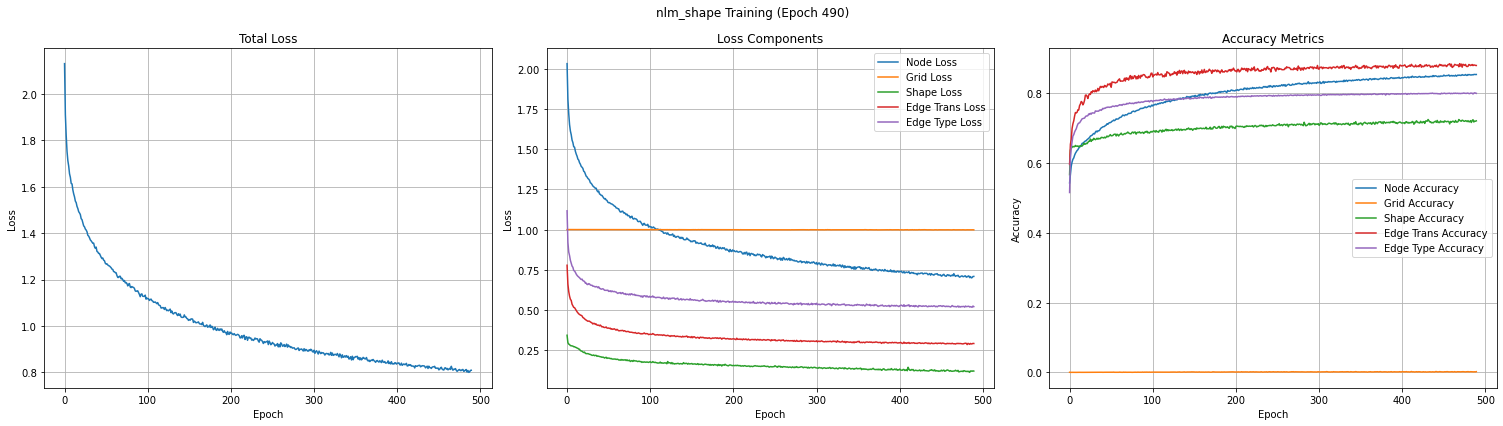

Epoch 491/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.74it/s]


Epoch 491/1000 - Loss: 0.7993 (Node: 0.6995, EdgeTrans: 0.2880, EdgeType: 0.5182, Grid: 0.9989, Shape: 0.1183), Node Acc: 0.8553, Grid Acc: 0.0011, Shape Acc: 0.718443, EdgeTrans Acc: 0.8781, EdgeType Acc: 0.8005


Epoch 492/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 492/1000 - Loss: 0.8017 (Node: 0.7018, EdgeTrans: 0.2896, EdgeType: 0.5185, Grid: 0.9987, Shape: 0.1201), Node Acc: 0.8506, Grid Acc: 0.0013, Shape Acc: 0.720106, EdgeTrans Acc: 0.8838, EdgeType Acc: 0.7996


Epoch 493/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.66it/s]


Epoch 493/1000 - Loss: 0.7984 (Node: 0.6986, EdgeTrans: 0.2897, EdgeType: 0.5218, Grid: 0.9982, Shape: 0.1126), Node Acc: 0.8542, Grid Acc: 0.0018, Shape Acc: 0.716531, EdgeTrans Acc: 0.8778, EdgeType Acc: 0.8002


IOPub message rate exceeded.   | 218/1504 [00:10<00:58, 21.88it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 501/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.74it/s]


Epoch 501/1000 - Loss: 0.7988 (Node: 0.6990, EdgeTrans: 0.2902, EdgeType: 0.5171, Grid: 0.9982, Shape: 0.1153), Node Acc: 0.8532, Grid Acc: 0.0018, Shape Acc: 0.716115, EdgeTrans Acc: 0.8783, EdgeType Acc: 0.8012


Epoch 502/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.75it/s]


Epoch 502/1000 - Loss: 0.7950 (Node: 0.6952, EdgeTrans: 0.2897, EdgeType: 0.5165, Grid: 0.9987, Shape: 0.1137), Node Acc: 0.8548, Grid Acc: 0.0013, Shape Acc: 0.719608, EdgeTrans Acc: 0.8787, EdgeType Acc: 0.8006


Epoch 503/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.72it/s]


Epoch 503/1000 - Loss: 0.8018 (Node: 0.7020, EdgeTrans: 0.2902, EdgeType: 0.5193, Grid: 0.9984, Shape: 0.1147), Node Acc: 0.8523, Grid Acc: 0.0016, Shape Acc: 0.720356, EdgeTrans Acc: 0.8764, EdgeType Acc: 0.7995


Epoch 504/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.73it/s]


Epoch 504/1000 - Loss: 0.7996 (Node: 0.6998, EdgeTrans: 0.2890, EdgeType: 0.5242, Grid: 0.9986, Shape: 0.1199), Node Acc: 0.8537, Grid Acc: 0.0014, Shape Acc: 0.719524, EdgeTrans Acc: 0.8824, EdgeType Acc: 0.7994


Epoch 505/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.74it/s]


Epoch 505/1000 - Loss: 0.8017 (Node: 0.7018, EdgeTrans: 0.2896, EdgeType: 0.5223, Grid: 0.9989, Shape: 0.1188), Node Acc: 0.8539, Grid Acc: 0.0011, Shape Acc: 0.717695, EdgeTrans Acc: 0.8788, EdgeType Acc: 0.8015
Model state saved to output/models/nlm_shape/nlm_shape_epoch_505.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_505.pt


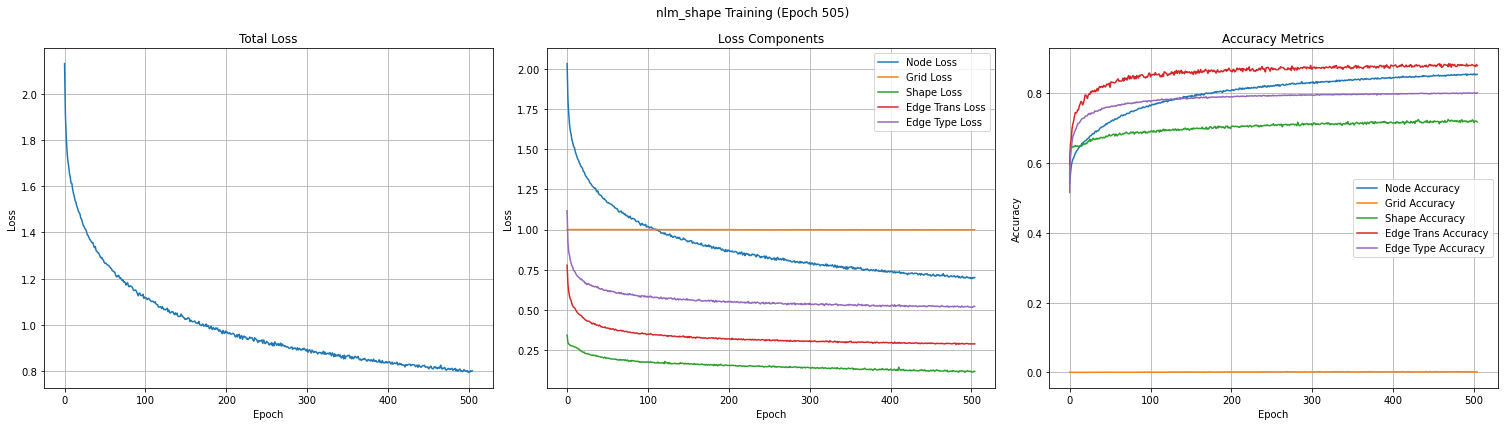

Epoch 506/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.77it/s]


Epoch 506/1000 - Loss: 0.7936 (Node: 0.6937, EdgeTrans: 0.2869, EdgeType: 0.5156, Grid: 0.9983, Shape: 0.1178), Node Acc: 0.8546, Grid Acc: 0.0017, Shape Acc: 0.717113, EdgeTrans Acc: 0.8776, EdgeType Acc: 0.8006


Epoch 507/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.64it/s]


Epoch 507/1000 - Loss: 0.7943 (Node: 0.6944, EdgeTrans: 0.2902, EdgeType: 0.5235, Grid: 0.9985, Shape: 0.1129), Node Acc: 0.8562, Grid Acc: 0.0015, Shape Acc: 0.721187, EdgeTrans Acc: 0.8808, EdgeType Acc: 0.7998


Epoch 508/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.72it/s]


Epoch 508/1000 - Loss: 0.7906 (Node: 0.6908, EdgeTrans: 0.2847, EdgeType: 0.5166, Grid: 0.9984, Shape: 0.1177), Node Acc: 0.8556, Grid Acc: 0.0016, Shape Acc: 0.721354, EdgeTrans Acc: 0.8835, EdgeType Acc: 0.8009


Epoch 509/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.70it/s]


Epoch 509/1000 - Loss: 0.7974 (Node: 0.6976, EdgeTrans: 0.2909, EdgeType: 0.5253, Grid: 0.9983, Shape: 0.1149), Node Acc: 0.8536, Grid Acc: 0.0017, Shape Acc: 0.721187, EdgeTrans Acc: 0.8813, EdgeType Acc: 0.8008


Epoch 510/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.78it/s]


Epoch 510/1000 - Loss: 0.7978 (Node: 0.6980, EdgeTrans: 0.2865, EdgeType: 0.5223, Grid: 0.9985, Shape: 0.1164), Node Acc: 0.8546, Grid Acc: 0.0015, Shape Acc: 0.723349, EdgeTrans Acc: 0.8850, EdgeType Acc: 0.8004
Model state saved to output/models/nlm_shape/nlm_shape_epoch_510.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_510.pt


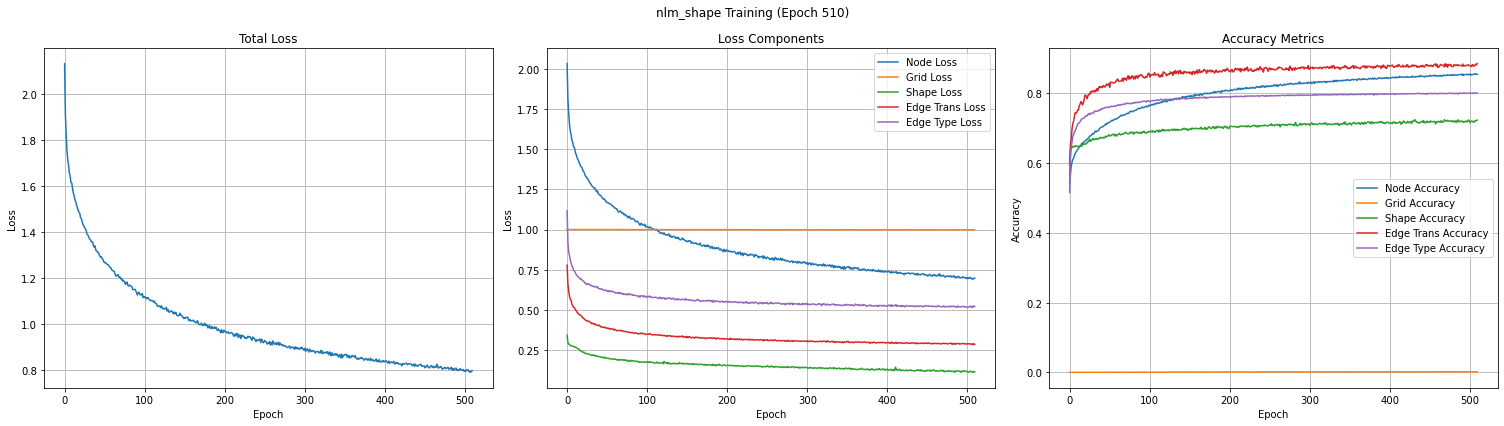

Epoch 511/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.73it/s]


Epoch 511/1000 - Loss: 0.8009 (Node: 0.7011, EdgeTrans: 0.2899, EdgeType: 0.5212, Grid: 0.9980, Shape: 0.1190), Node Acc: 0.8558, Grid Acc: 0.0020, Shape Acc: 0.721437, EdgeTrans Acc: 0.8790, EdgeType Acc: 0.7995


Epoch 512/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.74it/s]


Epoch 512/1000 - Loss: 0.7968 (Node: 0.6970, EdgeTrans: 0.2896, EdgeType: 0.5226, Grid: 0.9984, Shape: 0.1177), Node Acc: 0.8557, Grid Acc: 0.0016, Shape Acc: 0.717279, EdgeTrans Acc: 0.8787, EdgeType Acc: 0.8011


Epoch 513/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.72it/s]


Epoch 513/1000 - Loss: 0.8014 (Node: 0.7015, EdgeTrans: 0.2898, EdgeType: 0.5154, Grid: 0.9986, Shape: 0.1152), Node Acc: 0.8544, Grid Acc: 0.0014, Shape Acc: 0.721187, EdgeTrans Acc: 0.8793, EdgeType Acc: 0.8007


Epoch 514/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.75it/s]


Epoch 514/1000 - Loss: 0.7985 (Node: 0.6986, EdgeTrans: 0.2875, EdgeType: 0.5205, Grid: 0.9983, Shape: 0.1197), Node Acc: 0.8549, Grid Acc: 0.0017, Shape Acc: 0.720106, EdgeTrans Acc: 0.8825, EdgeType Acc: 0.8001


Epoch 515/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.70it/s]


Epoch 515/1000 - Loss: 0.7908 (Node: 0.6911, EdgeTrans: 0.2925, EdgeType: 0.5223, Grid: 0.9978, Shape: 0.1180), Node Acc: 0.8570, Grid Acc: 0.0022, Shape Acc: 0.721686, EdgeTrans Acc: 0.8798, EdgeType Acc: 0.8005
Model state saved to output/models/nlm_shape/nlm_shape_epoch_515.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_515.pt


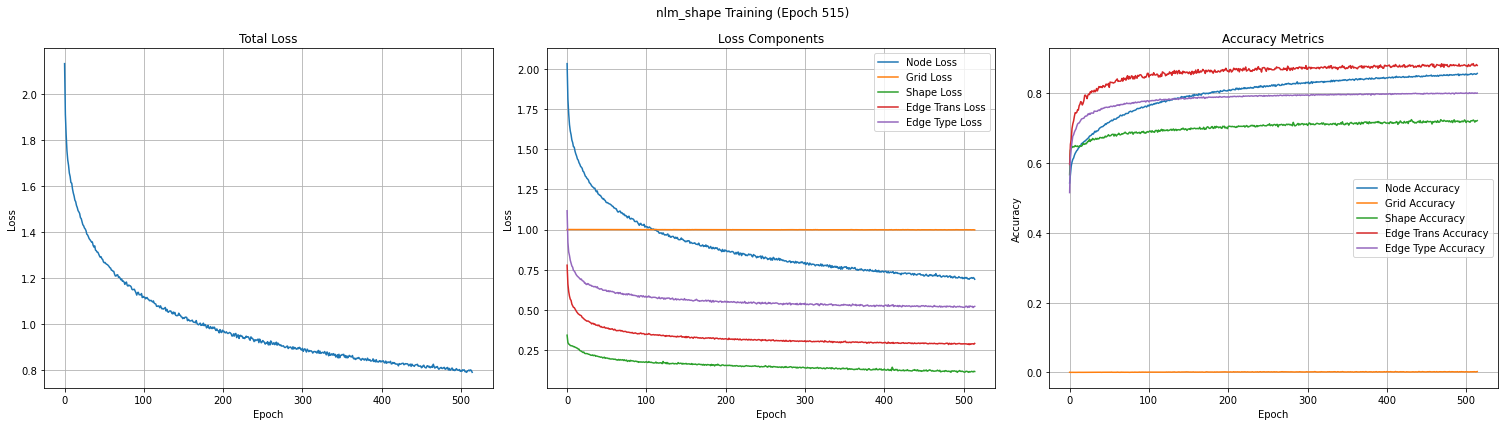

Epoch 516/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.82it/s]


Epoch 516/1000 - Loss: 0.7979 (Node: 0.6981, EdgeTrans: 0.2879, EdgeType: 0.5195, Grid: 0.9982, Shape: 0.1162), Node Acc: 0.8552, Grid Acc: 0.0018, Shape Acc: 0.721354, EdgeTrans Acc: 0.8852, EdgeType Acc: 0.8014


Epoch 517/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.81it/s]


Epoch 517/1000 - Loss: 0.7978 (Node: 0.6980, EdgeTrans: 0.2900, EdgeType: 0.5201, Grid: 0.9980, Shape: 0.1137), Node Acc: 0.8569, Grid Acc: 0.0020, Shape Acc: 0.721936, EdgeTrans Acc: 0.8817, EdgeType Acc: 0.7995


Epoch 518/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.71it/s]


Epoch 518/1000 - Loss: 0.8048 (Node: 0.7049, EdgeTrans: 0.2906, EdgeType: 0.5268, Grid: 0.9983, Shape: 0.1217), Node Acc: 0.8547, Grid Acc: 0.0017, Shape Acc: 0.720938, EdgeTrans Acc: 0.8787, EdgeType Acc: 0.7988


Epoch 519/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.76it/s]


Epoch 519/1000 - Loss: 0.7988 (Node: 0.6989, EdgeTrans: 0.2884, EdgeType: 0.5202, Grid: 0.9983, Shape: 0.1190), Node Acc: 0.8554, Grid Acc: 0.0017, Shape Acc: 0.720356, EdgeTrans Acc: 0.8856, EdgeType Acc: 0.8012


Epoch 520/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.69it/s]


Epoch 520/1000 - Loss: 0.7961 (Node: 0.6962, EdgeTrans: 0.2892, EdgeType: 0.5198, Grid: 0.9983, Shape: 0.1150), Node Acc: 0.8563, Grid Acc: 0.0017, Shape Acc: 0.721187, EdgeTrans Acc: 0.8810, EdgeType Acc: 0.8018
Model state saved to output/models/nlm_shape/nlm_shape_epoch_520.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_520.pt


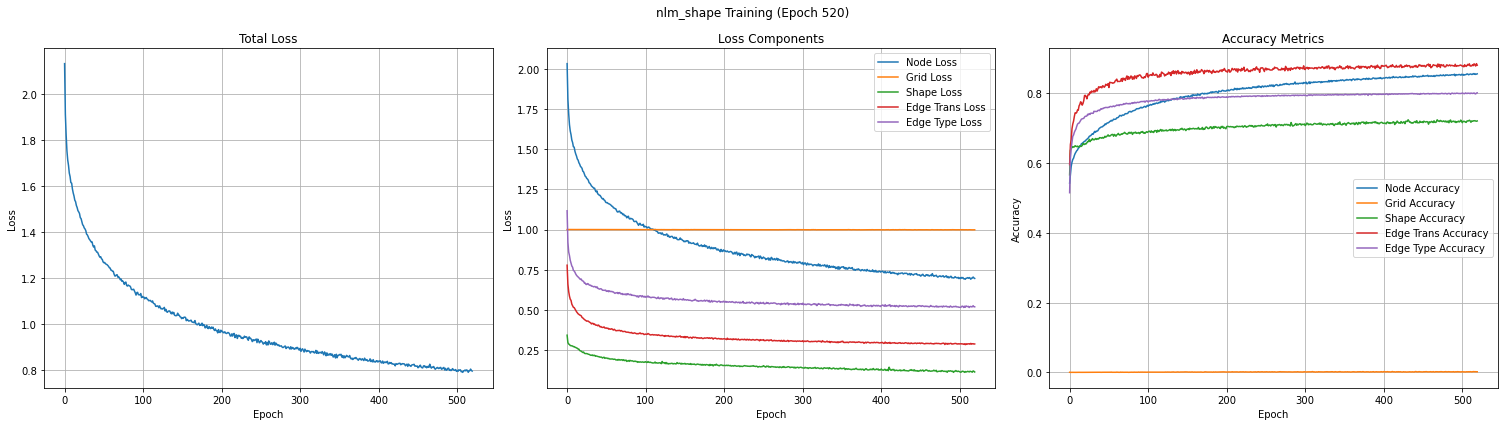

Epoch 521/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.78it/s]


Epoch 521/1000 - Loss: 0.7877 (Node: 0.6879, EdgeTrans: 0.2878, EdgeType: 0.5154, Grid: 0.9980, Shape: 0.1129), Node Acc: 0.8574, Grid Acc: 0.0020, Shape Acc: 0.724763, EdgeTrans Acc: 0.8818, EdgeType Acc: 0.8004


Epoch 522/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.79it/s]


Epoch 522/1000 - Loss: 0.7937 (Node: 0.6939, EdgeTrans: 0.2912, EdgeType: 0.5161, Grid: 0.9981, Shape: 0.1152), Node Acc: 0.8568, Grid Acc: 0.0019, Shape Acc: 0.723183, EdgeTrans Acc: 0.8846, EdgeType Acc: 0.8019


Epoch 523/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 523/1000 - Loss: 0.7997 (Node: 0.6999, EdgeTrans: 0.2881, EdgeType: 0.5170, Grid: 0.9981, Shape: 0.1173), Node Acc: 0.8529, Grid Acc: 0.0019, Shape Acc: 0.721936, EdgeTrans Acc: 0.8797, EdgeType Acc: 0.8007


Epoch 524/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.79it/s]


Epoch 524/1000 - Loss: 0.7943 (Node: 0.6945, EdgeTrans: 0.2862, EdgeType: 0.5173, Grid: 0.9983, Shape: 0.1127), Node Acc: 0.8559, Grid Acc: 0.0017, Shape Acc: 0.722934, EdgeTrans Acc: 0.8807, EdgeType Acc: 0.8008


Epoch 525/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.79it/s]


Epoch 525/1000 - Loss: 0.7952 (Node: 0.6954, EdgeTrans: 0.2861, EdgeType: 0.5236, Grid: 0.9977, Shape: 0.1203), Node Acc: 0.8554, Grid Acc: 0.0023, Shape Acc: 0.721187, EdgeTrans Acc: 0.8849, EdgeType Acc: 0.8007
Model state saved to output/models/nlm_shape/nlm_shape_epoch_525.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_525.pt


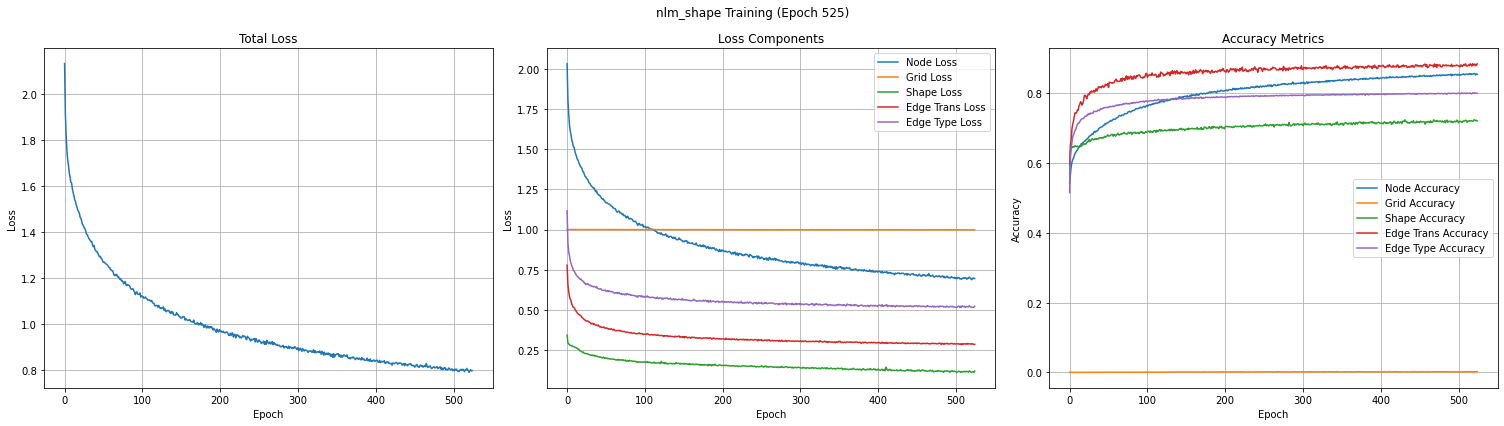

Epoch 526/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.84it/s]


Epoch 526/1000 - Loss: 0.7960 (Node: 0.6962, EdgeTrans: 0.2881, EdgeType: 0.5217, Grid: 0.9983, Shape: 0.1142), Node Acc: 0.8564, Grid Acc: 0.0017, Shape Acc: 0.721769, EdgeTrans Acc: 0.8843, EdgeType Acc: 0.8009


Epoch 527/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 527/1000 - Loss: 0.7927 (Node: 0.6928, EdgeTrans: 0.2890, EdgeType: 0.5187, Grid: 0.9984, Shape: 0.1166), Node Acc: 0.8562, Grid Acc: 0.0016, Shape Acc: 0.719358, EdgeTrans Acc: 0.8805, EdgeType Acc: 0.8010


Epoch 528/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.79it/s]


Epoch 528/1000 - Loss: 0.7909 (Node: 0.6911, EdgeTrans: 0.2875, EdgeType: 0.5173, Grid: 0.9984, Shape: 0.1194), Node Acc: 0.8562, Grid Acc: 0.0016, Shape Acc: 0.721853, EdgeTrans Acc: 0.8818, EdgeType Acc: 0.8003


Epoch 529/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.78it/s]


Epoch 529/1000 - Loss: 0.7928 (Node: 0.6930, EdgeTrans: 0.2909, EdgeType: 0.5216, Grid: 0.9983, Shape: 0.1146), Node Acc: 0.8567, Grid Acc: 0.0017, Shape Acc: 0.721520, EdgeTrans Acc: 0.8770, EdgeType Acc: 0.8010


Epoch 530/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.73it/s]


Epoch 530/1000 - Loss: 0.7937 (Node: 0.6938, EdgeTrans: 0.2890, EdgeType: 0.5208, Grid: 0.9989, Shape: 0.1134), Node Acc: 0.8561, Grid Acc: 0.0011, Shape Acc: 0.718111, EdgeTrans Acc: 0.8834, EdgeType Acc: 0.8011
Model state saved to output/models/nlm_shape/nlm_shape_epoch_530.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_530.pt


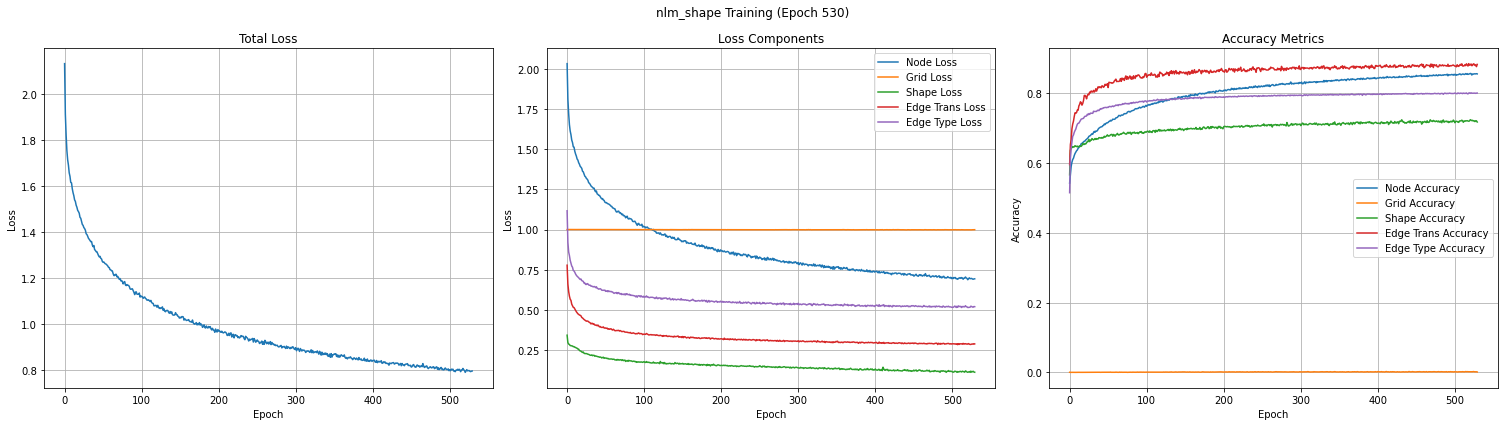

Epoch 531/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 531/1000 - Loss: 0.7923 (Node: 0.6924, EdgeTrans: 0.2871, EdgeType: 0.5173, Grid: 0.9988, Shape: 0.1170), Node Acc: 0.8558, Grid Acc: 0.0012, Shape Acc: 0.722019, EdgeTrans Acc: 0.8793, EdgeType Acc: 0.8010


Epoch 532/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 532/1000 - Loss: 0.7903 (Node: 0.6904, EdgeTrans: 0.2861, EdgeType: 0.5214, Grid: 0.9991, Shape: 0.1169), Node Acc: 0.8566, Grid Acc: 0.0009, Shape Acc: 0.724347, EdgeTrans Acc: 0.8794, EdgeType Acc: 0.8000


Epoch 533/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.77it/s]


Epoch 533/1000 - Loss: 0.7863 (Node: 0.6864, EdgeTrans: 0.2862, EdgeType: 0.5197, Grid: 0.9985, Shape: 0.1138), Node Acc: 0.8580, Grid Acc: 0.0015, Shape Acc: 0.719940, EdgeTrans Acc: 0.8810, EdgeType Acc: 0.8003


Epoch 534/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.73it/s]


Epoch 534/1000 - Loss: 0.7881 (Node: 0.6882, EdgeTrans: 0.2865, EdgeType: 0.5130, Grid: 0.9989, Shape: 0.1173), Node Acc: 0.8563, Grid Acc: 0.0011, Shape Acc: 0.724015, EdgeTrans Acc: 0.8823, EdgeType Acc: 0.8019


Epoch 535/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.73it/s]


Epoch 535/1000 - Loss: 0.7918 (Node: 0.6919, EdgeTrans: 0.2880, EdgeType: 0.5169, Grid: 0.9989, Shape: 0.1115), Node Acc: 0.8565, Grid Acc: 0.0011, Shape Acc: 0.717446, EdgeTrans Acc: 0.8785, EdgeType Acc: 0.8003
Model state saved to output/models/nlm_shape/nlm_shape_epoch_535.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_535.pt


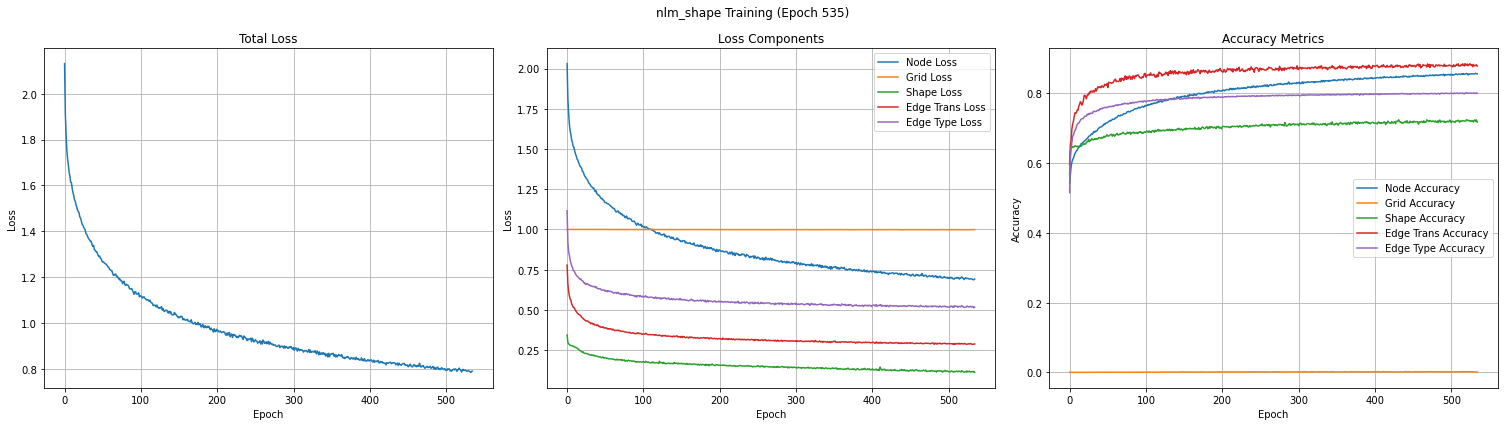

Epoch 536/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 536/1000 - Loss: 0.7876 (Node: 0.6878, EdgeTrans: 0.2866, EdgeType: 0.5171, Grid: 0.9984, Shape: 0.1129), Node Acc: 0.8570, Grid Acc: 0.0016, Shape Acc: 0.723599, EdgeTrans Acc: 0.8824, EdgeType Acc: 0.8010


Epoch 537/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 537/1000 - Loss: 0.7906 (Node: 0.6908, EdgeTrans: 0.2884, EdgeType: 0.5191, Grid: 0.9982, Shape: 0.1175), Node Acc: 0.8573, Grid Acc: 0.0018, Shape Acc: 0.722435, EdgeTrans Acc: 0.8794, EdgeType Acc: 0.8000


Epoch 538/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 538/1000 - Loss: 0.7819 (Node: 0.6821, EdgeTrans: 0.2834, EdgeType: 0.5163, Grid: 0.9983, Shape: 0.1137), Node Acc: 0.8583, Grid Acc: 0.0017, Shape Acc: 0.723100, EdgeTrans Acc: 0.8823, EdgeType Acc: 0.8007


Epoch 539/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.77it/s]


Epoch 539/1000 - Loss: 0.7873 (Node: 0.6875, EdgeTrans: 0.2858, EdgeType: 0.5174, Grid: 0.9982, Shape: 0.1144), Node Acc: 0.8577, Grid Acc: 0.0018, Shape Acc: 0.723848, EdgeTrans Acc: 0.8846, EdgeType Acc: 0.8024


Epoch 540/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.76it/s]


Epoch 540/1000 - Loss: 0.7946 (Node: 0.6948, EdgeTrans: 0.2863, EdgeType: 0.5188, Grid: 0.9981, Shape: 0.1154), Node Acc: 0.8551, Grid Acc: 0.0019, Shape Acc: 0.723266, EdgeTrans Acc: 0.8791, EdgeType Acc: 0.8005
Model state saved to output/models/nlm_shape/nlm_shape_epoch_540.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_540.pt


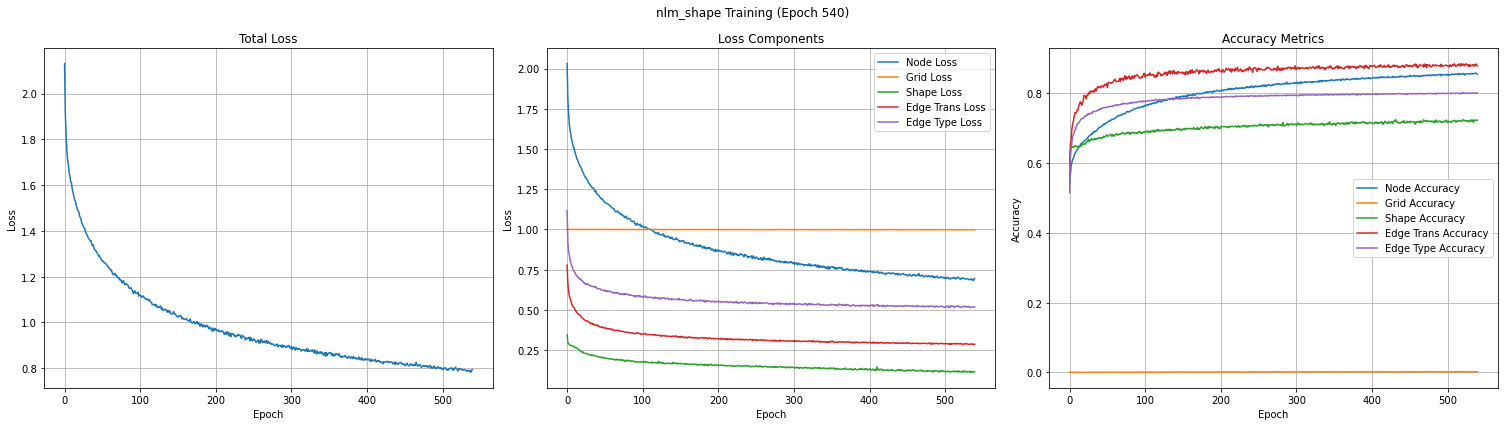

Epoch 541/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.82it/s]


Epoch 541/1000 - Loss: 0.7849 (Node: 0.6850, EdgeTrans: 0.2850, EdgeType: 0.5193, Grid: 0.9984, Shape: 0.1164), Node Acc: 0.8578, Grid Acc: 0.0016, Shape Acc: 0.718028, EdgeTrans Acc: 0.8834, EdgeType Acc: 0.8013


Epoch 542/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.78it/s]


Epoch 542/1000 - Loss: 0.7933 (Node: 0.6934, EdgeTrans: 0.2893, EdgeType: 0.5208, Grid: 0.9983, Shape: 0.1125), Node Acc: 0.8569, Grid Acc: 0.0017, Shape Acc: 0.721936, EdgeTrans Acc: 0.8803, EdgeType Acc: 0.7997


Epoch 543/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.81it/s]


Epoch 543/1000 - Loss: 0.7909 (Node: 0.6911, EdgeTrans: 0.2883, EdgeType: 0.5164, Grid: 0.9983, Shape: 0.1143), Node Acc: 0.8572, Grid Acc: 0.0017, Shape Acc: 0.723931, EdgeTrans Acc: 0.8767, EdgeType Acc: 0.8011


Epoch 544/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.81it/s]


Epoch 544/1000 - Loss: 0.7872 (Node: 0.6874, EdgeTrans: 0.2876, EdgeType: 0.5152, Grid: 0.9983, Shape: 0.1200), Node Acc: 0.8573, Grid Acc: 0.0017, Shape Acc: 0.723599, EdgeTrans Acc: 0.8842, EdgeType Acc: 0.8012


Epoch 545/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.75it/s]


Epoch 545/1000 - Loss: 0.7846 (Node: 0.6848, EdgeTrans: 0.2846, EdgeType: 0.5192, Grid: 0.9984, Shape: 0.1119), Node Acc: 0.8577, Grid Acc: 0.0016, Shape Acc: 0.725345, EdgeTrans Acc: 0.8885, EdgeType Acc: 0.8008
Model state saved to output/models/nlm_shape/nlm_shape_epoch_545.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_545.pt


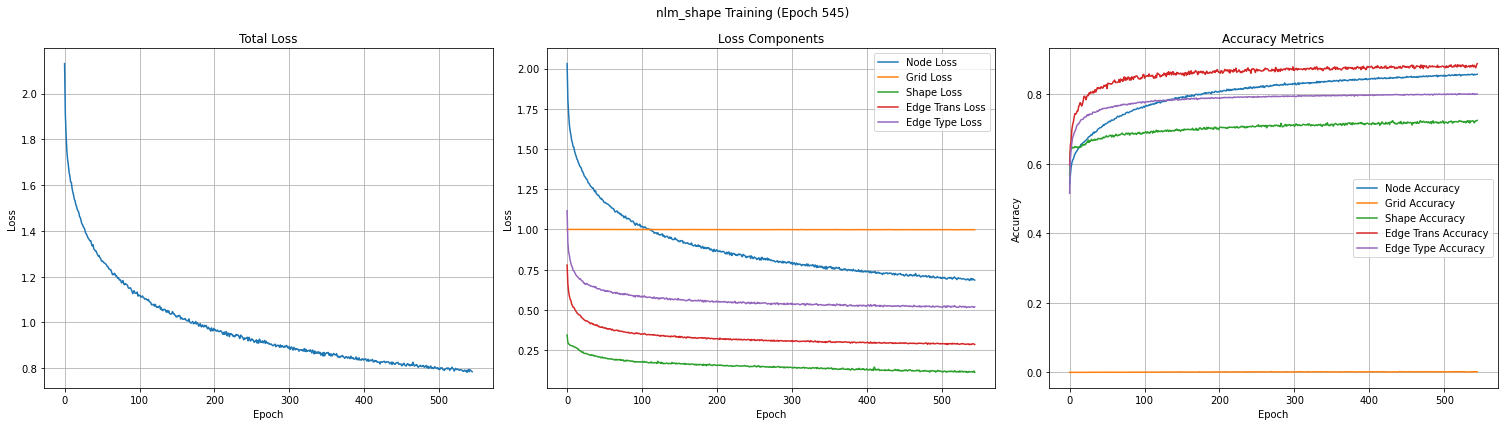

Epoch 546/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.77it/s]


Epoch 546/1000 - Loss: 0.7887 (Node: 0.6889, EdgeTrans: 0.2880, EdgeType: 0.5156, Grid: 0.9983, Shape: 0.1135), Node Acc: 0.8580, Grid Acc: 0.0017, Shape Acc: 0.721853, EdgeTrans Acc: 0.8805, EdgeType Acc: 0.8022


Epoch 547/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 547/1000 - Loss: 0.7879 (Node: 0.6881, EdgeTrans: 0.2863, EdgeType: 0.5157, Grid: 0.9980, Shape: 0.1085), Node Acc: 0.8571, Grid Acc: 0.0020, Shape Acc: 0.721187, EdgeTrans Acc: 0.8863, EdgeType Acc: 0.8007


Epoch 548/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 548/1000 - Loss: 0.7829 (Node: 0.6830, EdgeTrans: 0.2840, EdgeType: 0.5145, Grid: 0.9985, Shape: 0.1111), Node Acc: 0.8590, Grid Acc: 0.0015, Shape Acc: 0.722518, EdgeTrans Acc: 0.8764, EdgeType Acc: 0.8013


Epoch 549/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.79it/s]


Epoch 549/1000 - Loss: 0.7907 (Node: 0.6909, EdgeTrans: 0.2869, EdgeType: 0.5125, Grid: 0.9983, Shape: 0.1160), Node Acc: 0.8564, Grid Acc: 0.0017, Shape Acc: 0.720190, EdgeTrans Acc: 0.8770, EdgeType Acc: 0.8003


Epoch 550/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.76it/s]


Epoch 550/1000 - Loss: 0.7865 (Node: 0.6866, EdgeTrans: 0.2864, EdgeType: 0.5146, Grid: 0.9983, Shape: 0.1111), Node Acc: 0.8581, Grid Acc: 0.0017, Shape Acc: 0.723682, EdgeTrans Acc: 0.8796, EdgeType Acc: 0.8007
Model state saved to output/models/nlm_shape/nlm_shape_epoch_550.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_550.pt


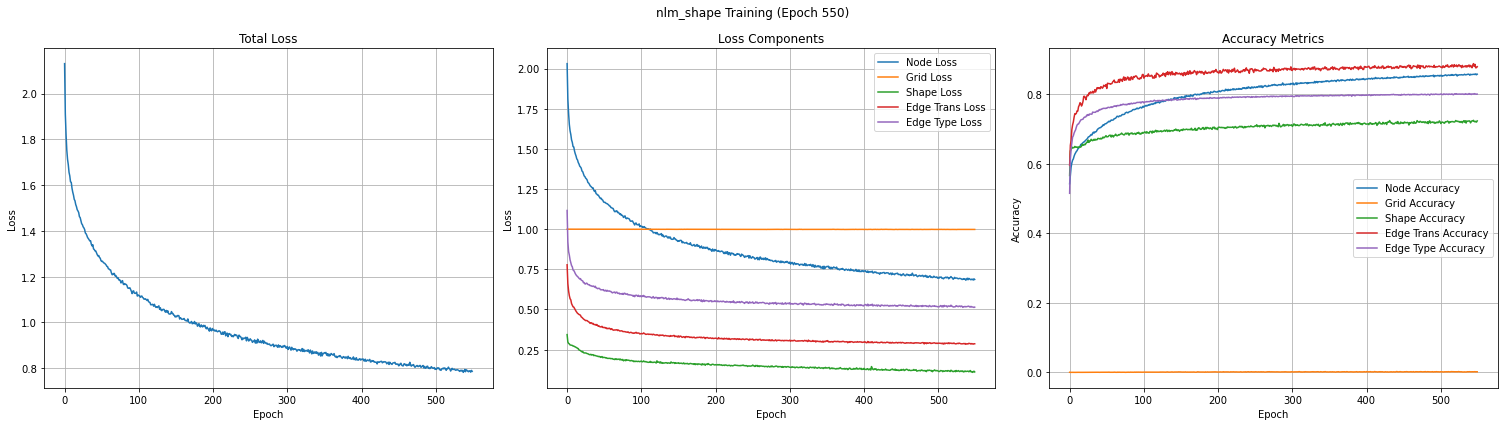

Epoch 551/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.78it/s]


Epoch 551/1000 - Loss: 0.7864 (Node: 0.6865, EdgeTrans: 0.2882, EdgeType: 0.5178, Grid: 0.9986, Shape: 0.1144), Node Acc: 0.8579, Grid Acc: 0.0014, Shape Acc: 0.722767, EdgeTrans Acc: 0.8849, EdgeType Acc: 0.8005


Epoch 552/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.78it/s]


Epoch 552/1000 - Loss: 0.7870 (Node: 0.6872, EdgeTrans: 0.2857, EdgeType: 0.5141, Grid: 0.9986, Shape: 0.1136), Node Acc: 0.8581, Grid Acc: 0.0014, Shape Acc: 0.723349, EdgeTrans Acc: 0.8857, EdgeType Acc: 0.8018


Epoch 553/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.89it/s]


Epoch 553/1000 - Loss: 0.7845 (Node: 0.6846, EdgeTrans: 0.2871, EdgeType: 0.5184, Grid: 0.9987, Shape: 0.1143), Node Acc: 0.8575, Grid Acc: 0.0013, Shape Acc: 0.720855, EdgeTrans Acc: 0.8769, EdgeType Acc: 0.8008


Epoch 554/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.95it/s]


Epoch 554/1000 - Loss: 0.7843 (Node: 0.6845, EdgeTrans: 0.2864, EdgeType: 0.5206, Grid: 0.9982, Shape: 0.1180), Node Acc: 0.8603, Grid Acc: 0.0018, Shape Acc: 0.724264, EdgeTrans Acc: 0.8812, EdgeType Acc: 0.8011


Epoch 556/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.84it/s]


Epoch 556/1000 - Loss: 0.7836 (Node: 0.6838, EdgeTrans: 0.2885, EdgeType: 0.5174, Grid: 0.9983, Shape: 0.1122), Node Acc: 0.8577, Grid Acc: 0.0017, Shape Acc: 0.721021, EdgeTrans Acc: 0.8810, EdgeType Acc: 0.8006


Epoch 557/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.87it/s]


Epoch 557/1000 - Loss: 0.7873 (Node: 0.6875, EdgeTrans: 0.2894, EdgeType: 0.5216, Grid: 0.9985, Shape: 0.1123), Node Acc: 0.8590, Grid Acc: 0.0015, Shape Acc: 0.722934, EdgeTrans Acc: 0.8800, EdgeType Acc: 0.8017


Epoch 558/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.89it/s]


Epoch 558/1000 - Loss: 0.7837 (Node: 0.6839, EdgeTrans: 0.2855, EdgeType: 0.5188, Grid: 0.9980, Shape: 0.1100), Node Acc: 0.8577, Grid Acc: 0.0020, Shape Acc: 0.724597, EdgeTrans Acc: 0.8824, EdgeType Acc: 0.8016


Epoch 559/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.85it/s]


Epoch 559/1000 - Loss: 0.7851 (Node: 0.6853, EdgeTrans: 0.2838, EdgeType: 0.5174, Grid: 0.9986, Shape: 0.1136), Node Acc: 0.8566, Grid Acc: 0.0014, Shape Acc: 0.720522, EdgeTrans Acc: 0.8772, EdgeType Acc: 0.8021


Epoch 560/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.84it/s]


Epoch 560/1000 - Loss: 0.7818 (Node: 0.6819, EdgeTrans: 0.2858, EdgeType: 0.5160, Grid: 0.9984, Shape: 0.1120), Node Acc: 0.8604, Grid Acc: 0.0016, Shape Acc: 0.722518, EdgeTrans Acc: 0.8865, EdgeType Acc: 0.8014
Model state saved to output/models/nlm_shape/nlm_shape_epoch_560.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_560.pt


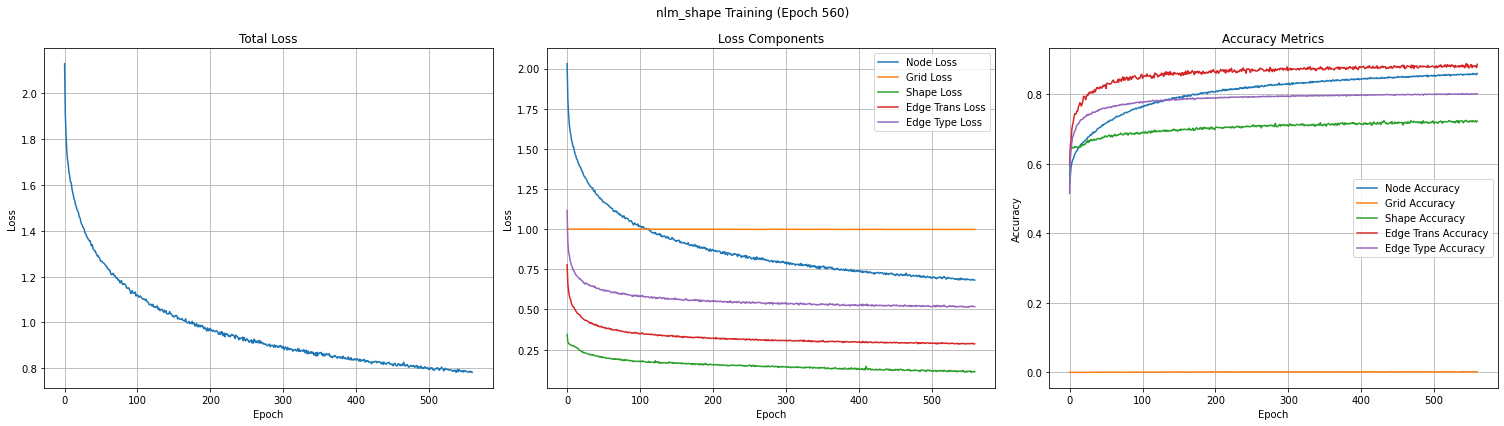

Epoch 561/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.88it/s]


Epoch 561/1000 - Loss: 0.7804 (Node: 0.6807, EdgeTrans: 0.2877, EdgeType: 0.5179, Grid: 0.9979, Shape: 0.1141), Node Acc: 0.8595, Grid Acc: 0.0021, Shape Acc: 0.718776, EdgeTrans Acc: 0.8791, EdgeType Acc: 0.8020


IOPub message rate exceeded.   | 165/1504 [00:07<00:57, 23.15it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 812/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.80it/s]


Epoch 812/1000 - Loss: 0.7317 (Node: 0.6319, EdgeTrans: 0.2736, EdgeType: 0.5016, Grid: 0.9979, Shape: 0.1011), Node Acc: 0.8715, Grid Acc: 0.0021, Shape Acc: 0.732496, EdgeTrans Acc: 0.8844, EdgeType Acc: 0.8042


Epoch 813/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.73it/s]


Epoch 813/1000 - Loss: 0.7369 (Node: 0.6371, EdgeTrans: 0.2771, EdgeType: 0.5098, Grid: 0.9981, Shape: 0.1011), Node Acc: 0.8712, Grid Acc: 0.0019, Shape Acc: 0.732579, EdgeTrans Acc: 0.8906, EdgeType Acc: 0.8043


Epoch 814/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.83it/s]


Epoch 814/1000 - Loss: 0.7327 (Node: 0.6329, EdgeTrans: 0.2765, EdgeType: 0.5067, Grid: 0.9979, Shape: 0.0985), Node Acc: 0.8713, Grid Acc: 0.0021, Shape Acc: 0.730833, EdgeTrans Acc: 0.8912, EdgeType Acc: 0.8048


Epoch 815/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.72it/s]


Epoch 815/1000 - Loss: 0.7336 (Node: 0.6338, EdgeTrans: 0.2767, EdgeType: 0.5101, Grid: 0.9977, Shape: 0.1021), Node Acc: 0.8717, Grid Acc: 0.0023, Shape Acc: 0.734409, EdgeTrans Acc: 0.8869, EdgeType Acc: 0.8045
Model state saved to output/models/nlm_shape/nlm_shape_epoch_815.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_815.pt


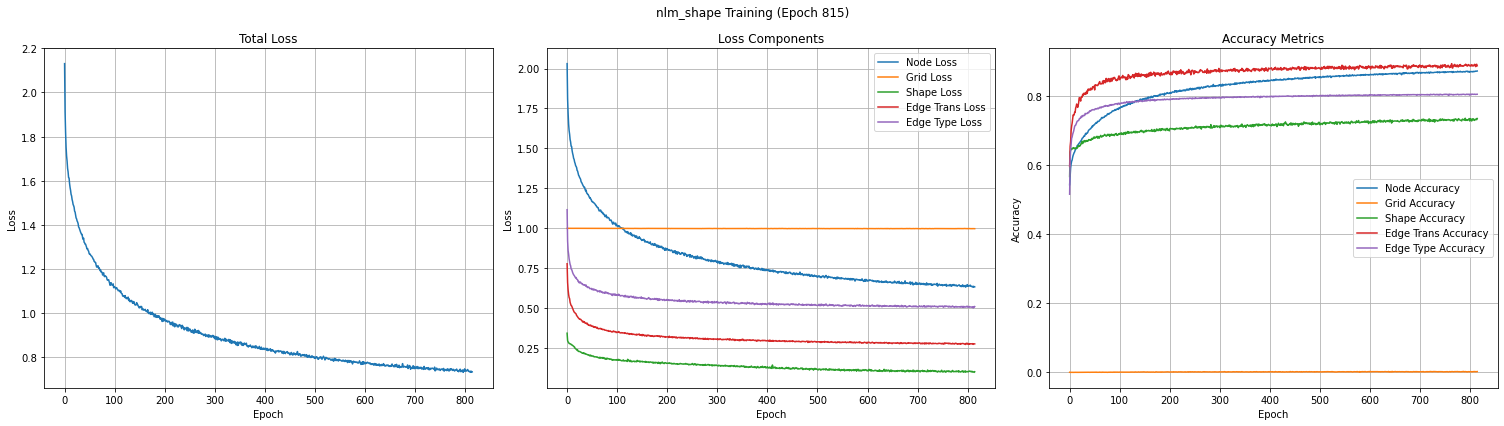

Epoch 816/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.77it/s]


Epoch 816/1000 - Loss: 0.7342 (Node: 0.6344, EdgeTrans: 0.2768, EdgeType: 0.5105, Grid: 0.9981, Shape: 0.1012), Node Acc: 0.8715, Grid Acc: 0.0019, Shape Acc: 0.730916, EdgeTrans Acc: 0.8847, EdgeType Acc: 0.8039


Epoch 817/1000: 100%|██████████| 1504/1504 [01:08<00:00, 21.83it/s]


Epoch 817/1000 - Loss: 0.7380 (Node: 0.6382, EdgeTrans: 0.2794, EdgeType: 0.5113, Grid: 0.9978, Shape: 0.1028), Node Acc: 0.8716, Grid Acc: 0.0022, Shape Acc: 0.729336, EdgeTrans Acc: 0.8916, EdgeType Acc: 0.8047


IOPub message rate exceeded.▏  | 1088/1504 [00:50<00:20, 20.56it/s]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 950/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.21it/s]


Epoch 950/1000 - Loss: 0.7278 (Node: 0.6279, EdgeTrans: 0.2762, EdgeType: 0.5108, Grid: 0.9983, Shape: 0.1029), Node Acc: 0.8740, Grid Acc: 0.0017, Shape Acc: 0.733993, EdgeTrans Acc: 0.8895, EdgeType Acc: 0.8046
Model state saved to output/models/nlm_shape/nlm_shape_epoch_950.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_950.pt


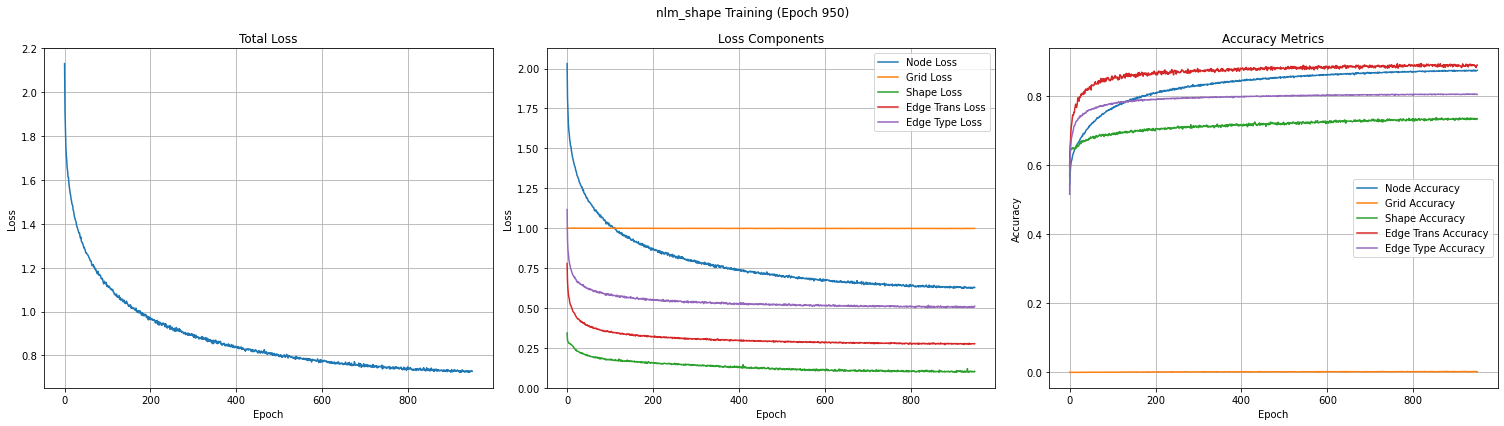

Epoch 951/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.31it/s]


Epoch 951/1000 - Loss: 0.7292 (Node: 0.6294, EdgeTrans: 0.2757, EdgeType: 0.5072, Grid: 0.9981, Shape: 0.1007), Node Acc: 0.8739, Grid Acc: 0.0019, Shape Acc: 0.731665, EdgeTrans Acc: 0.8884, EdgeType Acc: 0.8039


Epoch 952/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.24it/s]


Epoch 952/1000 - Loss: 0.7347 (Node: 0.6348, EdgeTrans: 0.2764, EdgeType: 0.5096, Grid: 0.9985, Shape: 0.0987), Node Acc: 0.8727, Grid Acc: 0.0015, Shape Acc: 0.732330, EdgeTrans Acc: 0.8917, EdgeType Acc: 0.8041


Epoch 953/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.27it/s]


Epoch 953/1000 - Loss: 0.7290 (Node: 0.6292, EdgeTrans: 0.2741, EdgeType: 0.5066, Grid: 0.9981, Shape: 0.1005), Node Acc: 0.8732, Grid Acc: 0.0019, Shape Acc: 0.735074, EdgeTrans Acc: 0.8886, EdgeType Acc: 0.8049


Epoch 954/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.28it/s]


Epoch 954/1000 - Loss: 0.7261 (Node: 0.6263, EdgeTrans: 0.2748, EdgeType: 0.5068, Grid: 0.9975, Shape: 0.1018), Node Acc: 0.8738, Grid Acc: 0.0025, Shape Acc: 0.735157, EdgeTrans Acc: 0.8865, EdgeType Acc: 0.8047


Epoch 955/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.28it/s]


Epoch 955/1000 - Loss: 0.7187 (Node: 0.6189, EdgeTrans: 0.2712, EdgeType: 0.5030, Grid: 0.9981, Shape: 0.0989), Node Acc: 0.8729, Grid Acc: 0.0019, Shape Acc: 0.733161, EdgeTrans Acc: 0.8867, EdgeType Acc: 0.8045
Model state saved to output/models/nlm_shape/nlm_shape_epoch_955.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_955.pt


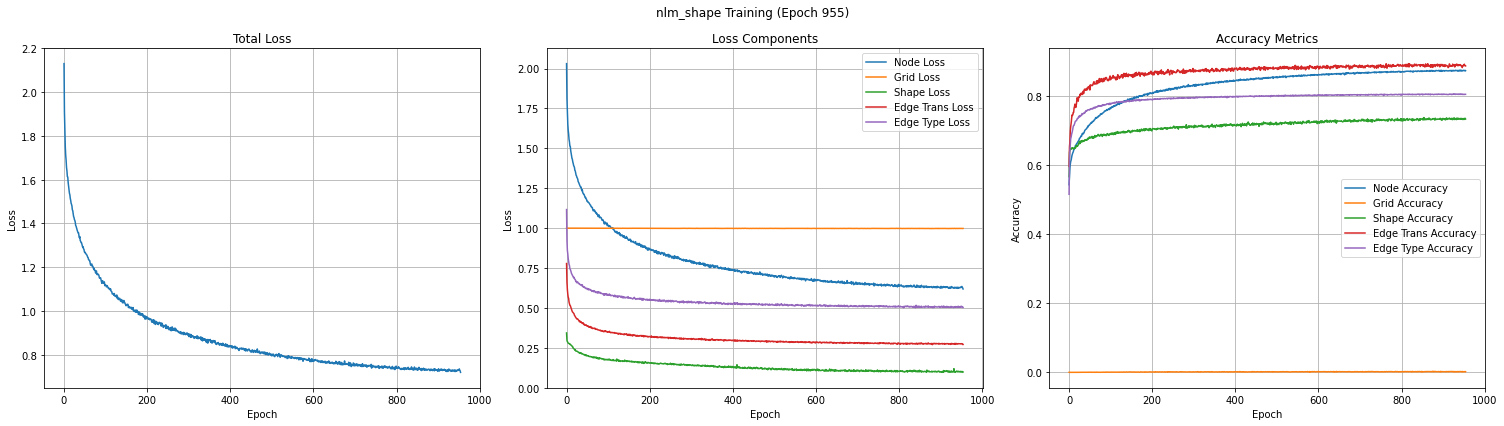

Epoch 956/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.29it/s]


Epoch 956/1000 - Loss: 0.7255 (Node: 0.6257, EdgeTrans: 0.2753, EdgeType: 0.5068, Grid: 0.9978, Shape: 0.1083), Node Acc: 0.8747, Grid Acc: 0.0022, Shape Acc: 0.732579, EdgeTrans Acc: 0.8922, EdgeType Acc: 0.8045


Epoch 957/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.25it/s]


Epoch 957/1000 - Loss: 0.7265 (Node: 0.6267, EdgeTrans: 0.2782, EdgeType: 0.5092, Grid: 0.9979, Shape: 0.0966), Node Acc: 0.8734, Grid Acc: 0.0021, Shape Acc: 0.732746, EdgeTrans Acc: 0.8907, EdgeType Acc: 0.8050


Epoch 958/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.29it/s]


Epoch 958/1000 - Loss: 0.7295 (Node: 0.6297, EdgeTrans: 0.2730, EdgeType: 0.5046, Grid: 0.9978, Shape: 0.1045), Node Acc: 0.8731, Grid Acc: 0.0022, Shape Acc: 0.732247, EdgeTrans Acc: 0.8891, EdgeType Acc: 0.8045


Epoch 959/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.28it/s]


Epoch 959/1000 - Loss: 0.7258 (Node: 0.6259, EdgeTrans: 0.2751, EdgeType: 0.5069, Grid: 0.9984, Shape: 0.1026), Node Acc: 0.8731, Grid Acc: 0.0016, Shape Acc: 0.733910, EdgeTrans Acc: 0.8916, EdgeType Acc: 0.8045


Epoch 960/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.27it/s]


Epoch 960/1000 - Loss: 0.7283 (Node: 0.6285, EdgeTrans: 0.2775, EdgeType: 0.5072, Grid: 0.9980, Shape: 0.1024), Node Acc: 0.8744, Grid Acc: 0.0020, Shape Acc: 0.733744, EdgeTrans Acc: 0.8876, EdgeType Acc: 0.8055
Model state saved to output/models/nlm_shape/nlm_shape_epoch_960.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_960.pt


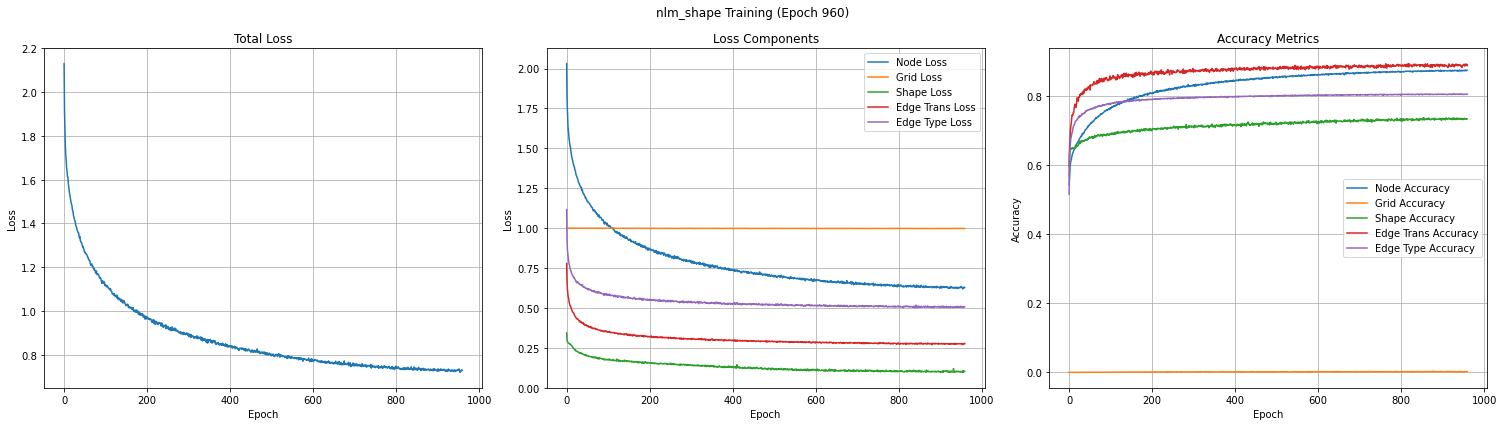

Epoch 961/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.31it/s]


Epoch 961/1000 - Loss: 0.7266 (Node: 0.6269, EdgeTrans: 0.2759, EdgeType: 0.5077, Grid: 0.9972, Shape: 0.1010), Node Acc: 0.8742, Grid Acc: 0.0028, Shape Acc: 0.736321, EdgeTrans Acc: 0.8905, EdgeType Acc: 0.8047


Epoch 962/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.35it/s]


Epoch 962/1000 - Loss: 0.7282 (Node: 0.6284, EdgeTrans: 0.2746, EdgeType: 0.5085, Grid: 0.9973, Shape: 0.1002), Node Acc: 0.8730, Grid Acc: 0.0027, Shape Acc: 0.734492, EdgeTrans Acc: 0.8906, EdgeType Acc: 0.8046


Epoch 963/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.33it/s]


Epoch 963/1000 - Loss: 0.7258 (Node: 0.6260, EdgeTrans: 0.2752, EdgeType: 0.5034, Grid: 0.9980, Shape: 0.0999), Node Acc: 0.8737, Grid Acc: 0.0020, Shape Acc: 0.734409, EdgeTrans Acc: 0.8926, EdgeType Acc: 0.8056


Epoch 964/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.25it/s]


Epoch 964/1000 - Loss: 0.7236 (Node: 0.6238, EdgeTrans: 0.2726, EdgeType: 0.5002, Grid: 0.9982, Shape: 0.0991), Node Acc: 0.8737, Grid Acc: 0.0018, Shape Acc: 0.732080, EdgeTrans Acc: 0.8849, EdgeType Acc: 0.8051


Epoch 965/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.23it/s]


Epoch 965/1000 - Loss: 0.7287 (Node: 0.6289, EdgeTrans: 0.2777, EdgeType: 0.5047, Grid: 0.9980, Shape: 0.1019), Node Acc: 0.8742, Grid Acc: 0.0020, Shape Acc: 0.734159, EdgeTrans Acc: 0.8876, EdgeType Acc: 0.8042
Model state saved to output/models/nlm_shape/nlm_shape_epoch_965.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_965.pt


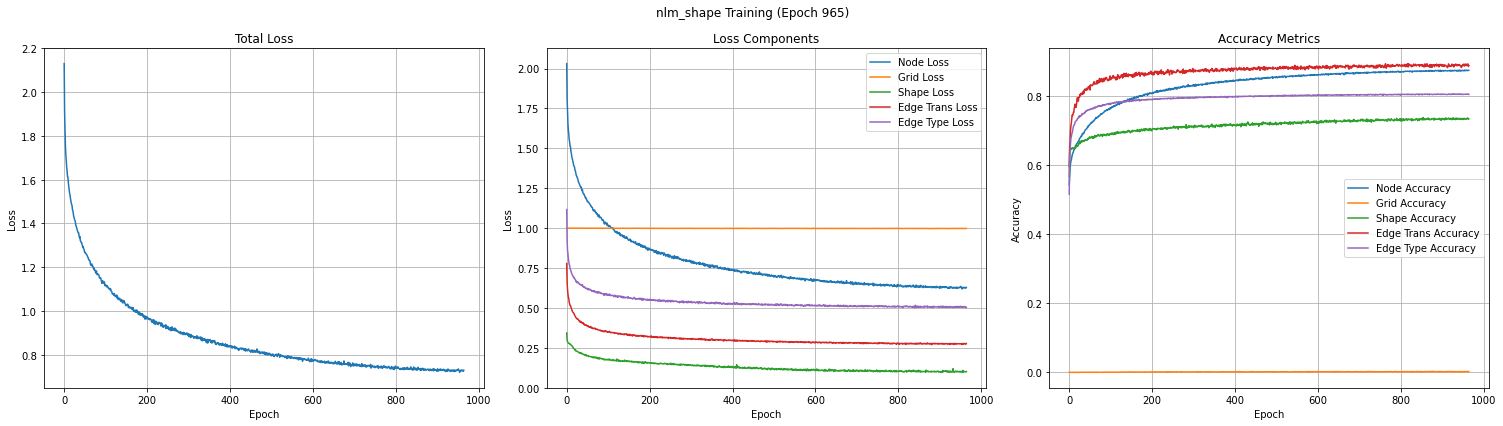

Epoch 966/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.40it/s]


Epoch 966/1000 - Loss: 0.7325 (Node: 0.6327, EdgeTrans: 0.2765, EdgeType: 0.5075, Grid: 0.9978, Shape: 0.1028), Node Acc: 0.8748, Grid Acc: 0.0022, Shape Acc: 0.732829, EdgeTrans Acc: 0.8850, EdgeType Acc: 0.8053


Epoch 967/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.33it/s]


Epoch 967/1000 - Loss: 0.7238 (Node: 0.6240, EdgeTrans: 0.2738, EdgeType: 0.5071, Grid: 0.9979, Shape: 0.1025), Node Acc: 0.8745, Grid Acc: 0.0021, Shape Acc: 0.729170, EdgeTrans Acc: 0.8905, EdgeType Acc: 0.8050


Epoch 968/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.34it/s]


Epoch 968/1000 - Loss: 0.7336 (Node: 0.6337, EdgeTrans: 0.2751, EdgeType: 0.5048, Grid: 0.9982, Shape: 0.1025), Node Acc: 0.8729, Grid Acc: 0.0018, Shape Acc: 0.733660, EdgeTrans Acc: 0.8889, EdgeType Acc: 0.8049


Epoch 969/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.29it/s]


Epoch 969/1000 - Loss: 0.7262 (Node: 0.6264, EdgeTrans: 0.2745, EdgeType: 0.5072, Grid: 0.9979, Shape: 0.0968), Node Acc: 0.8729, Grid Acc: 0.0021, Shape Acc: 0.734575, EdgeTrans Acc: 0.8880, EdgeType Acc: 0.8045


Epoch 970/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.35it/s]


Epoch 970/1000 - Loss: 0.7259 (Node: 0.6262, EdgeTrans: 0.2743, EdgeType: 0.5047, Grid: 0.9978, Shape: 0.1028), Node Acc: 0.8744, Grid Acc: 0.0022, Shape Acc: 0.731582, EdgeTrans Acc: 0.8929, EdgeType Acc: 0.8049
Model state saved to output/models/nlm_shape/nlm_shape_epoch_970.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_970.pt


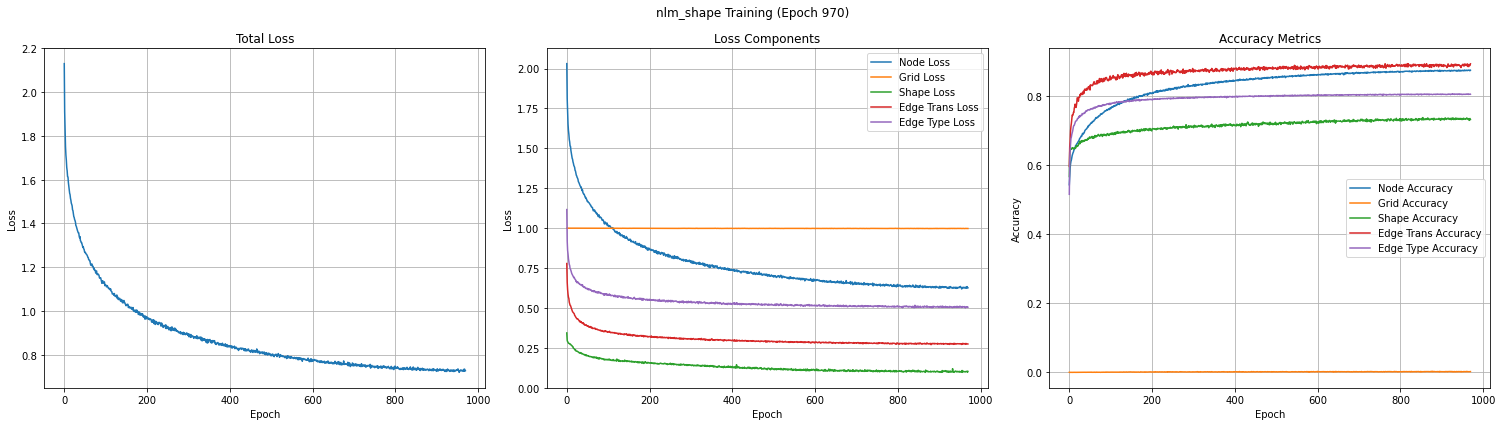

Epoch 971/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.36it/s]


Epoch 971/1000 - Loss: 0.7277 (Node: 0.6279, EdgeTrans: 0.2763, EdgeType: 0.5101, Grid: 0.9982, Shape: 0.1003), Node Acc: 0.8739, Grid Acc: 0.0018, Shape Acc: 0.730584, EdgeTrans Acc: 0.8897, EdgeType Acc: 0.8038


Epoch 972/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.40it/s]


Epoch 972/1000 - Loss: 0.7304 (Node: 0.6306, EdgeTrans: 0.2737, EdgeType: 0.5064, Grid: 0.9973, Shape: 0.1036), Node Acc: 0.8729, Grid Acc: 0.0027, Shape Acc: 0.731582, EdgeTrans Acc: 0.8855, EdgeType Acc: 0.8044


Epoch 973/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.47it/s]


Epoch 973/1000 - Loss: 0.7270 (Node: 0.6272, EdgeTrans: 0.2771, EdgeType: 0.5105, Grid: 0.9980, Shape: 0.1026), Node Acc: 0.8744, Grid Acc: 0.0020, Shape Acc: 0.732330, EdgeTrans Acc: 0.8899, EdgeType Acc: 0.8038


Epoch 974/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.46it/s]


Epoch 974/1000 - Loss: 0.7265 (Node: 0.6267, EdgeTrans: 0.2769, EdgeType: 0.5073, Grid: 0.9979, Shape: 0.1001), Node Acc: 0.8732, Grid Acc: 0.0021, Shape Acc: 0.731997, EdgeTrans Acc: 0.8898, EdgeType Acc: 0.8048


Epoch 975/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.47it/s]


Epoch 975/1000 - Loss: 0.7238 (Node: 0.6240, EdgeTrans: 0.2727, EdgeType: 0.5067, Grid: 0.9983, Shape: 0.0992), Node Acc: 0.8738, Grid Acc: 0.0017, Shape Acc: 0.733910, EdgeTrans Acc: 0.8898, EdgeType Acc: 0.8057
Model state saved to output/models/nlm_shape/nlm_shape_epoch_975.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_975.pt


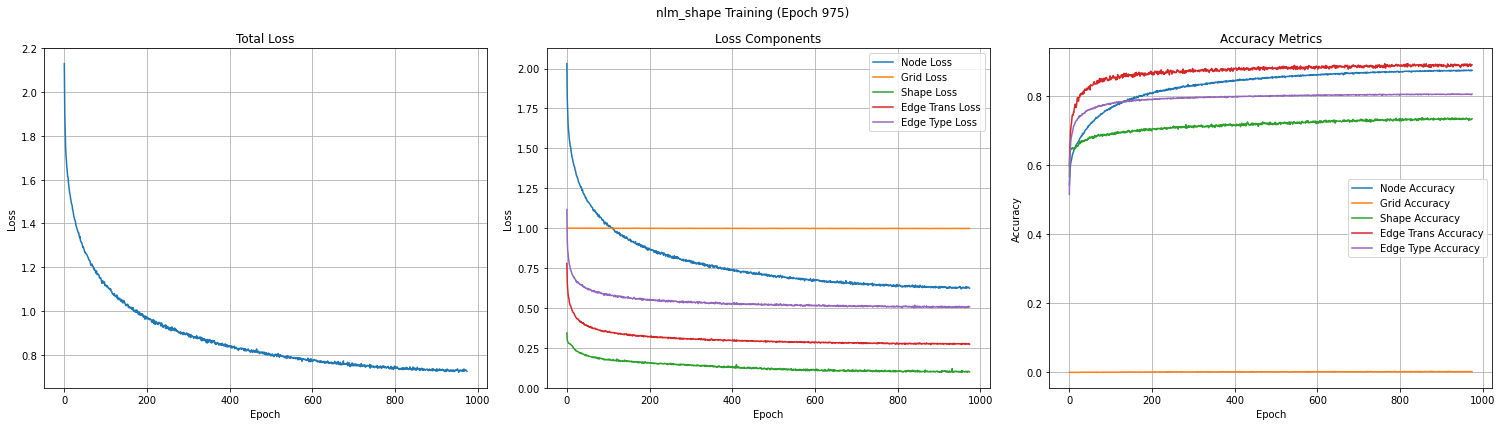

Epoch 976/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.48it/s]


Epoch 976/1000 - Loss: 0.7239 (Node: 0.6242, EdgeTrans: 0.2755, EdgeType: 0.5085, Grid: 0.9975, Shape: 0.1033), Node Acc: 0.8744, Grid Acc: 0.0025, Shape Acc: 0.732829, EdgeTrans Acc: 0.8882, EdgeType Acc: 0.8054


Epoch 977/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.57it/s]


Epoch 977/1000 - Loss: 0.7289 (Node: 0.6290, EdgeTrans: 0.2765, EdgeType: 0.5079, Grid: 0.9983, Shape: 0.1003), Node Acc: 0.8738, Grid Acc: 0.0017, Shape Acc: 0.735906, EdgeTrans Acc: 0.8880, EdgeType Acc: 0.8048


Epoch 978/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.52it/s]


Epoch 978/1000 - Loss: 0.7218 (Node: 0.6220, EdgeTrans: 0.2735, EdgeType: 0.5069, Grid: 0.9982, Shape: 0.1025), Node Acc: 0.8743, Grid Acc: 0.0018, Shape Acc: 0.732080, EdgeTrans Acc: 0.8945, EdgeType Acc: 0.8048


Epoch 979/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.48it/s]


Epoch 979/1000 - Loss: 0.7259 (Node: 0.6260, EdgeTrans: 0.2733, EdgeType: 0.5069, Grid: 0.9985, Shape: 0.0965), Node Acc: 0.8736, Grid Acc: 0.0015, Shape Acc: 0.735906, EdgeTrans Acc: 0.8916, EdgeType Acc: 0.8055


Epoch 980/1000: 100%|██████████| 1504/1504 [01:10<00:00, 21.47it/s]


Epoch 980/1000 - Loss: 0.7307 (Node: 0.6309, EdgeTrans: 0.2751, EdgeType: 0.5075, Grid: 0.9979, Shape: 0.0981), Node Acc: 0.8737, Grid Acc: 0.0021, Shape Acc: 0.734159, EdgeTrans Acc: 0.8921, EdgeType Acc: 0.8049
Model state saved to output/models/nlm_shape/nlm_shape_epoch_980.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_980.pt


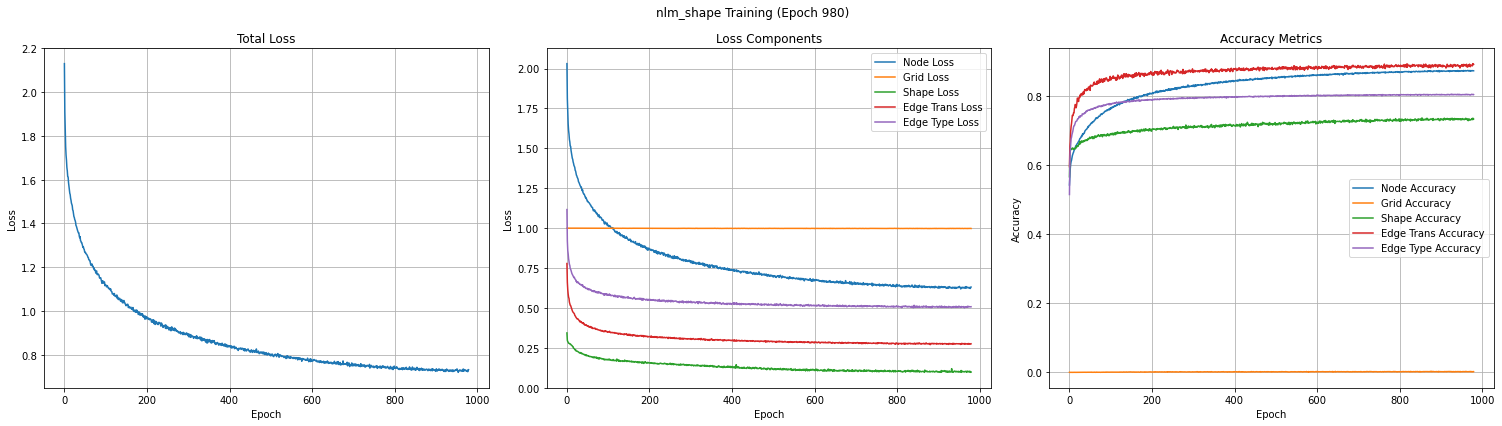

Epoch 981/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.59it/s]


Epoch 981/1000 - Loss: 0.7248 (Node: 0.6250, EdgeTrans: 0.2709, EdgeType: 0.5059, Grid: 0.9978, Shape: 0.0997), Node Acc: 0.8734, Grid Acc: 0.0022, Shape Acc: 0.734575, EdgeTrans Acc: 0.8867, EdgeType Acc: 0.8041


Epoch 982/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.60it/s]


Epoch 982/1000 - Loss: 0.7281 (Node: 0.6283, EdgeTrans: 0.2756, EdgeType: 0.5086, Grid: 0.9978, Shape: 0.0995), Node Acc: 0.8737, Grid Acc: 0.0022, Shape Acc: 0.732746, EdgeTrans Acc: 0.8880, EdgeType Acc: 0.8054


Epoch 983/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.60it/s]


Epoch 983/1000 - Loss: 0.7295 (Node: 0.6297, EdgeTrans: 0.2769, EdgeType: 0.5087, Grid: 0.9974, Shape: 0.1015), Node Acc: 0.8738, Grid Acc: 0.0023, Shape Acc: 0.732746, EdgeTrans Acc: 0.8893, EdgeType Acc: 0.8048


Epoch 984/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.59it/s]


Epoch 984/1000 - Loss: 0.7258 (Node: 0.6261, EdgeTrans: 0.2753, EdgeType: 0.5059, Grid: 0.9975, Shape: 0.0964), Node Acc: 0.8733, Grid Acc: 0.0025, Shape Acc: 0.732746, EdgeTrans Acc: 0.8856, EdgeType Acc: 0.8047


Epoch 985/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.60it/s]


Epoch 985/1000 - Loss: 0.7273 (Node: 0.6274, EdgeTrans: 0.2756, EdgeType: 0.5068, Grid: 0.9984, Shape: 0.1057), Node Acc: 0.8734, Grid Acc: 0.0016, Shape Acc: 0.733744, EdgeTrans Acc: 0.8890, EdgeType Acc: 0.8047
Model state saved to output/models/nlm_shape/nlm_shape_epoch_985.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_985.pt


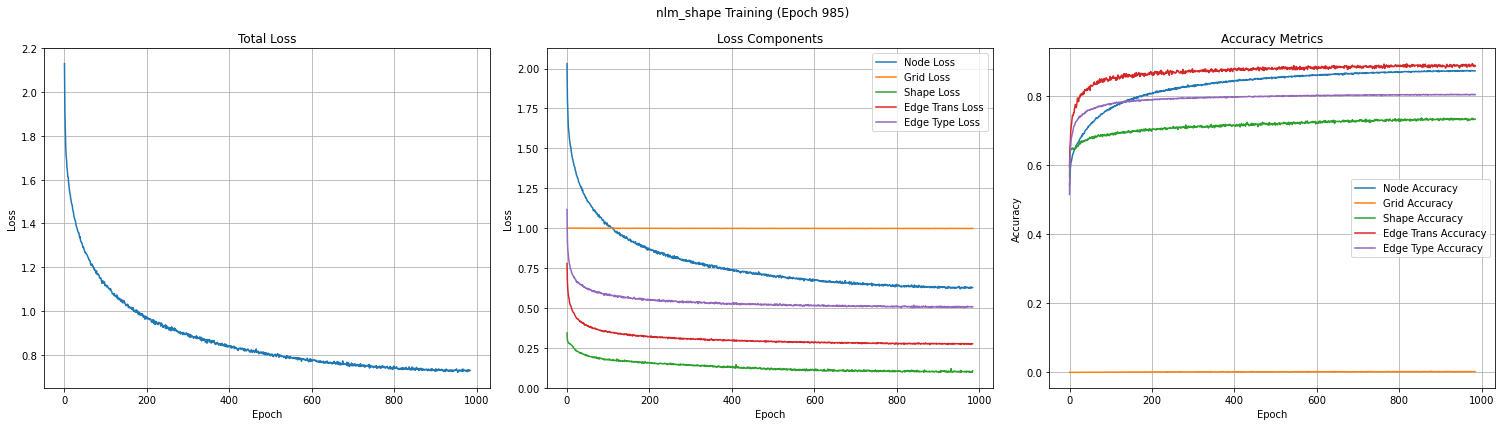

Epoch 986/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 986/1000 - Loss: 0.7234 (Node: 0.6236, EdgeTrans: 0.2774, EdgeType: 0.5052, Grid: 0.9981, Shape: 0.1003), Node Acc: 0.8736, Grid Acc: 0.0019, Shape Acc: 0.732912, EdgeTrans Acc: 0.8858, EdgeType Acc: 0.8043


Epoch 987/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.56it/s]


Epoch 987/1000 - Loss: 0.7265 (Node: 0.6266, EdgeTrans: 0.2761, EdgeType: 0.5062, Grid: 0.9981, Shape: 0.1051), Node Acc: 0.8734, Grid Acc: 0.0019, Shape Acc: 0.735739, EdgeTrans Acc: 0.8855, EdgeType Acc: 0.8043


Epoch 988/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.65it/s]


Epoch 988/1000 - Loss: 0.7244 (Node: 0.6246, EdgeTrans: 0.2748, EdgeType: 0.5081, Grid: 0.9978, Shape: 0.0993), Node Acc: 0.8734, Grid Acc: 0.0022, Shape Acc: 0.731000, EdgeTrans Acc: 0.8869, EdgeType Acc: 0.8048


Epoch 989/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 989/1000 - Loss: 0.7254 (Node: 0.6256, EdgeTrans: 0.2748, EdgeType: 0.5068, Grid: 0.9977, Shape: 0.1004), Node Acc: 0.8736, Grid Acc: 0.0023, Shape Acc: 0.734076, EdgeTrans Acc: 0.8876, EdgeType Acc: 0.8045


Epoch 990/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.74it/s]


Epoch 990/1000 - Loss: 0.7294 (Node: 0.6296, EdgeTrans: 0.2750, EdgeType: 0.5089, Grid: 0.9978, Shape: 0.1020), Node Acc: 0.8735, Grid Acc: 0.0022, Shape Acc: 0.735739, EdgeTrans Acc: 0.8882, EdgeType Acc: 0.8046
Model state saved to output/models/nlm_shape/nlm_shape_epoch_990.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_990.pt


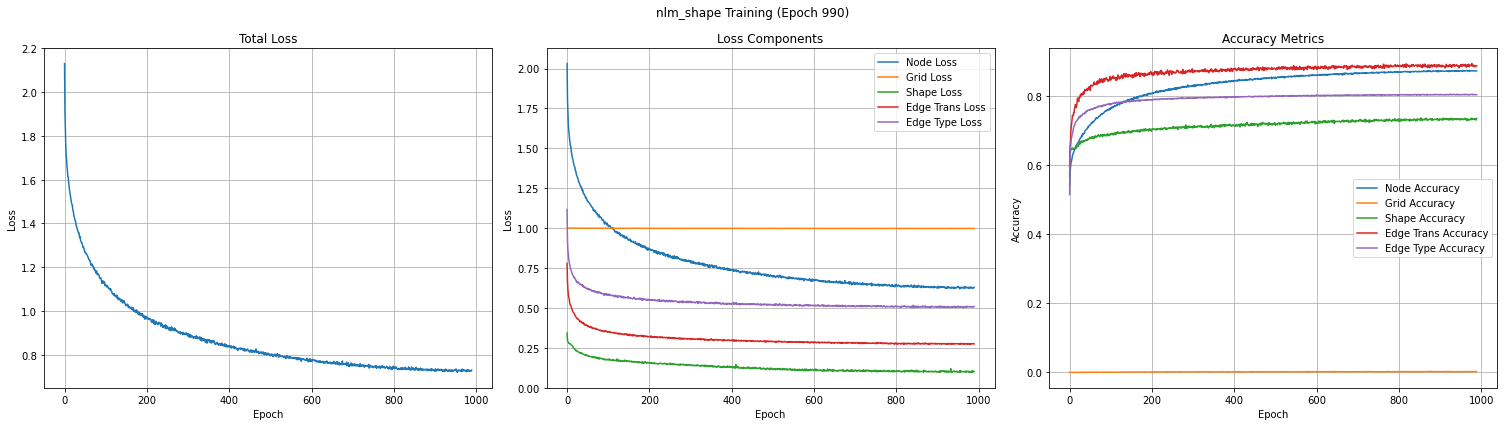

Epoch 991/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.74it/s]


Epoch 991/1000 - Loss: 0.7275 (Node: 0.6277, EdgeTrans: 0.2762, EdgeType: 0.5065, Grid: 0.9981, Shape: 0.1049), Node Acc: 0.8732, Grid Acc: 0.0019, Shape Acc: 0.731415, EdgeTrans Acc: 0.8860, EdgeType Acc: 0.8033


Epoch 992/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.67it/s]


Epoch 992/1000 - Loss: 0.7248 (Node: 0.6250, EdgeTrans: 0.2728, EdgeType: 0.5083, Grid: 0.9983, Shape: 0.1043), Node Acc: 0.8746, Grid Acc: 0.0017, Shape Acc: 0.733161, EdgeTrans Acc: 0.8898, EdgeType Acc: 0.8052


Epoch 993/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 993/1000 - Loss: 0.7344 (Node: 0.6346, EdgeTrans: 0.2765, EdgeType: 0.5056, Grid: 0.9976, Shape: 0.1006), Node Acc: 0.8716, Grid Acc: 0.0024, Shape Acc: 0.732164, EdgeTrans Acc: 0.8874, EdgeType Acc: 0.8043


Epoch 994/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.67it/s]


Epoch 994/1000 - Loss: 0.7251 (Node: 0.6253, EdgeTrans: 0.2742, EdgeType: 0.5073, Grid: 0.9981, Shape: 0.0993), Node Acc: 0.8734, Grid Acc: 0.0019, Shape Acc: 0.735573, EdgeTrans Acc: 0.8877, EdgeType Acc: 0.8054


Epoch 995/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.64it/s]


Epoch 995/1000 - Loss: 0.7292 (Node: 0.6294, EdgeTrans: 0.2734, EdgeType: 0.5096, Grid: 0.9983, Shape: 0.1034), Node Acc: 0.8726, Grid Acc: 0.0017, Shape Acc: 0.731498, EdgeTrans Acc: 0.8849, EdgeType Acc: 0.8042
Model state saved to output/models/nlm_shape/nlm_shape_epoch_995.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_995.pt


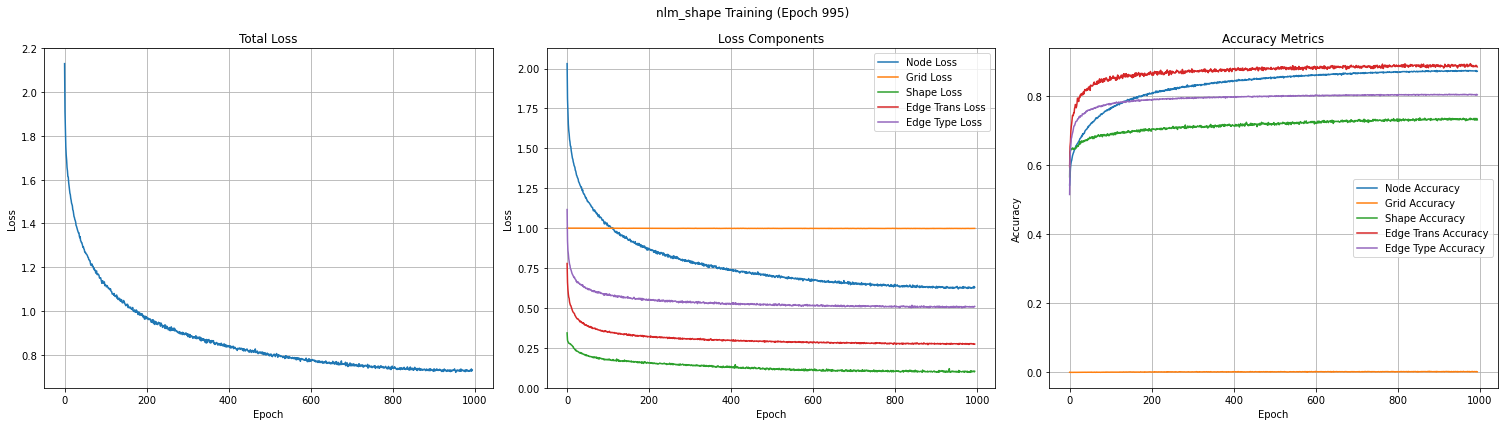

Epoch 996/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.69it/s]


Epoch 996/1000 - Loss: 0.7293 (Node: 0.6295, EdgeTrans: 0.2757, EdgeType: 0.5101, Grid: 0.9977, Shape: 0.1013), Node Acc: 0.8735, Grid Acc: 0.0023, Shape Acc: 0.738816, EdgeTrans Acc: 0.8912, EdgeType Acc: 0.8041


Epoch 997/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.60it/s]


Epoch 997/1000 - Loss: 0.7252 (Node: 0.6254, EdgeTrans: 0.2763, EdgeType: 0.5056, Grid: 0.9982, Shape: 0.1015), Node Acc: 0.8744, Grid Acc: 0.0018, Shape Acc: 0.730584, EdgeTrans Acc: 0.8881, EdgeType Acc: 0.8045


Epoch 998/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.68it/s]


Epoch 998/1000 - Loss: 0.7245 (Node: 0.6248, EdgeTrans: 0.2732, EdgeType: 0.5042, Grid: 0.9976, Shape: 0.1009), Node Acc: 0.8734, Grid Acc: 0.0024, Shape Acc: 0.733245, EdgeTrans Acc: 0.8907, EdgeType Acc: 0.8052


Epoch 999/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.67it/s]


Epoch 999/1000 - Loss: 0.7224 (Node: 0.6227, EdgeTrans: 0.2724, EdgeType: 0.5035, Grid: 0.9974, Shape: 0.0992), Node Acc: 0.8739, Grid Acc: 0.0026, Shape Acc: 0.730584, EdgeTrans Acc: 0.8849, EdgeType Acc: 0.8046


Epoch 1000/1000: 100%|██████████| 1504/1504 [01:09<00:00, 21.70it/s]


Epoch 1000/1000 - Loss: 0.7199 (Node: 0.6201, EdgeTrans: 0.2764, EdgeType: 0.5054, Grid: 0.9979, Shape: 0.0968), Node Acc: 0.8739, Grid Acc: 0.0021, Shape Acc: 0.732912, EdgeTrans Acc: 0.8898, EdgeType Acc: 0.8042
Model state saved to output/models/nlm_shape/nlm_shape_epoch_1000.pt
Checkpoint saved to output/models/nlm_shape/nlm_shape_epoch_1000.pt


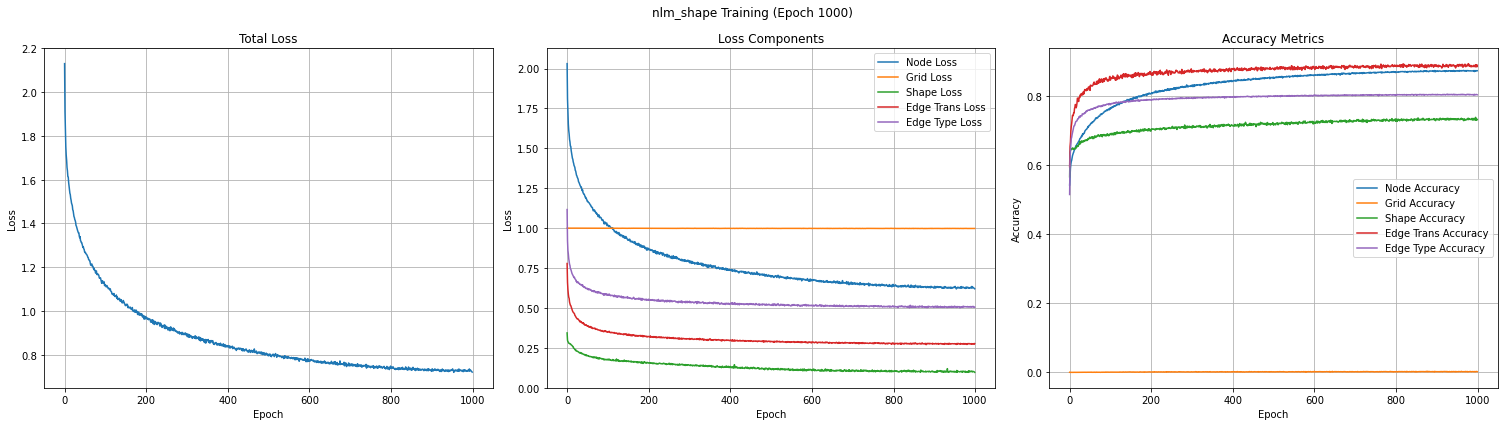

Model state saved to output/models/nlm_shape/nlm_shape_final.pt
Final model saved to output/models/nlm_shape/nlm_shape_final.pt
History saved to output/models/nlm_shape/nlm_shape_history.json
Training complete!


In [1]:
import os
import json
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from task5 import Task
from nlm_shape import NLMReasoningModule
import random
import torch.multiprocessing as mp
import traceback
from functools import partial
from trainer import train_model, load_precomputed_tasks

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
MODEL_DIR = "output/models/nlm_shape"
DATA_DIR = "precomputed_tasks/training"
METRICS_DIR = "output/metrics"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

# Main function
def main():
    # Load tasks
    print("Loading tasks...")
    tasks = load_precomputed_tasks(DATA_DIR)
    print(f"Loaded {len(tasks)} tasks")
    
    try:
        # Initialize model
        print("Initializing nlm model...")
        model = NLMReasoningModule(
            input_dim=3,
            hidden_dim=128,
            output_dim=11,
            device=device
        )
        model.model = model.model.to(device)
        
        # Train model with task-aware approach
        print("Starting nlm model training...")
        trained_model, history = train_model(
            model=model,
            tasks=tasks,
            num_epochs=1000,
            learning_rate=0.0001,
            weight_decay=1e-5,
            save_dir=MODEL_DIR,
            model_name="nlm_shape",
            batch_size=8,
            device=device
        )
        
        print("Training complete!")
        return trained_model, history
        
    except Exception as e:
        print(f"Error in main function: {e}")
        traceback.print_exc()
        return None, None

# Run the main function when executed
if __name__ == "__main__":
    mp.set_start_method('spawn', force=True)
    model, history = main()

In [4]:
import os
import json
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from task4 import Task, Blackboard
from unified_module import UnifiedReasoningModule
from trainer import load_precomputed_tasks
import random
import traceback
from meta_learning import run_meta_learning, MAMLTrainer, ProtoNetTrainer

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
MODEL_DIR = "output/models/nlm"
TRAIN_DIR = "precomputed_tasks/training_400"
EVAL_DIR = "precomputed_tasks/evaluation_400"
METRICS_DIR = "output/metrics/nlm"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

# Split tasks into training and validation sets
def split_tasks(tasks, val_ratio=0.2):
    """Split tasks into training and validation sets"""
    random.shuffle(tasks)
    val_size = int(len(tasks) * val_ratio)
    train_tasks = tasks[val_size:]
    val_tasks = tasks[:val_size]
    return train_tasks, val_tasks

# Train meta-learning models
def train_meta_learning(model, train_tasks, val_tasks, method="both"):
    """
    Train meta-learning models.
    
    Args:
        model: Reasoning module instance
        train_tasks: List of training tasks
        val_tasks: List of validation tasks
        method: Which method to use ("maml", "proto", or "both")
        
    Returns:
        Dictionary of trained models
    """
    trained_models = {}
    
    if method.lower() == "maml" or method.lower() == "both":
        print("Training MAML model...")
        maml_trainer = run_meta_learning(
            reasoning_module=model,
            train_tasks=train_tasks,
            val_tasks=val_tasks,
            method="maml",
            epochs=50,
            lr=0.001,
            weight_decay=1e-5,
            log_dir=os.path.join(MODEL_DIR, "maml")
        )
        trained_models["maml"] = maml_trainer
    
    if method.lower() == "proto" or method.lower() == "both":
        print("Training Prototypical Networks model...")
        proto_trainer = run_meta_learning(
            reasoning_module=model,
            train_tasks=train_tasks,
            val_tasks=val_tasks,
            method="proto",
            epochs=50,
            lr=0.001,
            weight_decay=1e-5,
            log_dir=os.path.join(MODEL_DIR, "proto")
        )
        trained_models["proto"] = proto_trainer
    
    return trained_models

# Test on new tasks
def test_meta_learning(trainer, test_tasks):
    """
    Test meta-learning models on new tasks.
    
    Args:
        trainer: Meta-learning trainer instance
        test_tasks: List of test tasks
        
    Returns:
        Dictionary of test metrics
    """
    print(f"Testing {trainer.__class__.__name__} on {len(test_tasks)} tasks...")
    
    task_metrics = []
    avg_accuracy = 0.0
    
    for i, task in enumerate(test_tasks):
        try:
            # Prepare support and query sets
            support_graphs = task.train_graphs
            query_graphs = task.test_graphs
            
            if not support_graphs or not query_graphs:
                print(f"Skipping task {i} due to empty graphs")
                continue
                
            # Create batches
            support_batch = Batch.from_data_list(support_graphs).to(device)
            query_batch = Batch.from_data_list(query_graphs).to(device)
            
            # Evaluate with few-shot adaptation
            accuracy = trainer.validate_task(support_batch, query_batch)
            
            print(f"Task {i} accuracy: {accuracy:.4f}")
            task_metrics.append({
                "task_id": task.task_id,
                "accuracy": accuracy,
                "num_train": len(support_graphs),
                "num_test": len(query_graphs)
            })
            
            avg_accuracy += accuracy
            
        except Exception as e:
            print(f"Error testing task {i}: {e}")
            traceback.print_exc()
    
    avg_accuracy /= len(task_metrics) if task_metrics else 1.0
    print(f"Average test accuracy: {avg_accuracy:.4f}")
    
    # Save metrics
    method_name = trainer.__class__.__name__.replace("Trainer", "").lower()
    metrics_path = os.path.join(METRICS_DIR, f"{method_name}_test_metrics.json")
    with open(metrics_path, "w") as f:
        json.dump({
            "avg_accuracy": avg_accuracy,
            "task_metrics": task_metrics
        }, f, indent=2)
    
    return {
        "avg_accuracy": avg_accuracy,
        "task_metrics": task_metrics
    }

# Main function
def main():
    # Load tasks
    print("Loading tasks...")
    tasks = load_precomputed_tasks(TRAIN_DIR)
    test_tasks = load_precomputed_tasks(EVAL_DIR)
    
    # Split into train, validation, and test sets
    train_tasks, val_tasks = split_tasks(tasks, val_ratio=0.2)
    print(f"Split into {len(train_tasks)} training, {len(val_tasks)} validation, and {len(test_tasks)} test tasks")
    
    try:
        # Initialize model
        print("Initializing unified model...")
        model = UnifiedReasoningModule(
            input_dim=3,
            hidden_dim=128,
            output_dim=11,
            device=device
        )
        model.load_complete_state(os.path.join(MODEL_DIR, "unified_reasoning_model_final.pt"))
        model.model = model.model.to(device)
        
        # Train meta-learning models
        print("Training meta-learning models...")
        trained_models = train_meta_learning(
            model=model,
            train_tasks=train_tasks,
            val_tasks=val_tasks,
            method="maml"
        )
        
        # Test meta-learning models
        print("Testing meta-learning models...")
        test_results = {}
        for method, trainer in trained_models.items():
            test_results[method] = test_meta_learning(trainer, test_tasks)
        
        # Compare results
        print("\nComparison of meta-learning methods:")
        for method, results in test_results.items():
            print(f"{method.upper()}: Average accuracy = {results['avg_accuracy']:.4f}")
        
        print("Meta-learning training and evaluation complete!")
        return trained_models, test_results
        
    except Exception as e:
        print(f"Error in main function: {e}")
        traceback.print_exc()
        return None, None

# Run the main function when executed
if __name__ == "__main__":
    models, results = main()

Using device: cuda
Loading tasks...
Loading precomputed tasks from precomputed_tasks/training_400


Loading tasks from precomputed_tasks/training_400: 100%|██████████| 400/400 [00:02<00:00, 177.71it/s]


Loaded 400 precomputed tasks
Loading precomputed tasks from precomputed_tasks/evaluation_400


Loading tasks from precomputed_tasks/evaluation_400: 100%|██████████| 400/400 [00:02<00:00, 145.72it/s]


Loaded 400 precomputed tasks
Split into 320 training, 80 validation, and 400 test tasks
Initializing unified model...
Error: State file not found at output/models/nlm/unified_reasoning_model_final.pt
Training meta-learning models...
Training MAML model...
Error in main function: run_meta_learning() got an unexpected keyword argument 'lr'


Traceback (most recent call last):
  File "/tmp/ipykernel_2640298/491263199.py", line 176, in main
    trained_models = train_meta_learning(
  File "/tmp/ipykernel_2640298/491263199.py", line 58, in train_meta_learning
    maml_trainer = run_meta_learning(
TypeError: run_meta_learning() got an unexpected keyword argument 'lr'


Using device: cuda
Loading tasks...
Loading precomputed tasks from precomputed_tasks/training_400


Loading tasks from precomputed_tasks/training_400: 100%|██████████| 400/400 [00:02<00:00, 164.74it/s]


Loaded 400 precomputed tasks
Loading precomputed tasks from precomputed_tasks/evaluation_400


Loading tasks from precomputed_tasks/evaluation_400: 100%|██████████| 400/400 [00:02<00:00, 143.07it/s]


Loaded 400 precomputed tasks
Loaded 400 training tasks and 400 evaluation tasks
Initializing unified model...
Model state loaded from output/models/unified/unified_reasoning_model_final.pt

=== Training MAML with 5-fold cross-validation ===

=== Training Fold 1/5 ===
Train tasks: 320, Validation tasks: 80
Model state loaded from output/models/unified/unified_reasoning_model_final.pt


Training MAML: 100%|██████████| 320/320 [03:00<00:00,  1.77it/s, avg_loss=8.8942, loss=2.4586]  


Epoch 1/50 - Loss: 8.8942, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=8.4312, loss=1.9953]  


Epoch 2/50 - Loss: 8.4312, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=8.4218, loss=2.2637]  


Epoch 3/50 - Loss: 8.4218, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=8.2739, loss=1.9088]  


Epoch 4/50 - Loss: 8.2739, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=8.0217, loss=2.6773]  


Epoch 5/50 - Loss: 8.0217, Train Acc: 0.0000, Val Acc: 0.0000


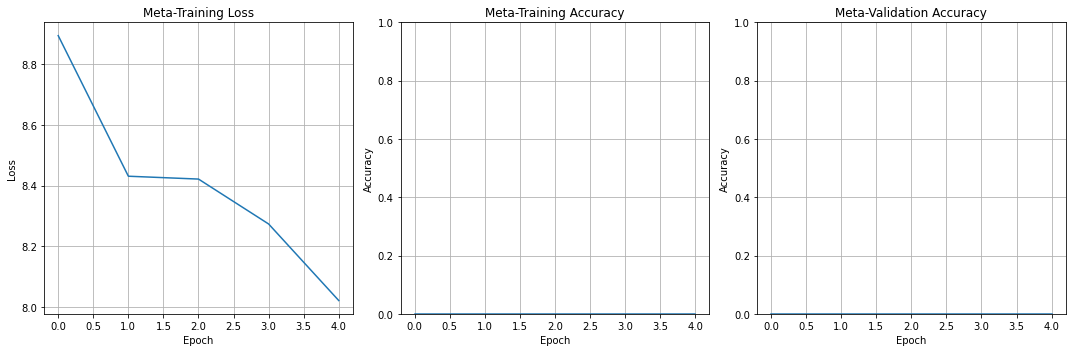

Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.93it/s, avg_loss=7.9979, loss=2.2214] 


Epoch 6/50 - Loss: 7.9979, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:44<00:00,  1.94it/s, avg_loss=8.1690, loss=2.1637] 


Epoch 7/50 - Loss: 8.1690, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.93it/s, avg_loss=7.5358, loss=2.1031]  


Epoch 9/50 - Loss: 7.5358, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:29<00:00,  2.14it/s, avg_loss=7.9432, loss=2.6049] 


Epoch 11/50 - Loss: 7.9432, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=7.9420, loss=1.9595]  


Epoch 12/50 - Loss: 7.9420, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:48<00:00,  1.90it/s, avg_loss=7.8141, loss=1.8502]  


Epoch 14/50 - Loss: 7.8141, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:29<00:00,  2.15it/s, avg_loss=7.5806, loss=1.7950] 


Epoch 16/50 - Loss: 7.5806, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:48<00:00,  1.90it/s, avg_loss=7.7188, loss=2.0072]  


Epoch 17/50 - Loss: 7.7188, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:49<00:00,  1.88it/s, avg_loss=8.0285, loss=1.7465]  


Epoch 18/50 - Loss: 8.0285, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:31<00:00,  2.11it/s, avg_loss=7.4180, loss=1.9518]  


Epoch 19/50 - Loss: 7.4180, Train Acc: 0.0000, Val Acc: 0.0000


IOPub message rate exceeded.█▉| 316/320 [02:46<00:02,  1.96it/s, avg_loss=7.0605, loss=6.6076] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=7.0235, loss=1.8100] 


Epoch 22/50 - Loss: 7.0235, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=7.1350, loss=1.9718]  


Epoch 23/50 - Loss: 7.1350, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:42<00:00,  1.97it/s, avg_loss=6.7412, loss=1.8629] 


Epoch 24/50 - Loss: 6.7412, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:41<00:00,  1.98it/s, avg_loss=6.8284, loss=1.9263] 


Epoch 25/50 - Loss: 6.8284, Train Acc: 0.0000, Val Acc: 0.0000


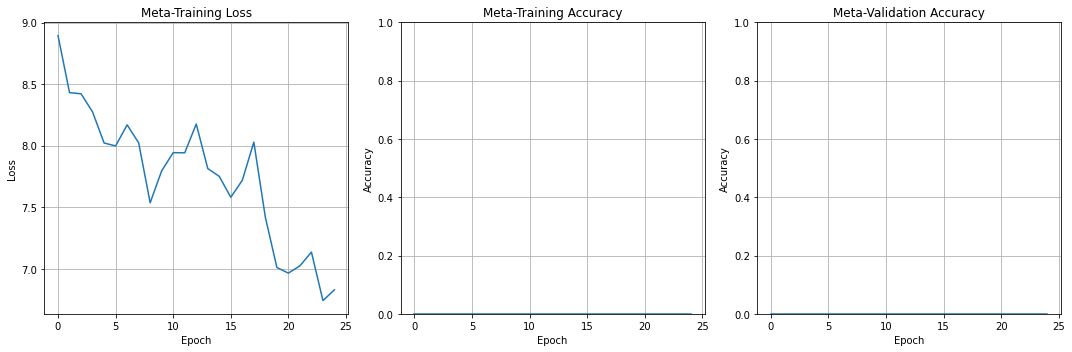

Training MAML: 100%|██████████| 320/320 [02:41<00:00,  1.98it/s, avg_loss=6.5935, loss=1.9254] 


Epoch 26/50 - Loss: 6.5935, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:43<00:00,  1.96it/s, avg_loss=6.7780, loss=1.8808] 


Epoch 27/50 - Loss: 6.7780, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:45<00:00,  1.94it/s, avg_loss=6.2886, loss=1.7628] 


Epoch 29/50 - Loss: 6.2886, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=6.1366, loss=1.7361] 


Epoch 30/50 - Loss: 6.1366, Train Acc: 0.0000, Val Acc: 0.0000


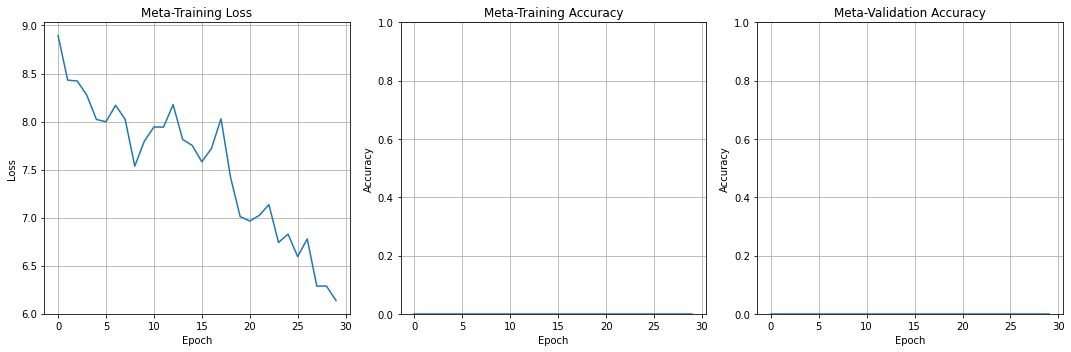

Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=6.4299, loss=1.8226]  


Epoch 32/50 - Loss: 6.4299, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.92it/s, avg_loss=6.1328, loss=1.9099] 


Epoch 33/50 - Loss: 6.1328, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=5.9975, loss=2.0012] 


Epoch 34/50 - Loss: 5.9975, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=5.8879, loss=1.8895] 


Epoch 35/50 - Loss: 5.8879, Train Acc: 0.0000, Val Acc: 0.0000


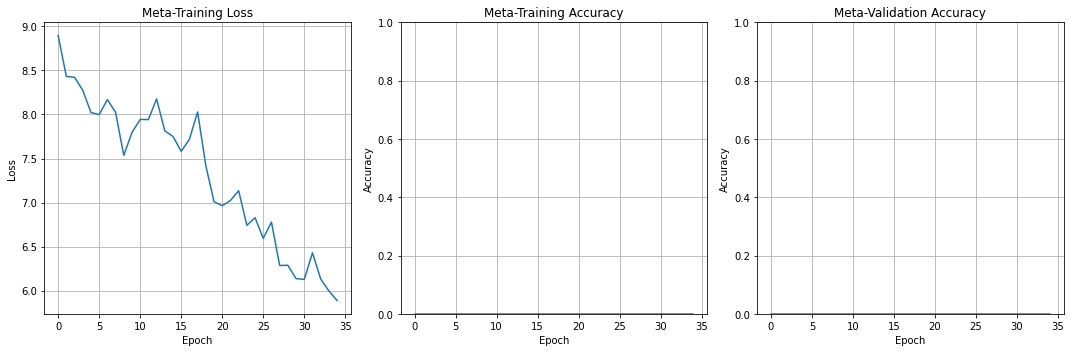

IOPub message rate exceeded.█▏| 293/320 [02:33<00:26,  1.03it/s, avg_loss=6.0718, loss=0.4189] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training MAML: 100%|██████████| 320/320 [02:35<00:00,  2.06it/s, avg_loss=5.7635, loss=2.1221] 


Epoch 38/50 - Loss: 5.7635, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.04it/s, avg_loss=5.8360, loss=1.7804]  


Epoch 40/50 - Loss: 5.8360, Train Acc: 0.0000, Val Acc: 0.0000


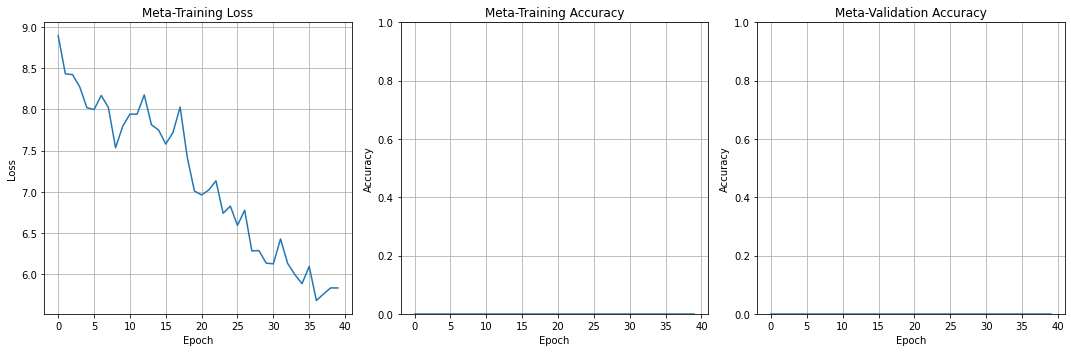

Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.04it/s, avg_loss=5.6287, loss=1.8182] 


Epoch 41/50 - Loss: 5.6287, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.04it/s, avg_loss=5.5290, loss=1.7432] 


Epoch 42/50 - Loss: 5.5290, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.04it/s, avg_loss=5.7635, loss=2.0138]  


Epoch 43/50 - Loss: 5.7635, Train Acc: 0.0000, Val Acc: 0.0000


IOPub message rate exceeded.  | 227/320 [01:49<00:41,  2.26it/s, avg_loss=5.7863, loss=5.3220] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.04it/s, avg_loss=5.5836, loss=1.7994] 


Epoch 49/50 - Loss: 5.5836, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.04it/s, avg_loss=5.4774, loss=1.7297] 


Epoch 50/50 - Loss: 5.4774, Train Acc: 0.0000, Val Acc: 0.0000


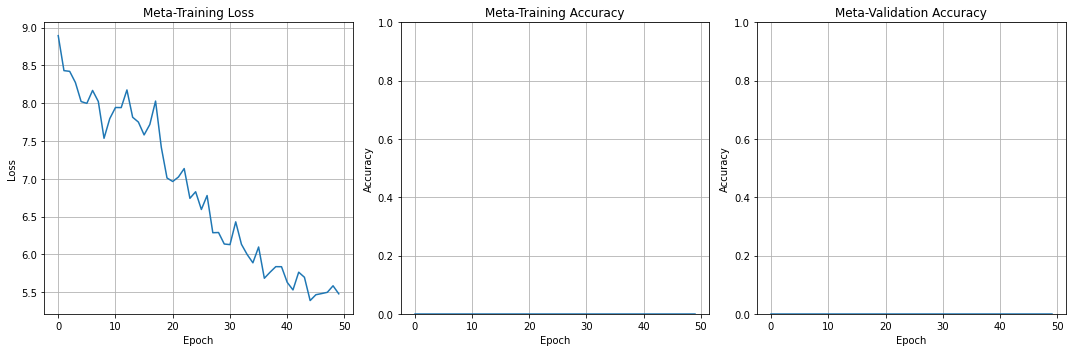

Evaluating tasks: 100%|██████████| 80/80 [00:00<00:00, 24167.70it/s]


Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geomet

Training MAML: 100%|██████████| 320/320 [02:32<00:00,  2.10it/s, avg_loss=5.2004, loss=1.7521] 


Epoch 1/50 - Loss: 5.2004, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.07it/s, avg_loss=5.0029, loss=1.6926] 


Epoch 2/50 - Loss: 5.0029, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:33<00:00,  2.08it/s, avg_loss=5.0682, loss=1.8746] 


Epoch 4/50 - Loss: 5.0682, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.07it/s, avg_loss=5.0769, loss=1.6949] 


Epoch 5/50 - Loss: 5.0769, Train Acc: 0.0000, Val Acc: 0.0000


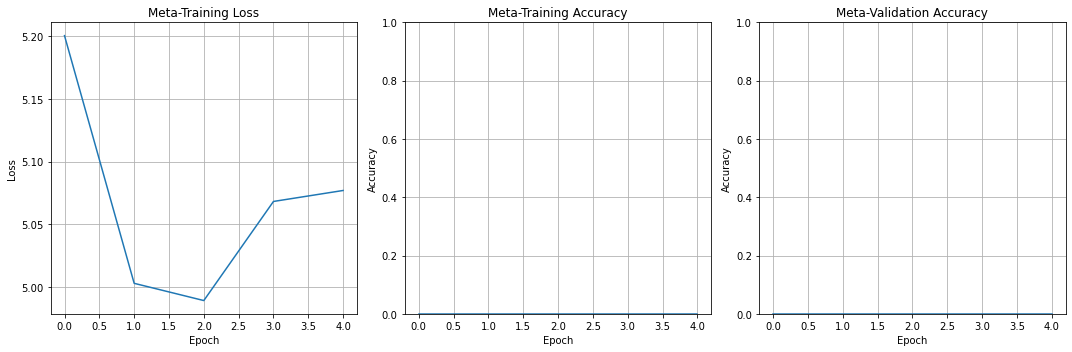

Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.07it/s, avg_loss=4.9724, loss=1.8980] 


Epoch 6/50 - Loss: 4.9724, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.07it/s, avg_loss=4.9045, loss=1.8433] 


Epoch 7/50 - Loss: 4.9045, Train Acc: 0.0000, Val Acc: 0.0000


IOPub message rate exceeded.█▉| 318/320 [02:33<00:00,  2.54it/s, avg_loss=4.9591, loss=5.1459] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training MAML: 100%|██████████| 320/320 [02:33<00:00,  2.09it/s, avg_loss=4.8828, loss=2.0339] 


Epoch 10/50 - Loss: 4.8828, Train Acc: 0.0000, Val Acc: 0.0000


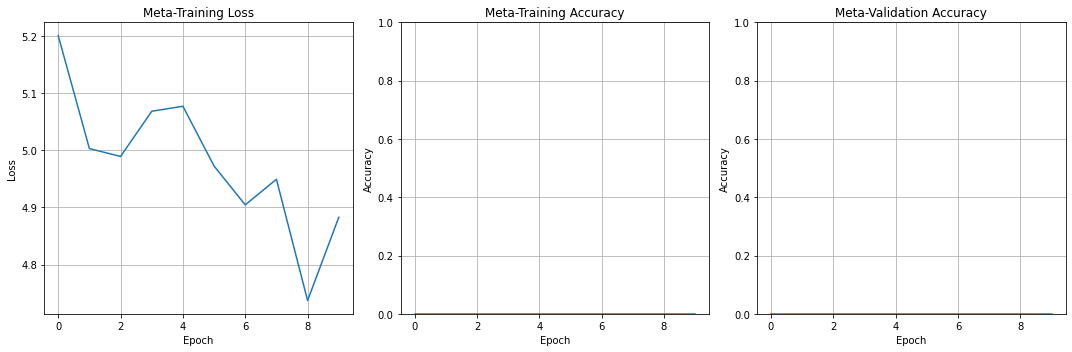

Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.07it/s, avg_loss=4.7150, loss=1.8693] 


Epoch 11/50 - Loss: 4.7150, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:33<00:00,  2.08it/s, avg_loss=4.6948, loss=1.8010] 


Epoch 12/50 - Loss: 4.6948, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.07it/s, avg_loss=4.8956, loss=1.8959] 


Epoch 13/50 - Loss: 4.8956, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.07it/s, avg_loss=4.8543, loss=1.8073] 


Epoch 14/50 - Loss: 4.8543, Train Acc: 0.0000, Val Acc: 0.0000


IOPub message rate exceeded.  | 173/320 [01:21<00:53,  2.72it/s, avg_loss=4.8435, loss=0.5398] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=4.7573, loss=1.9442] 


Epoch 18/50 - Loss: 4.7573, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.25it/s, avg_loss=4.8493, loss=1.8459] 


Epoch 19/50 - Loss: 4.8493, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.25it/s, avg_loss=4.4889, loss=3.1570] 


Epoch 20/50 - Loss: 4.4889, Train Acc: 0.0000, Val Acc: 0.0000


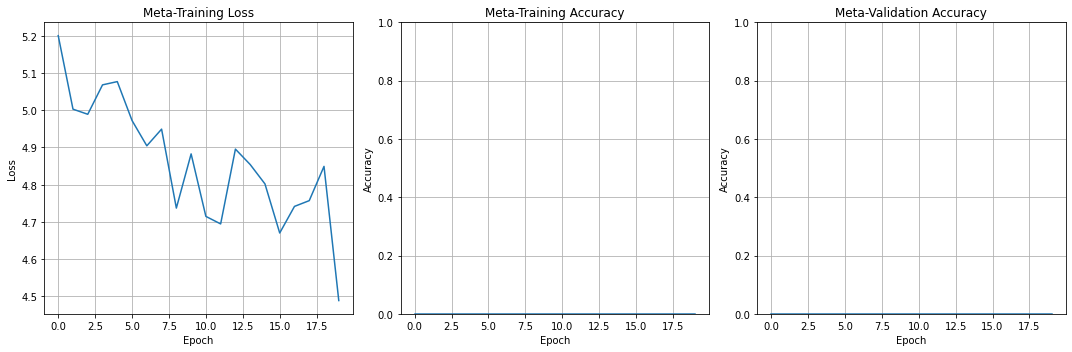

Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.25it/s, avg_loss=4.7375, loss=2.6117] 


Epoch 21/50 - Loss: 4.7375, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.26it/s, avg_loss=4.7553, loss=2.8551] 


Epoch 23/50 - Loss: 4.7553, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.26it/s, avg_loss=4.5868, loss=2.9644] 


Epoch 24/50 - Loss: 4.5868, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=4.7078, loss=3.3002] 


Epoch 26/50 - Loss: 4.7078, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=4.7556, loss=2.7789] 


Epoch 27/50 - Loss: 4.7556, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=4.6932, loss=2.3800] 


Epoch 28/50 - Loss: 4.6932, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.24it/s, avg_loss=4.7990, loss=2.6669] 


Epoch 29/50 - Loss: 4.7990, Train Acc: 0.0000, Val Acc: 0.0000


IOPub message rate exceeded.█▏| 292/320 [02:11<00:11,  2.37it/s, avg_loss=4.6564, loss=1.9498] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.30it/s, avg_loss=3.8797, loss=2.6734] 


Epoch 32/50 - Loss: 3.8797, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.30it/s, avg_loss=3.9446, loss=2.8046] 


Epoch 33/50 - Loss: 3.9446, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.30it/s, avg_loss=3.9258, loss=2.6388] 


Epoch 34/50 - Loss: 3.9258, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.30it/s, avg_loss=3.8718, loss=2.8153] 


Epoch 35/50 - Loss: 3.8718, Train Acc: 0.0000, Val Acc: 0.0000


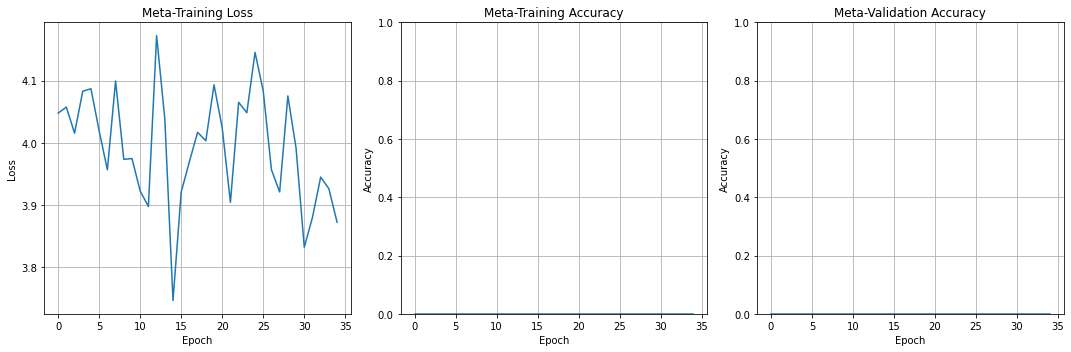

Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.31it/s, avg_loss=3.9269, loss=2.7758] 


Epoch 36/50 - Loss: 3.9269, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.30it/s, avg_loss=3.8658, loss=2.8035] 


Epoch 37/50 - Loss: 3.8658, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.30it/s, avg_loss=3.8746, loss=2.6348] 


Epoch 38/50 - Loss: 3.8746, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.30it/s, avg_loss=4.0914, loss=2.6625] 


Epoch 39/50 - Loss: 4.0914, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.30it/s, avg_loss=3.8988, loss=2.8734] 


Epoch 40/50 - Loss: 3.8988, Train Acc: 0.0000, Val Acc: 0.0000


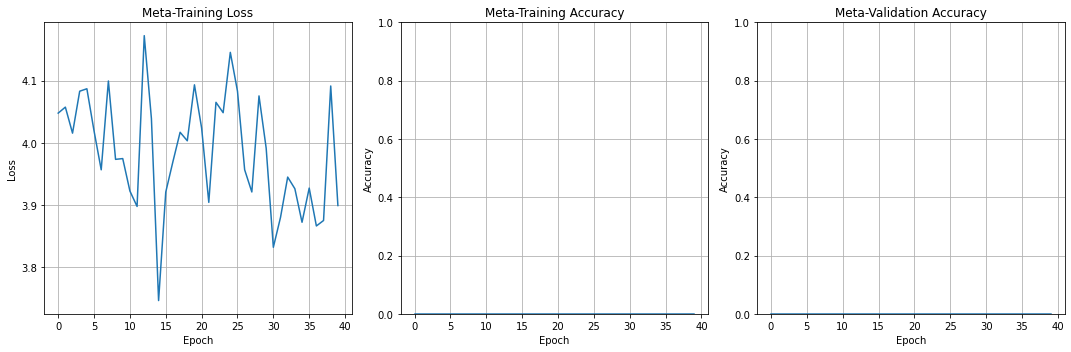

Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.30it/s, avg_loss=3.9827, loss=2.7291] 


Epoch 41/50 - Loss: 3.9827, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.31it/s, avg_loss=3.9081, loss=2.6946] 


Epoch 42/50 - Loss: 3.9081, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.30it/s, avg_loss=3.9704, loss=2.6097] 


Epoch 43/50 - Loss: 3.9704, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.30it/s, avg_loss=3.9590, loss=2.7330] 


Epoch 44/50 - Loss: 3.9590, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.29it/s, avg_loss=3.9195, loss=2.9135] 


Epoch 45/50 - Loss: 3.9195, Train Acc: 0.0000, Val Acc: 0.0000


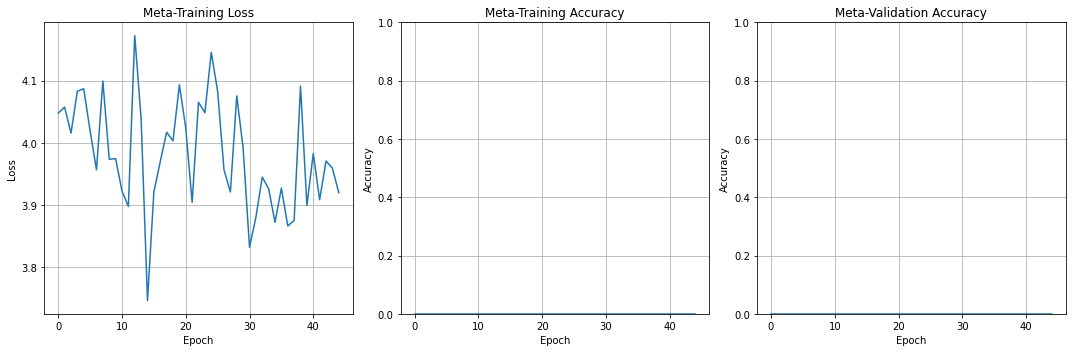

Training MAML: 100%|██████████| 320/320 [02:16<00:00,  2.35it/s, avg_loss=3.9894, loss=2.7199] 


Epoch 46/50 - Loss: 3.9894, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:15<00:00,  2.36it/s, avg_loss=3.9758, loss=2.9143] 


Epoch 47/50 - Loss: 3.9758, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:15<00:00,  2.37it/s, avg_loss=3.9799, loss=2.6702] 


Epoch 48/50 - Loss: 3.9799, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.30it/s, avg_loss=4.0194, loss=2.9584] 


Epoch 49/50 - Loss: 4.0194, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.30it/s, avg_loss=3.9830, loss=2.6548] 


Epoch 50/50 - Loss: 3.9830, Train Acc: 0.0000, Val Acc: 0.0000


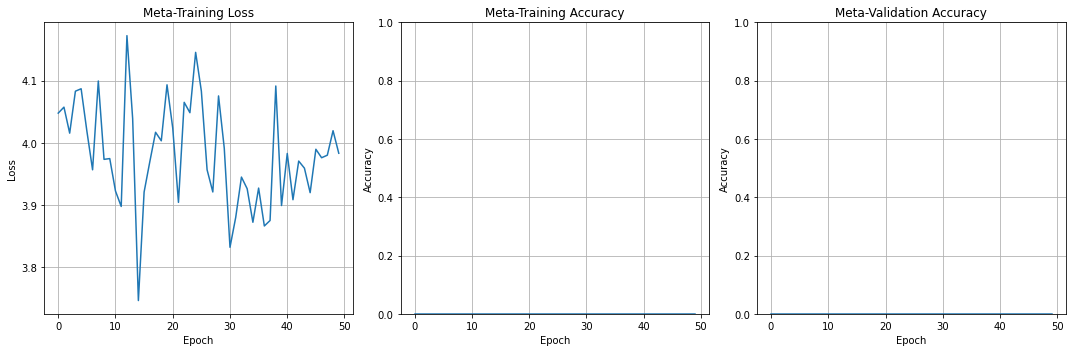

Evaluating tasks: 100%|██████████| 80/80 [00:00<00:00, 23164.95it/s]


Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geomet

Training MAML: 100%|██████████| 320/320 [02:25<00:00,  2.20it/s, avg_loss=4.0617, loss=3.3299] 


Epoch 1/50 - Loss: 4.0617, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:24<00:00,  2.22it/s, avg_loss=4.1680, loss=3.2225] 


Epoch 2/50 - Loss: 4.1680, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.22it/s, avg_loss=3.8704, loss=2.7907] 


Epoch 3/50 - Loss: 3.8704, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:24<00:00,  2.21it/s, avg_loss=4.0928, loss=3.2015] 


Epoch 4/50 - Loss: 4.0928, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:24<00:00,  2.21it/s, avg_loss=4.1019, loss=3.8261] 


Epoch 5/50 - Loss: 4.1019, Train Acc: 0.0000, Val Acc: 0.0000


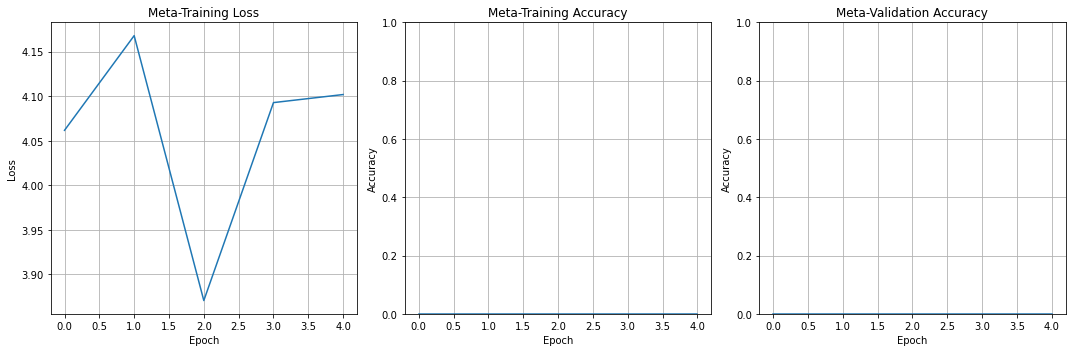

Training MAML: 100%|██████████| 320/320 [02:24<00:00,  2.22it/s, avg_loss=4.0541, loss=3.8481] 


Epoch 6/50 - Loss: 4.0541, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:24<00:00,  2.22it/s, avg_loss=4.1978, loss=2.8187] 


Epoch 7/50 - Loss: 4.1978, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=4.1017, loss=3.8879] 


Epoch 8/50 - Loss: 4.1017, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:24<00:00,  2.22it/s, avg_loss=4.0312, loss=3.5750] 


Epoch 9/50 - Loss: 4.0312, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.24it/s, avg_loss=4.1216, loss=2.6383] 


Epoch 10/50 - Loss: 4.1216, Train Acc: 0.0000, Val Acc: 0.0000


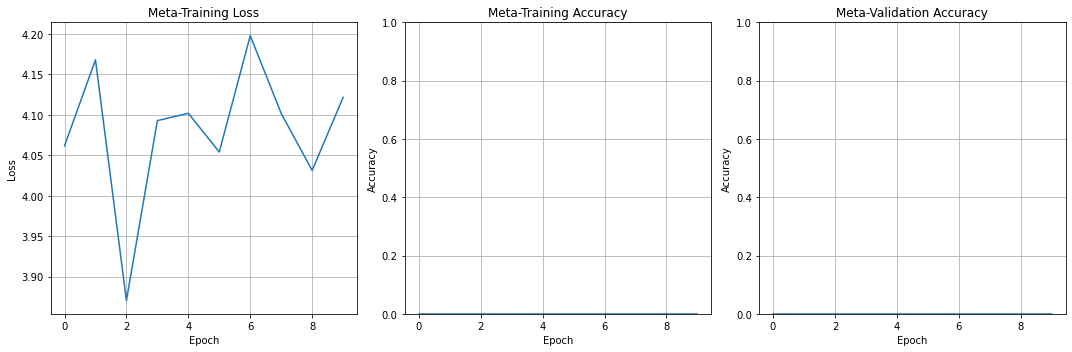

Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=4.1765, loss=2.9832] 


Epoch 11/50 - Loss: 4.1765, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.8826, loss=3.1958] 


Epoch 12/50 - Loss: 3.8826, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=4.1348, loss=3.2698] 


Epoch 13/50 - Loss: 4.1348, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.9554, loss=3.2640] 


Epoch 14/50 - Loss: 3.9554, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.22it/s, avg_loss=3.9337, loss=3.0508] 


Epoch 15/50 - Loss: 3.9337, Train Acc: 0.0000, Val Acc: 0.0000


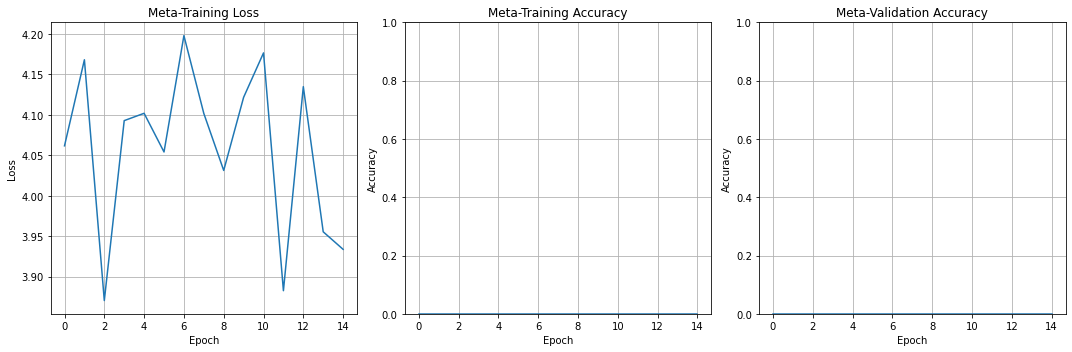

Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=4.0418, loss=3.1010] 


Epoch 16/50 - Loss: 4.0418, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=4.0265, loss=3.0153] 


Epoch 17/50 - Loss: 4.0265, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=4.0376, loss=3.7016] 


Epoch 18/50 - Loss: 4.0376, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.9921, loss=2.8535] 


Epoch 19/50 - Loss: 3.9921, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.9002, loss=3.0522] 


Epoch 20/50 - Loss: 3.9002, Train Acc: 0.0000, Val Acc: 0.0000


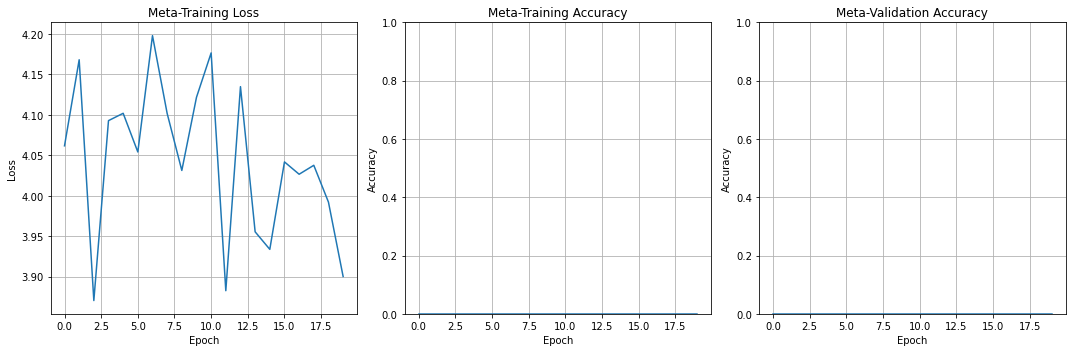

Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.24it/s, avg_loss=4.0854, loss=3.0935] 


Epoch 21/50 - Loss: 4.0854, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.24it/s, avg_loss=3.8060, loss=3.0975] 


Epoch 22/50 - Loss: 3.8060, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.7893, loss=2.7991] 


Epoch 23/50 - Loss: 3.7893, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=4.0055, loss=3.4542] 


Epoch 24/50 - Loss: 4.0055, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.8893, loss=2.2102] 


Epoch 25/50 - Loss: 3.8893, Train Acc: 0.0000, Val Acc: 0.0000


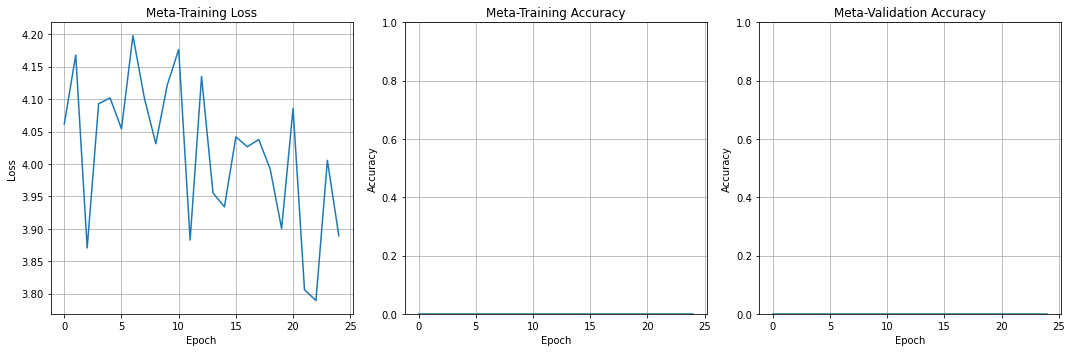

Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.22it/s, avg_loss=3.9664, loss=3.2210] 


Epoch 26/50 - Loss: 3.9664, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.7721, loss=2.9340] 


Epoch 27/50 - Loss: 3.7721, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=3.8898, loss=3.5225] 


Epoch 28/50 - Loss: 3.8898, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:24<00:00,  2.22it/s, avg_loss=3.9126, loss=2.2958] 


Epoch 29/50 - Loss: 3.9126, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.22it/s, avg_loss=3.7383, loss=2.6370] 


Epoch 30/50 - Loss: 3.7383, Train Acc: 0.0000, Val Acc: 0.0000


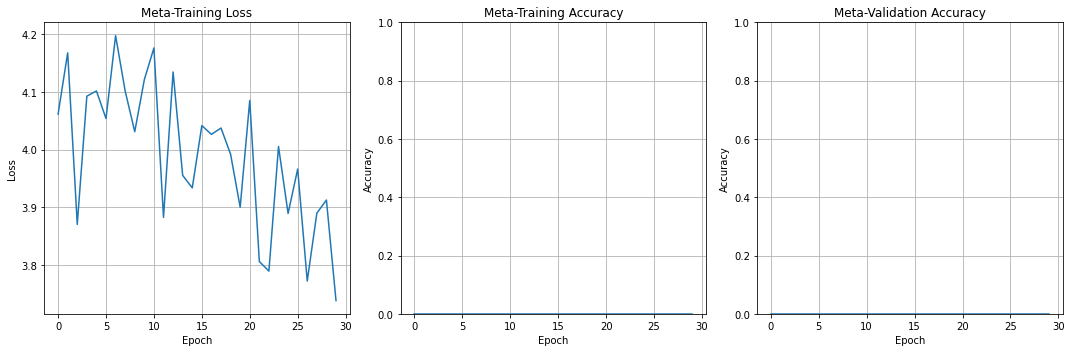

Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.9194, loss=3.1043] 


Epoch 31/50 - Loss: 3.9194, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.24it/s, avg_loss=3.8626, loss=2.5802] 


Epoch 32/50 - Loss: 3.8626, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=4.0611, loss=2.7998] 


Epoch 33/50 - Loss: 4.0611, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=3.8422, loss=2.6582] 


Epoch 34/50 - Loss: 3.8422, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.8817, loss=3.4108] 


Epoch 35/50 - Loss: 3.8817, Train Acc: 0.0000, Val Acc: 0.0000


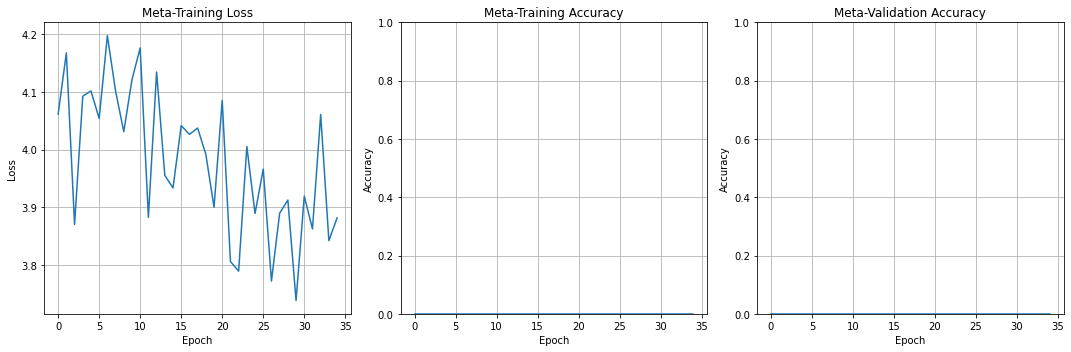

Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=3.9132, loss=4.3613] 


Epoch 36/50 - Loss: 3.9132, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.9235, loss=3.4177] 


Epoch 37/50 - Loss: 3.9235, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.8100, loss=3.7005] 


Epoch 38/50 - Loss: 3.8100, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=3.8366, loss=2.6275] 


Epoch 39/50 - Loss: 3.8366, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.9507, loss=2.7981] 


Epoch 40/50 - Loss: 3.9507, Train Acc: 0.0000, Val Acc: 0.0000


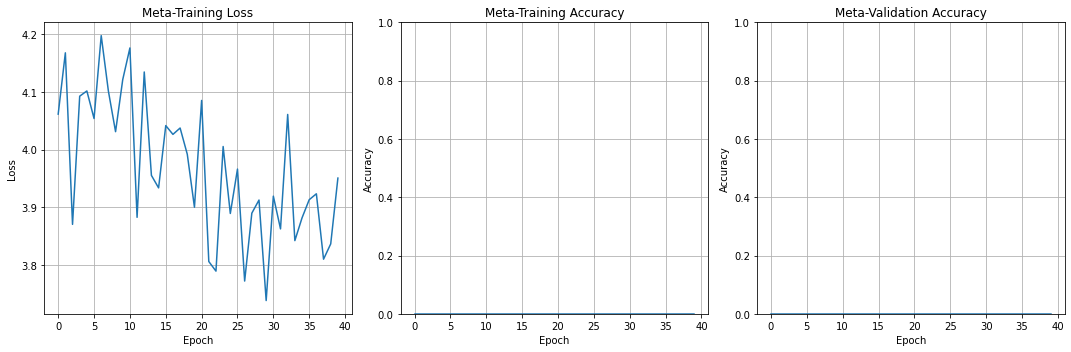

Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.22it/s, avg_loss=3.9197, loss=3.4301] 


Epoch 41/50 - Loss: 3.9197, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.9624, loss=3.0458] 


Epoch 42/50 - Loss: 3.9624, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.24it/s, avg_loss=3.7920, loss=3.2451] 


Epoch 43/50 - Loss: 3.7920, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.9247, loss=2.3095] 


Epoch 44/50 - Loss: 3.9247, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.8687, loss=3.1740] 


Epoch 45/50 - Loss: 3.8687, Train Acc: 0.0000, Val Acc: 0.0000


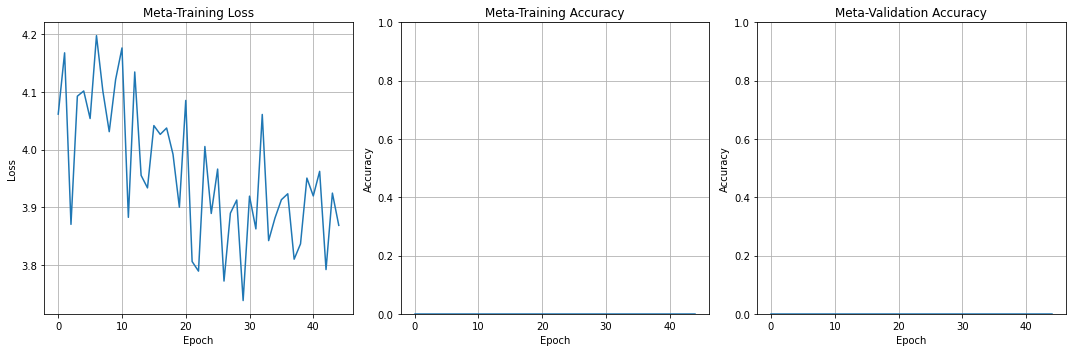

Training MAML: 100%|██████████| 320/320 [02:24<00:00,  2.22it/s, avg_loss=4.1713, loss=3.6387] 


Epoch 46/50 - Loss: 4.1713, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.9156, loss=2.7594] 


Epoch 47/50 - Loss: 3.9156, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.8227, loss=3.7787] 


Epoch 48/50 - Loss: 3.8227, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=4.4502, loss=3.4257]  


Epoch 49/50 - Loss: 4.4502, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=3.8560, loss=3.2029] 


Epoch 50/50 - Loss: 3.8560, Train Acc: 0.0000, Val Acc: 0.0000


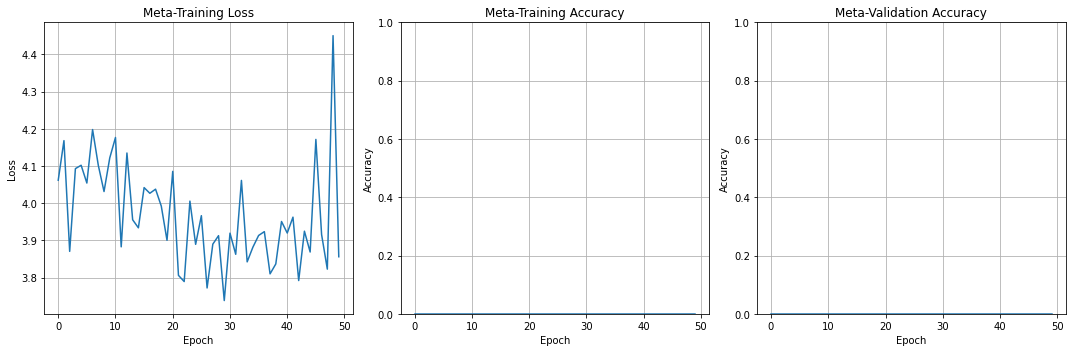

Evaluating tasks: 100%|██████████| 80/80 [00:00<00:00, 23048.79it/s]

Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geometric'
Error evaluating task: module 'torch' has no attribute 'geomet


Traceback (most recent call last):
  File "/tmp/ipykernel_66017/3692621521.py", line 259, in main
    "proto": (best_proto, proto_metrics)
NameError: name 'best_proto' is not defined


In [1]:
import os
import json
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from task4 import Task
from unified_module import UnifiedReasoningModule
from trainer import load_precomputed_tasks
import random
import traceback
from meta_learning import run_meta_learning, MAMLTrainer, ProtoNetTrainer
from sklearn.model_selection import KFold

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
MODEL_DIR = "output/models/unified"
TRAIN_DIR = "precomputed_tasks/training_400"
EVAL_DIR = "precomputed_tasks/evaluation_400"
METRICS_DIR = "output/metrics/unified"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

# Function to create k-fold splits
def create_kfold_splits(tasks, k=5, random_state=42):
    """Create k-fold splits of tasks for cross-validation"""
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Create indices for the splits
    task_indices = np.arange(len(tasks))
    splits = []
    
    for train_idx, val_idx in kf.split(task_indices):
        # Get actual tasks for this fold
        fold_train_tasks = [tasks[i] for i in train_idx]
        fold_val_tasks = [tasks[i] for i in val_idx]
        splits.append((fold_train_tasks, fold_val_tasks))
    
    return splits

# Train meta-learning models with k-fold cross-validation
def train_meta_learning_kfold(model_creator, tasks, test_tasks, method="maml", k=5, epochs=30):
    """
    Train meta-learning models using k-fold cross-validation.
    
    Args:
        model_creator: Function to create a fresh model instance
        tasks: List of all training tasks
        test_tasks: List of test tasks for final evaluation
        method: Which method to use ("maml" or "proto")
        k: Number of folds for cross-validation
        epochs: Number of training epochs per fold
        
    Returns:
        Dictionary with performance metrics
    """
    # Create k-fold splits
    splits = create_kfold_splits(tasks, k=k)
    
    # Store metrics for each fold
    fold_metrics = []
    best_model = None
    best_val_acc = 0.0
    
    # Train and evaluate on each fold
    for fold_idx, (fold_train_tasks, fold_val_tasks) in enumerate(splits):
        print(f"\n=== Training Fold {fold_idx+1}/{k} ===")
        print(f"Train tasks: {len(fold_train_tasks)}, Validation tasks: {len(fold_val_tasks)}")
        
        # Create a fresh model instance for this fold
        fold_model = model_creator()
        
        # Train the model on this fold
        try:
            fold_trainer = run_meta_learning(
                reasoning_module=fold_model,
                train_tasks=fold_train_tasks,
                val_tasks=fold_val_tasks,
                method=method,
                epochs=epochs,
                lr=0.001,
                weight_decay=1e-5,
                log_dir=os.path.join(MODEL_DIR, f"{method}_fold{fold_idx+1}")
            )
            
            # Evaluate on validation set
            val_accuracy = evaluate_tasks(fold_trainer, fold_val_tasks)
            
            # Save metrics for this fold
            fold_metrics.append({
                "fold": fold_idx+1,
                "val_accuracy": val_accuracy,
                "train_tasks": len(fold_train_tasks),
                "val_tasks": len(fold_val_tasks),
                "train_losses": fold_trainer.train_losses[-10:],  # Last 10 epochs
                "val_accuracies": fold_trainer.val_accuracies[-10:]  # Last 10 epochs
            })
            
            print(f"Fold {fold_idx+1} validation accuracy: {val_accuracy:.4f}")
            
            # Keep track of best model
            if val_accuracy > best_val_acc:
                best_val_acc = val_accuracy
                best_model = fold_trainer
                print(f"New best model with validation accuracy: {val_accuracy:.4f}")
                
        except Exception as e:
            print(f"Error training fold {fold_idx+1}: {e}")
            traceback.print_exc()
            
    # Save best model
    if best_model is not None:
        best_model_path = os.path.join(MODEL_DIR, f"{method}_best_model.pt")
        torch.save({
            'model_state_dict': best_model.reasoning_module.model.state_dict(),
            'model_type': type(best_model.reasoning_module).__name__,
            'meta_learning_method': method,
            'val_accuracy': float(best_val_acc),
            'test_accuracy': float(test_accuracy),
            'train_losses': best_model.train_losses,
            'train_accuracies': best_model.train_accuracies,
            'val_accuracies': best_model.val_accuracies,
        }, best_model_path)
        print(f"Best {method} model saved to {best_model_path}")
    
    # Compute average metrics across folds
    avg_val_accuracy = np.mean([m["val_accuracy"] for m in fold_metrics])
    print(f"\nAverage validation accuracy across {k} folds: {avg_val_accuracy:.4f}")
    
    # Evaluate best model on test set
    if best_model is not None:
        test_accuracy = evaluate_tasks(best_model, test_tasks)
        print(f"Best model test accuracy: {test_accuracy:.4f}")
    else:
        test_accuracy = 0.0
        print("No valid model found for testing")
    
    # Save comprehensive metrics
    metrics = {
        "method": method,
        "avg_val_accuracy": float(avg_val_accuracy),
        "test_accuracy": float(test_accuracy),
        "fold_metrics": fold_metrics,
        "best_fold_val_accuracy": float(best_val_acc),
        "k": k
    }
    
    metrics_path = os.path.join(METRICS_DIR, f"{method}_kfold_metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)
    
    return metrics, best_model

# Evaluate model on a set of tasks
def evaluate_tasks(trainer, tasks):
    """
    Evaluate a meta-learning model on a set of tasks.
    
    Args:
        trainer: Meta-learning trainer instance
        tasks: List of tasks to evaluate on
        
    Returns:
        Average accuracy across tasks
    """
    accuracies = []
    
    for task in tqdm(tasks, desc="Evaluating tasks"):
        try:
            # Prepare support and query sets
            support_graphs = task.train_graphs
            query_graphs = task.test_graphs
            
            if not support_graphs or not query_graphs:
                continue
                
            # Create batches
            support_batch = Batch.from_data_list(support_graphs).to(device)
            query_batch = Batch.from_data_list(query_graphs).to(device)
            
            # Evaluate with few-shot adaptation
            accuracy = trainer.validate_task(support_batch, query_batch, task)
            accuracies.append(accuracy)
            
        except Exception as e:
            print(f"Error evaluating task: {e}")
    
    # Calculate average accuracy
    avg_accuracy = np.mean(accuracies) if accuracies else 0.0
    return avg_accuracy

# Main function
def main():
    # Load tasks
    print("Loading tasks...")
    all_train_tasks = load_precomputed_tasks(TRAIN_DIR)
    test_tasks = load_precomputed_tasks(EVAL_DIR)
    print(f"Loaded {len(all_train_tasks)} training tasks and {len(test_tasks)} evaluation tasks")
    
    # Shuffle tasks for better randomization
    random.shuffle(all_train_tasks)
    
    try:
        # Function to create a fresh model instance
        def create_model():
            model = UnifiedReasoningModule(
                input_dim=3,
                hidden_dim=128,
                output_dim=11,
                device=device
            )
            # Load pre-trained weights
            model.load_complete_state(os.path.join(MODEL_DIR, "unified_reasoning_model_final.pt"))
            model.model = model.model.to(device)
            return model
        
        # Initialize the first model
        print("Initializing unified model...")
        base_model = create_model()
        
        # Train MAML with 5-fold cross-validation
        print("\n=== Training MAML with 5-fold cross-validation ===")
        maml_metrics, best_maml = train_meta_learning_kfold(
            model_creator=create_model,
            tasks=all_train_tasks,
            test_tasks=test_tasks,
            method="maml",
            k=5,
            epochs=50
        )
        
        # # Optionally train Prototypical Networks with 5-fold cross-validation
        # print("\n=== Training Prototypical Networks with 5-fold cross-validation ===")
        # proto_metrics, best_proto = train_meta_learning_kfold(
        #     model_creator=create_model,
        #     tasks=all_train_tasks,
        #     test_tasks=test_tasks,
        #     method="proto",
        #     k=5,
        #     epochs=30
        # )
        
        # Compare results
        print("\n=== Final Results ===")
        print(f"MAML: Average validation accuracy = {maml_metrics['avg_val_accuracy']:.4f}, Test accuracy = {maml_metrics['test_accuracy']:.4f}")
        # print(f"ProtoNet: Average validation accuracy = {proto_metrics['avg_val_accuracy']:.4f}, Test accuracy = {proto_metrics['test_accuracy']:.4f}")
        
        # Return best models and metrics
        return {
            "maml": (best_maml, maml_metrics),
            "proto": (best_proto, proto_metrics)
        }
        
    except Exception as e:
        print(f"Error in main function: {e}")
        traceback.print_exc()
        return None

# Run the main function when executed
if __name__ == "__main__":
    results = main()

Using device: cuda
Starting k-fold cross-validation...
Loading precomputed tasks from precomputed_tasks/training_400


Loading tasks from precomputed_tasks/training_400: 100%|██████████| 400/400 [00:02<00:00, 162.55it/s]


Loaded 400 precomputed tasks

--- Training NLM with MAML on Fold 1/5 ---
Loading precomputed tasks from precomputed_tasks/training_400


Loading tasks from precomputed_tasks/training_400: 100%|██████████| 400/400 [00:02<00:00, 161.34it/s]


Loaded 400 precomputed tasks
Train tasks: 320, Validation tasks: 80
Model state loaded from output/models/nlm/nlm_reasoning_module_final.pt
Model weights loaded successfully


Training MAML: 100%|██████████| 320/320 [02:31<00:00,  2.12it/s, avg_loss=2.4842, loss=1.2080] 


Epoch 1/50 - Loss: 2.4842, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.06it/s, avg_loss=2.4308, loss=1.1472] 


Epoch 2/50 - Loss: 2.4308, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:33<00:00,  2.08it/s, avg_loss=2.3818, loss=1.1988] 


Epoch 3/50 - Loss: 2.3818, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.07it/s, avg_loss=2.4209, loss=1.1573] 


Epoch 4/50 - Loss: 2.4209, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.04it/s, avg_loss=2.4426, loss=1.1666] 


Epoch 5/50 - Loss: 2.4426, Train Acc: 0.0000, Val Acc: 0.0000


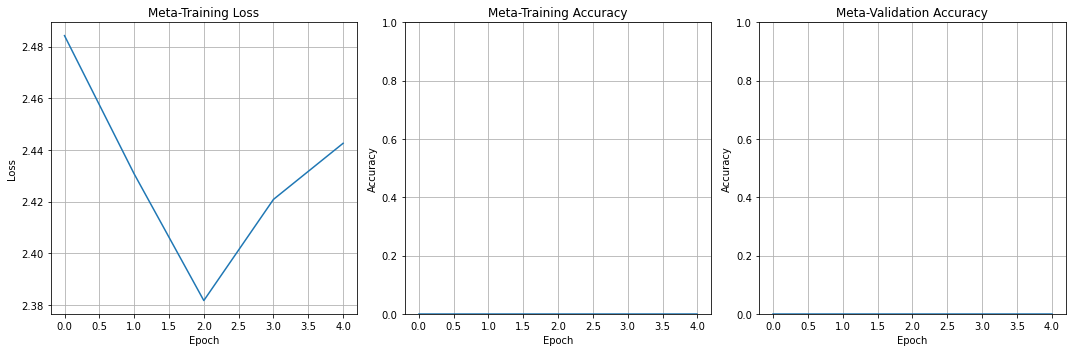

Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.07it/s, avg_loss=2.4378, loss=1.1821] 


Epoch 6/50 - Loss: 2.4378, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:35<00:00,  2.06it/s, avg_loss=2.4635, loss=1.1715] 


Epoch 7/50 - Loss: 2.4635, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.05it/s, avg_loss=2.3652, loss=1.1191] 


Epoch 8/50 - Loss: 2.3652, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:35<00:00,  2.06it/s, avg_loss=2.4571, loss=1.1645] 


Epoch 9/50 - Loss: 2.4571, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.05it/s, avg_loss=2.4498, loss=1.1189] 


Epoch 10/50 - Loss: 2.4498, Train Acc: 0.0000, Val Acc: 0.0000


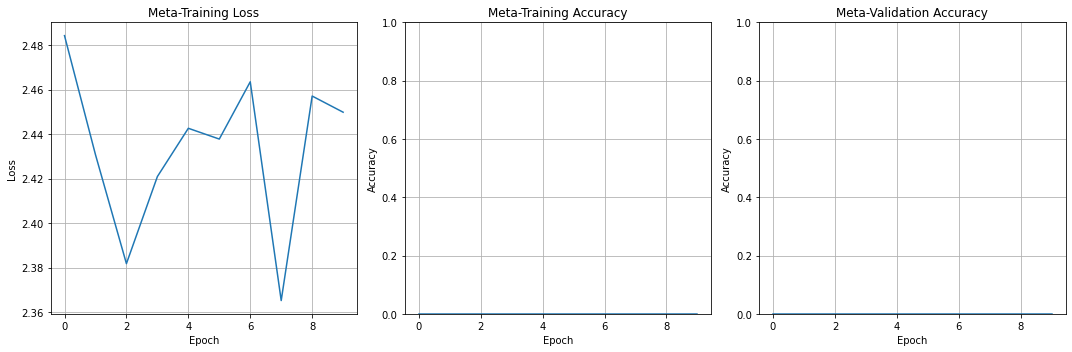

Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.04it/s, avg_loss=2.4822, loss=1.1602] 


Epoch 11/50 - Loss: 2.4822, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=2.4295, loss=1.1484] 


Epoch 12/50 - Loss: 2.4295, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=2.4821, loss=1.1873] 


Epoch 13/50 - Loss: 2.4821, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.4416, loss=1.2036] 


Epoch 14/50 - Loss: 2.4416, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.04it/s, avg_loss=2.4795, loss=1.1571] 


Epoch 15/50 - Loss: 2.4795, Train Acc: 0.0000, Val Acc: 0.0000


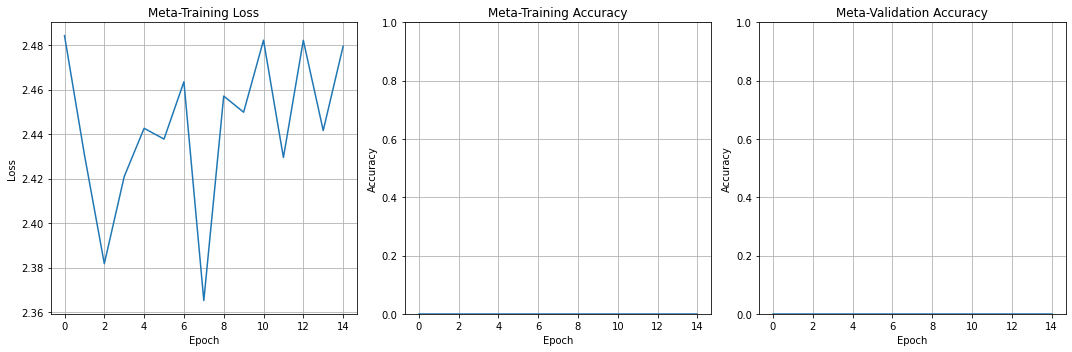

Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.4161, loss=1.1939] 


Epoch 16/50 - Loss: 2.4161, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.4845, loss=1.1418] 


Epoch 17/50 - Loss: 2.4845, Train Acc: 0.0000, Val Acc: 0.0000


IOPub message rate exceeded.  | 61/320 [00:30<02:35,  1.67it/s, avg_loss=2.4357, loss=1.6001] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 33/50 - Loss: 2.4441, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=2.4525, loss=1.2073] 


Epoch 34/50 - Loss: 2.4525, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=2.4365, loss=1.1854] 


Epoch 35/50 - Loss: 2.4365, Train Acc: 0.0000, Val Acc: 0.0125


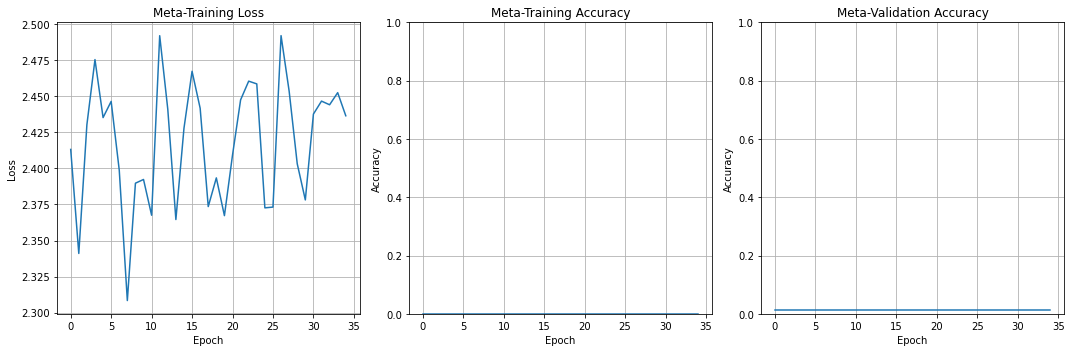

Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.3752, loss=1.1729] 


Epoch 36/50 - Loss: 2.3752, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.00it/s, avg_loss=2.4126, loss=1.1664] 


Epoch 37/50 - Loss: 2.4126, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.5015, loss=1.1303] 


Epoch 38/50 - Loss: 2.5015, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.4060, loss=1.1651] 


Epoch 39/50 - Loss: 2.4060, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.4990, loss=1.1754] 


Epoch 40/50 - Loss: 2.4990, Train Acc: 0.0000, Val Acc: 0.0125


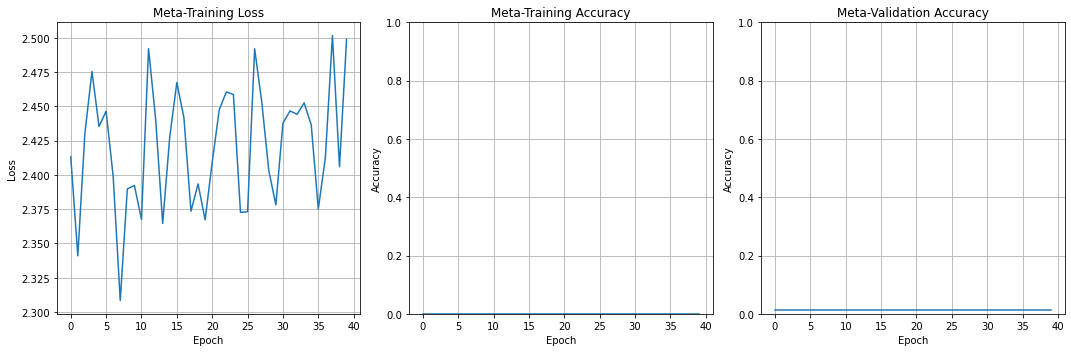

Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.4904, loss=1.1556] 


Epoch 41/50 - Loss: 2.4904, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.4216, loss=1.1742] 


Epoch 42/50 - Loss: 2.4216, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.4191, loss=1.1522] 


Epoch 43/50 - Loss: 2.4191, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.01it/s, avg_loss=2.3827, loss=1.1624] 


Epoch 44/50 - Loss: 2.3827, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.00it/s, avg_loss=2.3686, loss=1.1569] 


Epoch 45/50 - Loss: 2.3686, Train Acc: 0.0000, Val Acc: 0.0125


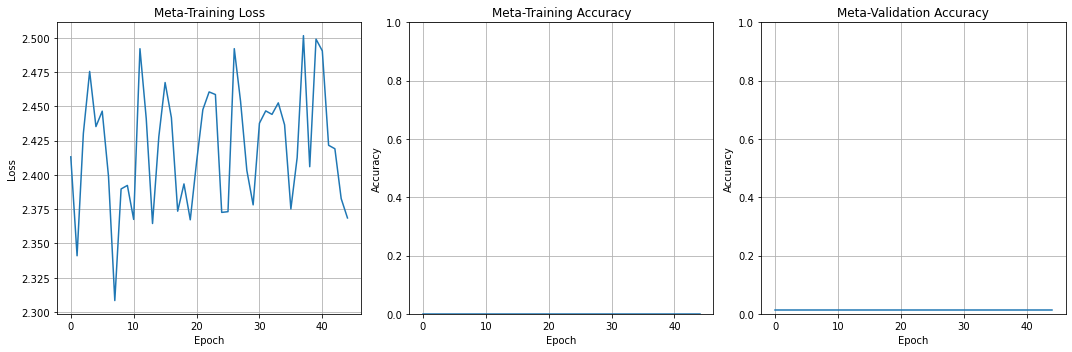

Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.01it/s, avg_loss=2.3579, loss=1.1155] 


Epoch 46/50 - Loss: 2.3579, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.3553, loss=1.1597]


Epoch 47/50 - Loss: 2.3553, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.4460, loss=1.1468] 


Epoch 48/50 - Loss: 2.4460, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.4560, loss=1.1822] 


Epoch 49/50 - Loss: 2.4560, Train Acc: 0.0000, Val Acc: 0.0125


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.3861, loss=1.1767] 


Epoch 50/50 - Loss: 2.3861, Train Acc: 0.0000, Val Acc: 0.0125


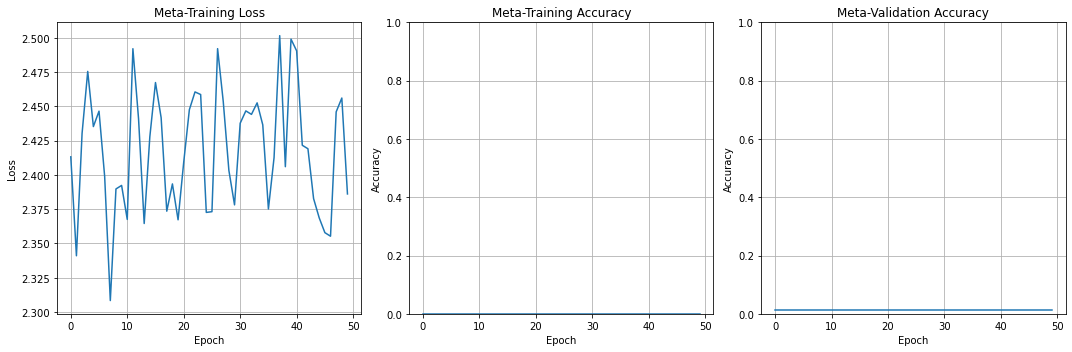

Fold 2 validation accuracy: 0.0125
New best model with validation accuracy: 0.0125, saved to output/models/nlm/maml/fold2_best.pt

--- Training NLM with MAML on Fold 3/5 ---
Loading precomputed tasks from precomputed_tasks/training_400


Loading tasks from precomputed_tasks/training_400: 100%|██████████| 400/400 [00:02<00:00, 162.35it/s]


Loaded 400 precomputed tasks
Train tasks: 320, Validation tasks: 80
Model state loaded from output/models/nlm/nlm_reasoning_module_final.pt
Model weights loaded successfully


Training MAML: 100%|██████████| 320/320 [02:28<00:00,  2.15it/s, avg_loss=2.3090, loss=1.2024] 


Epoch 1/50 - Loss: 2.3090, Train Acc: 0.0000, Val Acc: 0.0000


IOPub message rate exceeded.  | 92/320 [00:42<01:28,  2.58it/s, avg_loss=2.3472, loss=5.6374] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Training MAML: 100%|██████████| 320/320 [02:35<00:00,  2.05it/s, avg_loss=2.3325, loss=1.1396] 


Epoch 6/50 - Loss: 2.3325, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=2.3591, loss=1.1588] 


Epoch 7/50 - Loss: 2.3591, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.04it/s, avg_loss=2.3428, loss=1.1575] 


Epoch 8/50 - Loss: 2.3428, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.3440, loss=1.2015] 


Epoch 9/50 - Loss: 2.3440, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.3609, loss=1.1685] 


Epoch 10/50 - Loss: 2.3609, Train Acc: 0.0000, Val Acc: 0.0000


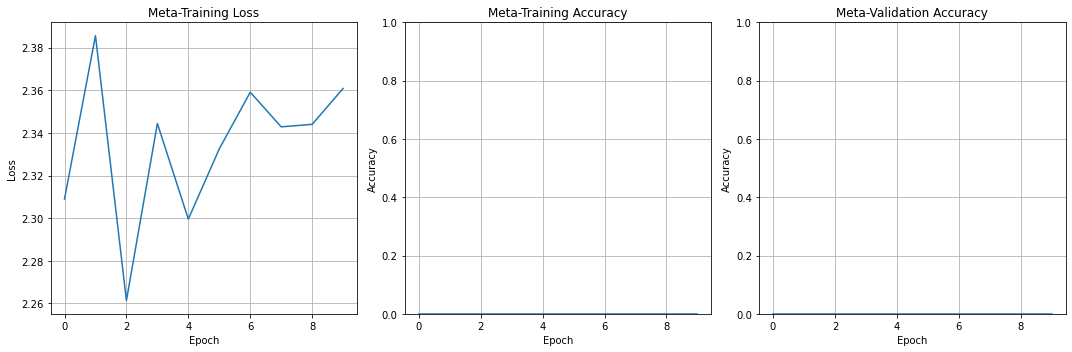

Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.3788, loss=1.1519] 


Epoch 11/50 - Loss: 2.3788, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.01it/s, avg_loss=2.3090, loss=1.1639] 


Epoch 12/50 - Loss: 2.3090, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.3879, loss=1.1496] 


Epoch 13/50 - Loss: 2.3879, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.3443, loss=1.1654] 


Epoch 14/50 - Loss: 2.3443, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.3452, loss=1.1297] 


Epoch 15/50 - Loss: 2.3452, Train Acc: 0.0000, Val Acc: 0.0000


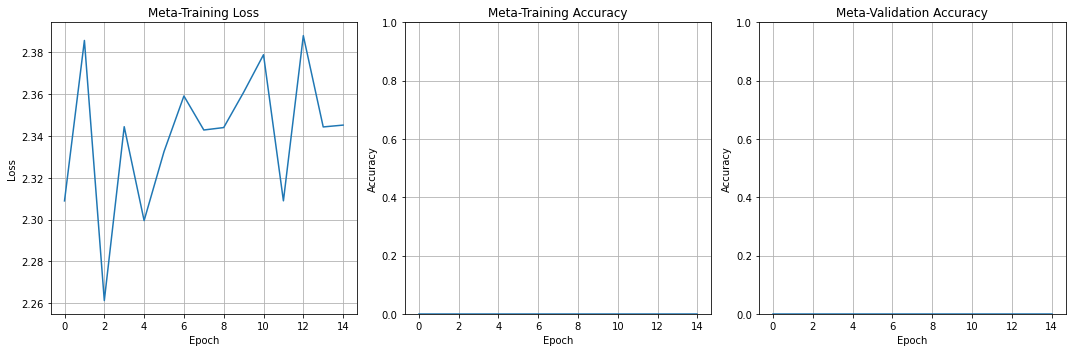

Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.3305, loss=1.1511] 


Epoch 16/50 - Loss: 2.3305, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.3733, loss=1.1654] 


Epoch 17/50 - Loss: 2.3733, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML:  98%|█████████▊| 314/320 [02:34<00:02,  2.04it/s, avg_loss=2.3659, loss=3.9781] 

Epoch 18/50 - Loss: 2.3495, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=2.3039, loss=1.1982] 


Epoch 19/50 - Loss: 2.3039, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.3163, loss=1.1881] 


Epoch 20/50 - Loss: 2.3163, Train Acc: 0.0000, Val Acc: 0.0000


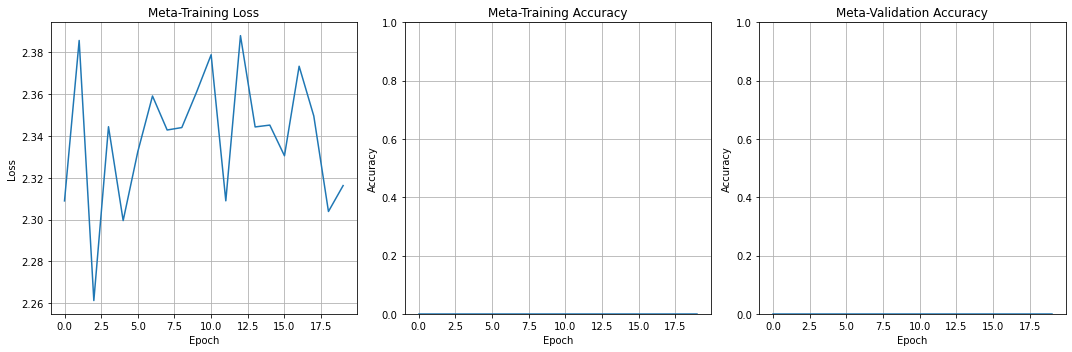

Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.2940, loss=1.1572] 


Epoch 21/50 - Loss: 2.2940, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=2.3435, loss=1.1061] 


Epoch 22/50 - Loss: 2.3435, Train Acc: 0.0000, Val Acc: 0.0000


IOPub message rate exceeded.  | 210/320 [01:44<00:50,  2.18it/s, avg_loss=2.5371, loss=2.4349] 
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 22/50 - Loss: 2.6069, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML:  92%|█████████▏| 293/320 [02:25<00:15,  1.77it/s, avg_loss=2.5799, loss=2.3749] 

Epoch 23/50 - Loss: 2.5619, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.6042, loss=1.8386] 


Epoch 24/50 - Loss: 2.6042, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.6902, loss=1.8971] 


Epoch 25/50 - Loss: 2.6902, Train Acc: 0.0000, Val Acc: 0.0000


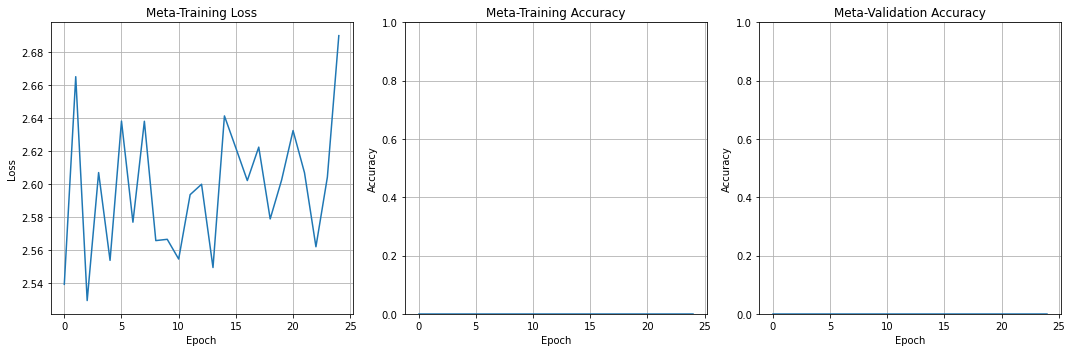

Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.00it/s, avg_loss=2.6013, loss=1.7997] 


Epoch 26/50 - Loss: 2.6013, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  2.00it/s, avg_loss=2.6082, loss=1.8395] 


Epoch 27/50 - Loss: 2.6082, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.00it/s, avg_loss=2.6011, loss=1.8488] 


Epoch 28/50 - Loss: 2.6011, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  2.00it/s, avg_loss=2.6056, loss=1.8521] 


Epoch 29/50 - Loss: 2.6056, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.00it/s, avg_loss=2.5345, loss=1.8575] 


Epoch 30/50 - Loss: 2.5345, Train Acc: 0.0000, Val Acc: 0.0000


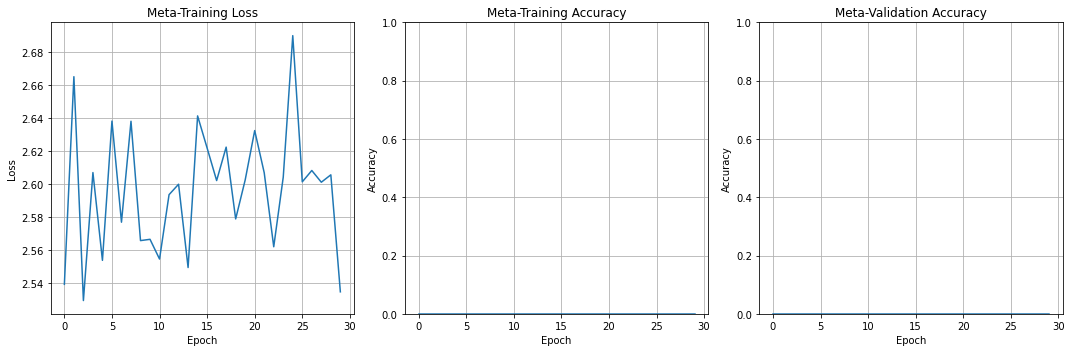

Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.00it/s, avg_loss=2.6162, loss=1.8874] 


Epoch 31/50 - Loss: 2.6162, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  2.00it/s, avg_loss=2.5824, loss=1.8520] 


Epoch 32/50 - Loss: 2.5824, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=2.6136, loss=1.8427] 


Epoch 33/50 - Loss: 2.6136, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=2.6129, loss=1.8490] 


Epoch 34/50 - Loss: 2.6129, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:41<00:00,  1.99it/s, avg_loss=2.5923, loss=1.8937] 


Epoch 35/50 - Loss: 2.5923, Train Acc: 0.0000, Val Acc: 0.0000


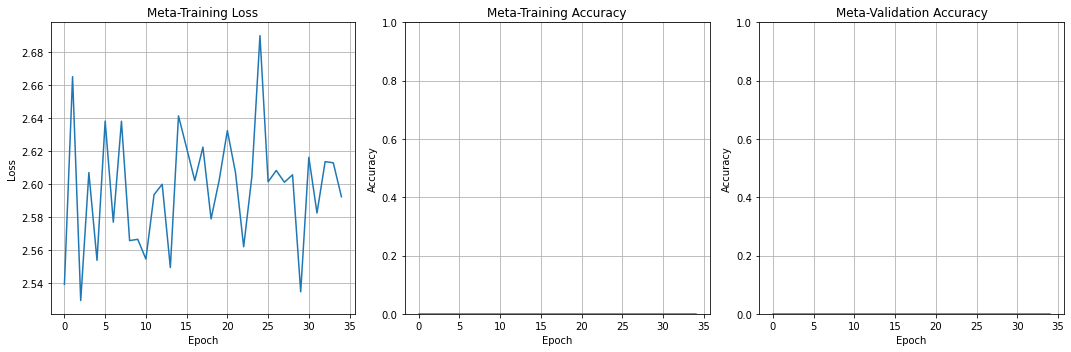

Training MAML: 100%|██████████| 320/320 [02:40<00:00,  2.00it/s, avg_loss=2.6028, loss=1.8807] 


Epoch 36/50 - Loss: 2.6028, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:41<00:00,  1.98it/s, avg_loss=2.5574, loss=1.9254] 


Epoch 37/50 - Loss: 2.5574, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:41<00:00,  1.99it/s, avg_loss=2.5749, loss=1.8584] 


Epoch 38/50 - Loss: 2.5749, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=2.5210, loss=1.8820] 


Epoch 39/50 - Loss: 2.5210, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:41<00:00,  1.98it/s, avg_loss=2.5930, loss=1.9074] 


Epoch 40/50 - Loss: 2.5930, Train Acc: 0.0000, Val Acc: 0.0000


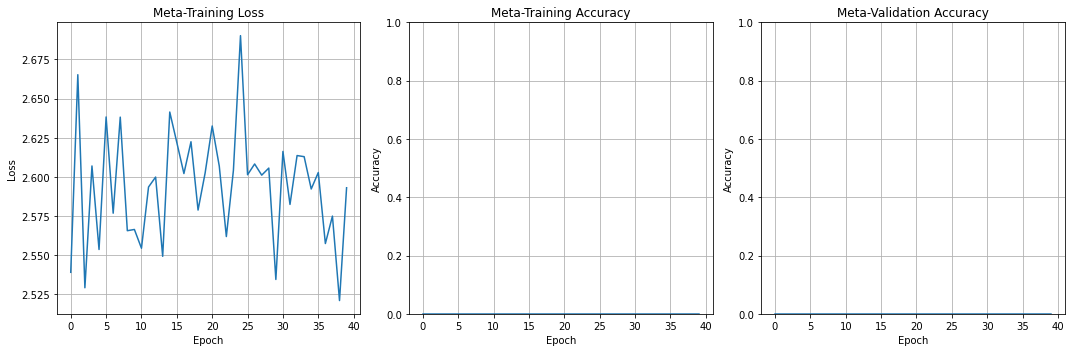

Training MAML: 100%|██████████| 320/320 [02:41<00:00,  1.98it/s, avg_loss=2.6338, loss=1.8708] 


Epoch 41/50 - Loss: 2.6338, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:41<00:00,  1.98it/s, avg_loss=2.5641, loss=1.8510] 


Epoch 42/50 - Loss: 2.5641, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=2.7294, loss=1.8275] 


Epoch 43/50 - Loss: 2.7294, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=2.5752, loss=1.8574] 


Epoch 44/50 - Loss: 2.5752, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=2.5194, loss=1.8309] 


Epoch 45/50 - Loss: 2.5194, Train Acc: 0.0000, Val Acc: 0.0000


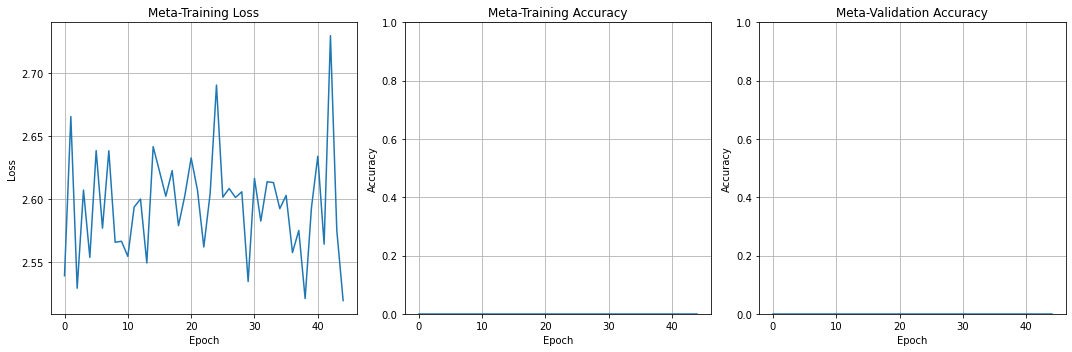

Training MAML: 100%|██████████| 320/320 [02:40<00:00,  2.00it/s, avg_loss=2.5195, loss=1.8751] 


Epoch 46/50 - Loss: 2.5195, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  2.00it/s, avg_loss=2.6080, loss=1.8302] 


Epoch 47/50 - Loss: 2.6080, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:41<00:00,  1.98it/s, avg_loss=2.5412, loss=1.8564] 


Epoch 48/50 - Loss: 2.5412, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=2.6008, loss=1.8561] 


Epoch 49/50 - Loss: 2.6008, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=2.6539, loss=1.8546] 


Epoch 50/50 - Loss: 2.6539, Train Acc: 0.0000, Val Acc: 0.0000


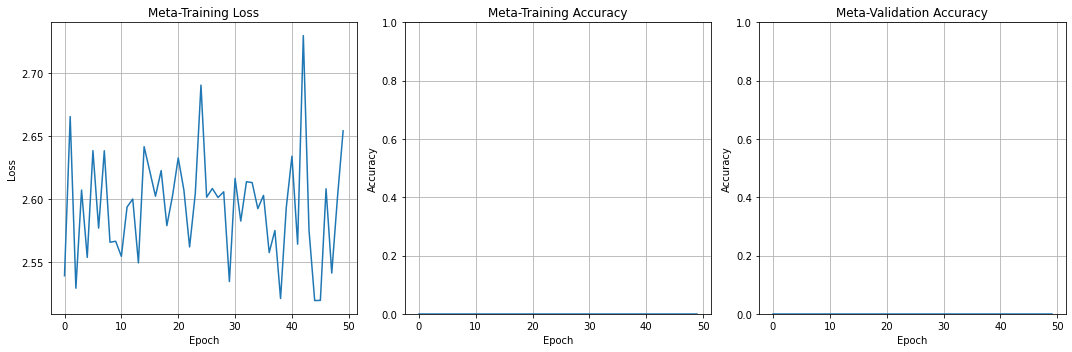

Fold 5 validation accuracy: 0.0000

NLM with MAML: Average validation accuracy across 5 folds: 0.0025
Loading precomputed tasks from precomputed_tasks/evaluation_400


Loading tasks from precomputed_tasks/evaluation_400: 100%|██████████| 400/400 [00:02<00:00, 135.38it/s]


Loaded 400 precomputed tasks
Evaluating best NLM model with MAML on 400 test tasks...
Best NLM model with MAML test accuracy: 0.0000
Metrics saved to output/metrics/nlm/maml_metrics.json
Plot saved to output/metrics/nlm/maml_results.png


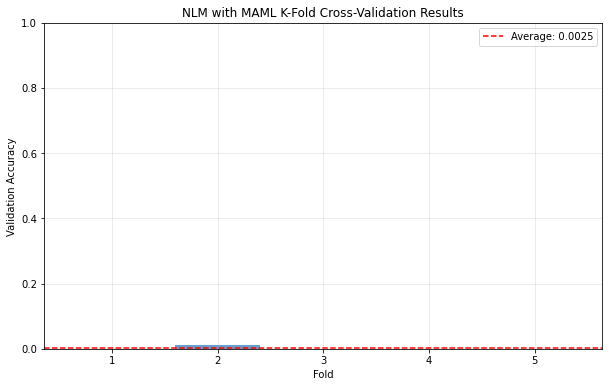

Loading precomputed tasks from precomputed_tasks/training_400


Loading tasks from precomputed_tasks/training_400: 100%|██████████| 400/400 [00:02<00:00, 172.33it/s]


Loaded 400 precomputed tasks

--- Training UNIFIED with MAML on Fold 1/5 ---
Loading precomputed tasks from precomputed_tasks/training_400


Loading tasks from precomputed_tasks/training_400: 100%|██████████| 400/400 [00:02<00:00, 166.69it/s]


Loaded 400 precomputed tasks
Train tasks: 320, Validation tasks: 80
Model state loaded from output/models/unified/unified_reasoning_model_final.pt
Model weights loaded successfully


Training MAML: 100%|██████████| 320/320 [03:05<00:00,  1.73it/s, avg_loss=8.3879, loss=22.9163] 


Epoch 1/50 - Loss: 8.3879, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:41<00:00,  1.44it/s, avg_loss=8.2030, loss=26.8516] 


Epoch 2/50 - Loss: 8.2030, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:29<00:00,  1.52it/s, avg_loss=8.1894, loss=24.4704] 


Epoch 3/50 - Loss: 8.1894, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:41<00:00,  1.45it/s, avg_loss=8.5977, loss=26.3463] 


Epoch 4/50 - Loss: 8.5977, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:01<00:00,  1.77it/s, avg_loss=8.1539, loss=23.4754] 


Epoch 5/50 - Loss: 8.1539, Train Acc: 0.0000, Val Acc: 0.0000


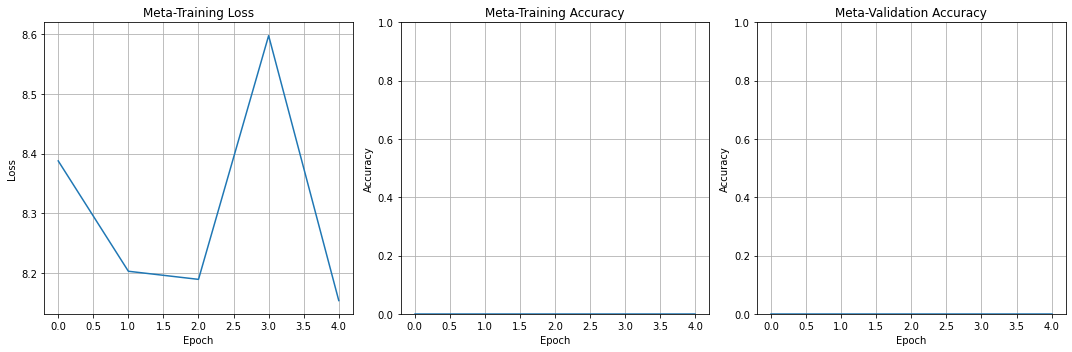

Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.13it/s, avg_loss=7.7064, loss=24.5552]


Epoch 6/50 - Loss: 7.7064, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:29<00:00,  2.13it/s, avg_loss=7.7058, loss=24.1184] 


Epoch 7/50 - Loss: 7.7058, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.13it/s, avg_loss=7.4297, loss=27.8875]


Epoch 8/50 - Loss: 7.4297, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:31<00:00,  2.12it/s, avg_loss=8.1190, loss=24.2353] 


Epoch 9/50 - Loss: 8.1190, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:29<00:00,  2.14it/s, avg_loss=7.4104, loss=24.2710]


Epoch 10/50 - Loss: 7.4104, Train Acc: 0.0000, Val Acc: 0.0000


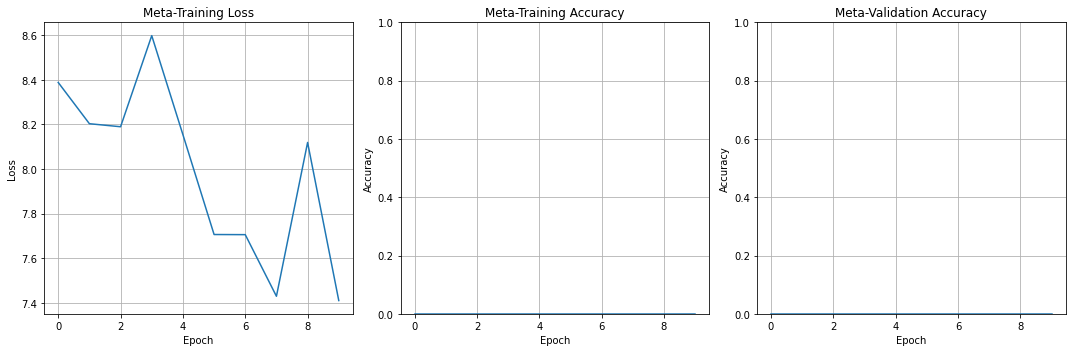

Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.13it/s, avg_loss=7.9460, loss=19.8632] 


Epoch 11/50 - Loss: 7.9460, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.13it/s, avg_loss=7.5624, loss=24.3477] 


Epoch 12/50 - Loss: 7.5624, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:31<00:00,  2.12it/s, avg_loss=7.3592, loss=25.9677] 


Epoch 13/50 - Loss: 7.3592, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.13it/s, avg_loss=7.4328, loss=24.7798]


Epoch 14/50 - Loss: 7.4328, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:31<00:00,  2.11it/s, avg_loss=7.1167, loss=24.0738] 


Epoch 15/50 - Loss: 7.1167, Train Acc: 0.0000, Val Acc: 0.0000


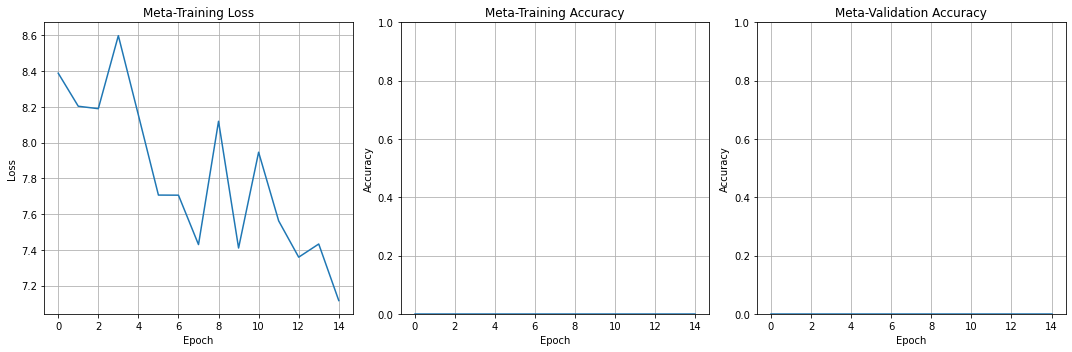

Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.13it/s, avg_loss=7.2970, loss=24.1349] 


Epoch 16/50 - Loss: 7.2970, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.12it/s, avg_loss=7.3818, loss=25.2138] 


Epoch 17/50 - Loss: 7.3818, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.12it/s, avg_loss=6.8328, loss=25.8417]


Epoch 18/50 - Loss: 6.8328, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.12it/s, avg_loss=7.0594, loss=25.1903]


Epoch 19/50 - Loss: 7.0594, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:32<00:00,  2.10it/s, avg_loss=7.4133, loss=24.1544] 


Epoch 20/50 - Loss: 7.4133, Train Acc: 0.0000, Val Acc: 0.0000


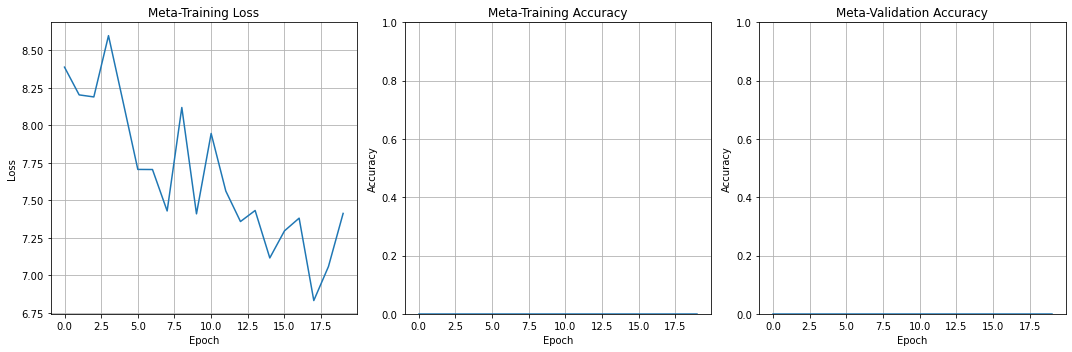

Training MAML: 100%|██████████| 320/320 [02:32<00:00,  2.10it/s, avg_loss=6.7853, loss=23.5136]


Epoch 21/50 - Loss: 6.7853, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:58<00:00,  1.79it/s, avg_loss=6.9304, loss=24.1891] 


Epoch 22/50 - Loss: 6.9304, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:54<00:00,  1.84it/s, avg_loss=6.7837, loss=20.6301] 


Epoch 23/50 - Loss: 6.7837, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.93it/s, avg_loss=6.8536, loss=26.3332] 


Epoch 24/50 - Loss: 6.8536, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=6.6745, loss=22.4647] 


Epoch 25/50 - Loss: 6.6745, Train Acc: 0.0000, Val Acc: 0.0000


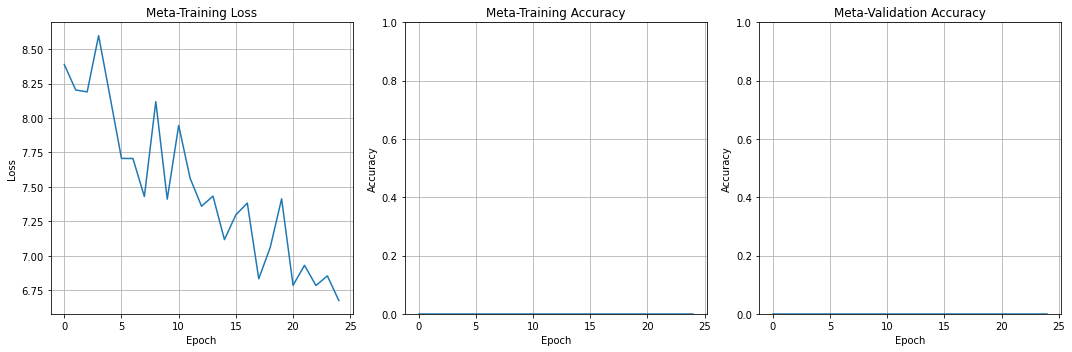

Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.92it/s, avg_loss=6.7016, loss=24.9981] 


Epoch 26/50 - Loss: 6.7016, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:32<00:00,  2.10it/s, avg_loss=6.1906, loss=21.0176]


Epoch 27/50 - Loss: 6.1906, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.93it/s, avg_loss=6.5637, loss=22.3500] 


Epoch 28/50 - Loss: 6.5637, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:32<00:00,  2.09it/s, avg_loss=6.1023, loss=27.4652] 


Epoch 30/50 - Loss: 6.1023, Train Acc: 0.0000, Val Acc: 0.0000


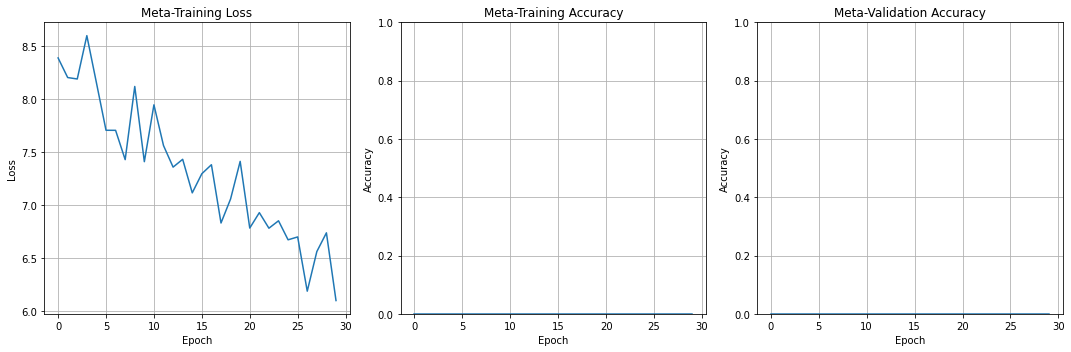

Training MAML: 100%|██████████| 320/320 [03:55<00:00,  1.36it/s, avg_loss=6.2131, loss=20.7643]


Epoch 31/50 - Loss: 6.2131, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:54<00:00,  1.37it/s, avg_loss=6.0325, loss=20.8754]


Epoch 32/50 - Loss: 6.0325, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:27<00:00,  1.54it/s, avg_loss=6.1875, loss=26.6826] 


Epoch 33/50 - Loss: 6.1875, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:17<00:00,  1.62it/s, avg_loss=6.4316, loss=22.4977] 


Epoch 34/50 - Loss: 6.4316, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:27<00:00,  1.54it/s, avg_loss=6.1895, loss=22.3016] 


Epoch 35/50 - Loss: 6.1895, Train Acc: 0.0000, Val Acc: 0.0000


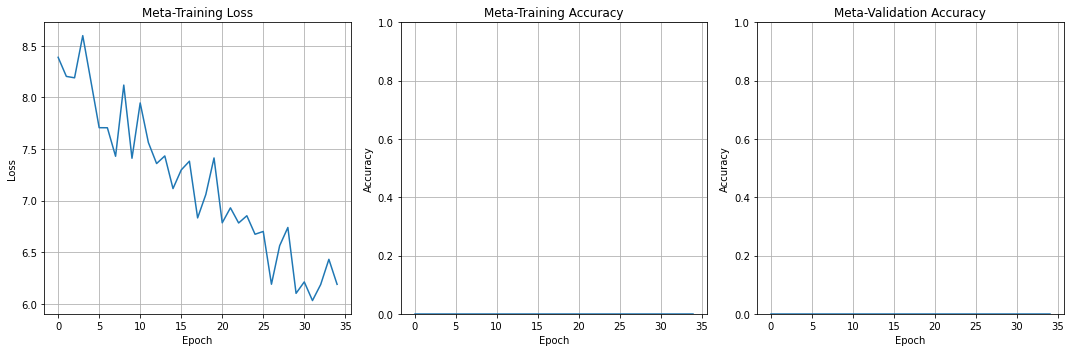

Training MAML: 100%|██████████| 320/320 [03:58<00:00,  1.34it/s, avg_loss=6.2923, loss=24.2928] 


Epoch 36/50 - Loss: 6.2923, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:58<00:00,  1.34it/s, avg_loss=5.8978, loss=25.3896] 


Epoch 37/50 - Loss: 5.8978, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:58<00:00,  1.34it/s, avg_loss=6.4473, loss=22.1343] 


Epoch 38/50 - Loss: 6.4473, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [04:00<00:00,  1.33it/s, avg_loss=5.6382, loss=24.6307]


Epoch 39/50 - Loss: 5.6382, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:59<00:00,  1.34it/s, avg_loss=6.1621, loss=25.0265] 


Epoch 40/50 - Loss: 6.1621, Train Acc: 0.0000, Val Acc: 0.0000


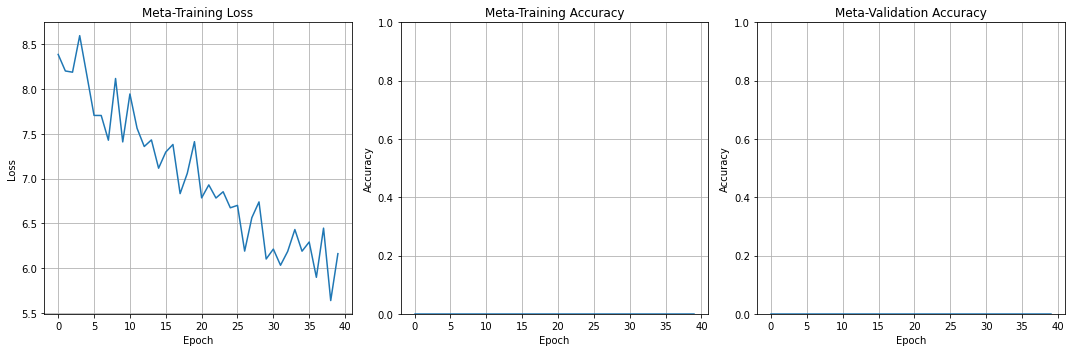

Training MAML: 100%|██████████| 320/320 [03:56<00:00,  1.35it/s, avg_loss=5.8495, loss=26.7371] 


Epoch 41/50 - Loss: 5.8495, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:41<00:00,  1.45it/s, avg_loss=6.1056, loss=26.0263] 


Epoch 42/50 - Loss: 6.1056, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=5.6036, loss=19.5965]


Epoch 43/50 - Loss: 5.6036, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=5.9195, loss=20.6199] 


Epoch 44/50 - Loss: 5.9195, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=5.8146, loss=24.7946] 


Epoch 45/50 - Loss: 5.8146, Train Acc: 0.0000, Val Acc: 0.0000


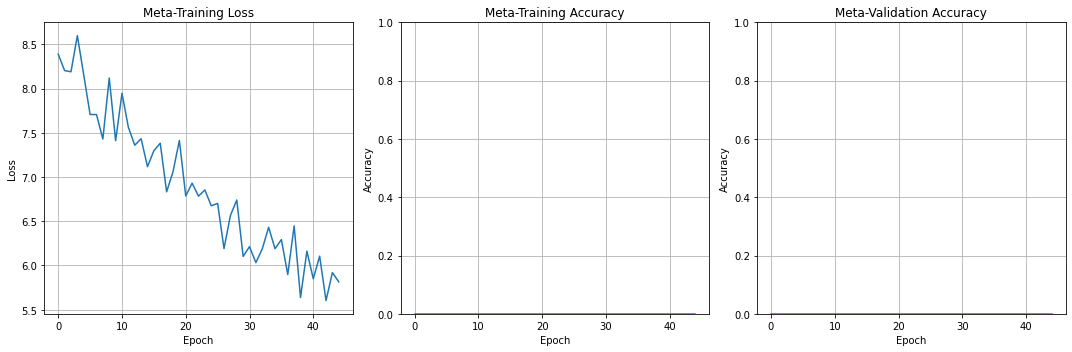

Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=5.7120, loss=21.5763] 


Epoch 46/50 - Loss: 5.7120, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=5.5675, loss=24.2797] 


Epoch 47/50 - Loss: 5.5675, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.04it/s, avg_loss=5.6890, loss=26.4065] 


Epoch 48/50 - Loss: 5.6890, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.04it/s, avg_loss=5.6264, loss=24.3608]


Epoch 49/50 - Loss: 5.6264, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=5.4405, loss=24.5208] 


Epoch 50/50 - Loss: 5.4405, Train Acc: 0.0000, Val Acc: 0.0000


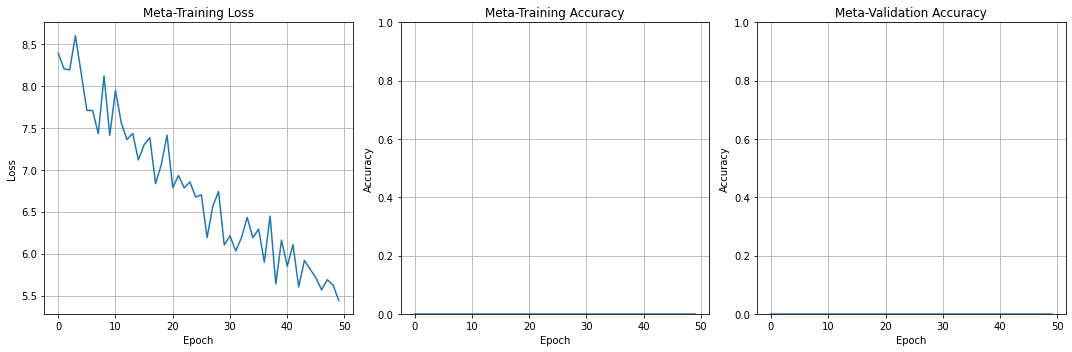

Fold 1 validation accuracy: 0.0000

--- Training UNIFIED with MAML on Fold 2/5 ---
Loading precomputed tasks from precomputed_tasks/training_400


Loading tasks from precomputed_tasks/training_400: 100%|██████████| 400/400 [00:02<00:00, 170.17it/s]


Loaded 400 precomputed tasks
Train tasks: 320, Validation tasks: 80
Model state loaded from output/models/unified/unified_reasoning_model_final.pt
Model weights loaded successfully


Training MAML: 100%|██████████| 320/320 [02:52<00:00,  1.86it/s, avg_loss=9.2381, loss=22.5323] 


Epoch 1/50 - Loss: 9.2381, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.30it/s, avg_loss=8.9017, loss=23.0145] 


Epoch 2/50 - Loss: 8.9017, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:13<00:00,  2.40it/s, avg_loss=8.8102, loss=25.0022] 


Epoch 3/50 - Loss: 8.8102, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=8.8202, loss=24.0049] 


Epoch 4/50 - Loss: 8.8202, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:25<00:00,  2.19it/s, avg_loss=8.5795, loss=22.7967] 


Epoch 5/50 - Loss: 8.5795, Train Acc: 0.0000, Val Acc: 0.0000


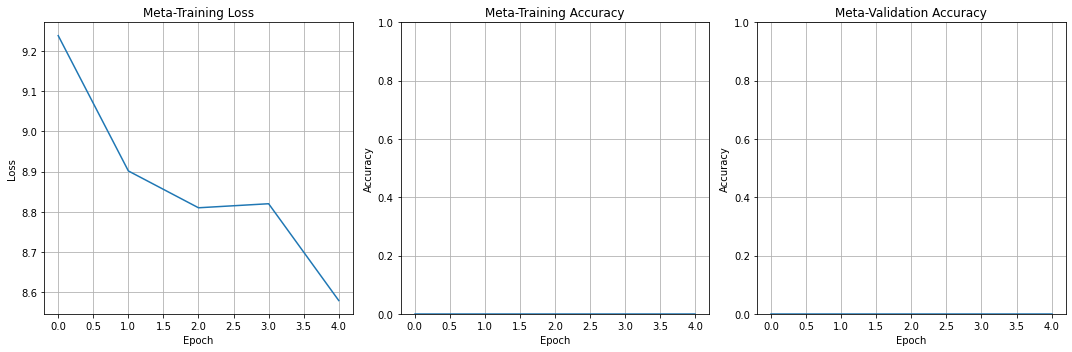

Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.31it/s, avg_loss=8.4687, loss=22.3347] 


Epoch 6/50 - Loss: 8.4687, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:28<00:00,  2.16it/s, avg_loss=8.8698, loss=27.3950] 


Epoch 7/50 - Loss: 8.8698, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.13it/s, avg_loss=8.4938, loss=22.7314] 


Epoch 8/50 - Loss: 8.4938, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:29<00:00,  2.14it/s, avg_loss=8.2953, loss=21.0721] 


Epoch 9/50 - Loss: 8.2953, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.12it/s, avg_loss=8.2220, loss=21.5994] 


Epoch 10/50 - Loss: 8.2220, Train Acc: 0.0000, Val Acc: 0.0000


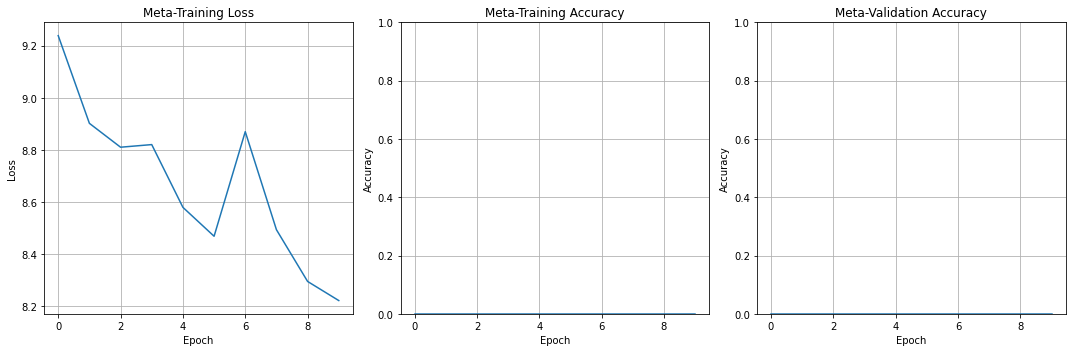

Training MAML: 100%|██████████| 320/320 [02:29<00:00,  2.14it/s, avg_loss=8.0299, loss=23.3884]


Epoch 11/50 - Loss: 8.0299, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:29<00:00,  2.14it/s, avg_loss=8.2106, loss=23.4255] 


Epoch 12/50 - Loss: 8.2106, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.13it/s, avg_loss=7.9628, loss=24.5254]


Epoch 13/50 - Loss: 7.9628, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:32<00:00,  2.09it/s, avg_loss=8.1565, loss=24.0622] 


Epoch 14/50 - Loss: 8.1565, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:29<00:00,  2.14it/s, avg_loss=8.0156, loss=24.4335] 


Epoch 15/50 - Loss: 8.0156, Train Acc: 0.0000, Val Acc: 0.0000


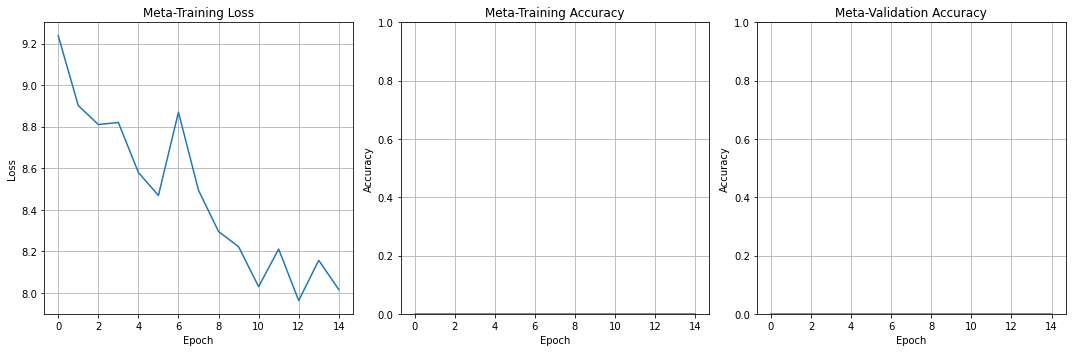

Training MAML: 100%|██████████| 320/320 [02:29<00:00,  2.14it/s, avg_loss=7.7604, loss=26.2051]


Epoch 16/50 - Loss: 7.7604, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:30<00:00,  2.13it/s, avg_loss=7.1611, loss=5.9747] 


Epoch 17/50 - Loss: 7.1611, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:28<00:00,  2.16it/s, avg_loss=7.4105, loss=6.7870]  


Epoch 18/50 - Loss: 7.4105, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.26it/s, avg_loss=7.3109, loss=6.3766] 


Epoch 19/50 - Loss: 7.3109, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:20<00:00,  2.28it/s, avg_loss=7.1830, loss=8.1231] 


Epoch 20/50 - Loss: 7.1830, Train Acc: 0.0000, Val Acc: 0.0000


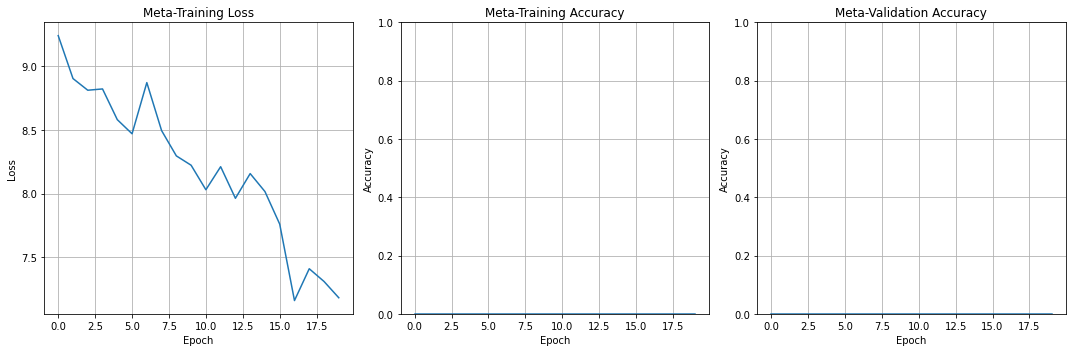

Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.27it/s, avg_loss=7.0816, loss=7.7441] 


Epoch 21/50 - Loss: 7.0816, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:23<00:00,  2.23it/s, avg_loss=7.2020, loss=6.0398] 


Epoch 22/50 - Loss: 7.2020, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:24<00:00,  2.21it/s, avg_loss=7.1137, loss=6.2846] 


Epoch 23/50 - Loss: 7.1137, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=7.1267, loss=5.9205] 


Epoch 24/50 - Loss: 7.1267, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:20<00:00,  2.27it/s, avg_loss=6.9958, loss=7.8554] 


Epoch 25/50 - Loss: 6.9958, Train Acc: 0.0000, Val Acc: 0.0000


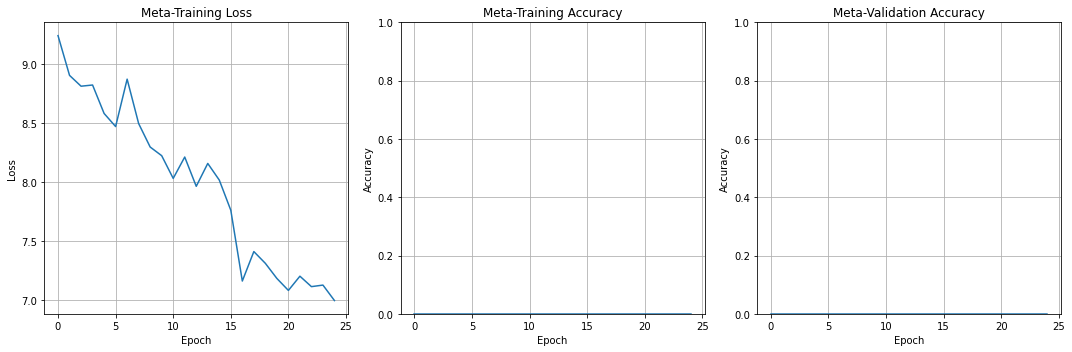

Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.31it/s, avg_loss=6.9040, loss=6.6713] 


Epoch 26/50 - Loss: 6.9040, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.31it/s, avg_loss=6.8506, loss=7.2107] 


Epoch 27/50 - Loss: 6.8506, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.31it/s, avg_loss=6.9477, loss=5.9690] 


Epoch 28/50 - Loss: 6.9477, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.31it/s, avg_loss=6.5667, loss=7.7201] 


Epoch 29/50 - Loss: 6.5667, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:18<00:00,  2.30it/s, avg_loss=6.6596, loss=8.3144] 


Epoch 30/50 - Loss: 6.6596, Train Acc: 0.0000, Val Acc: 0.0000


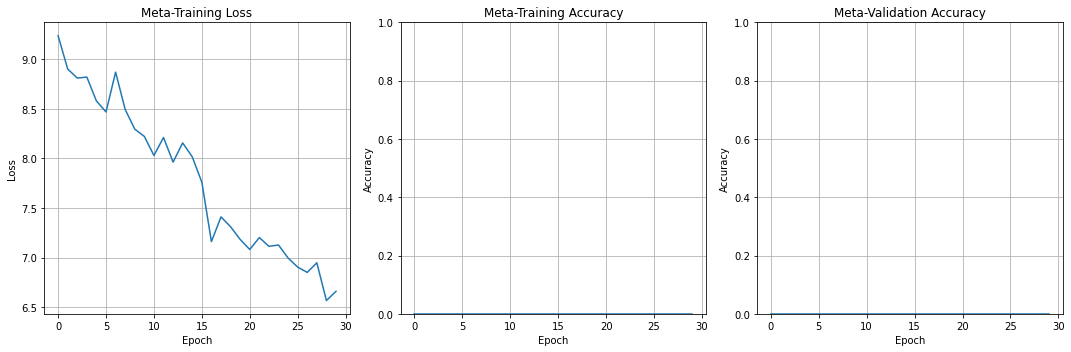

Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.30it/s, avg_loss=6.5079, loss=6.4469]  


Epoch 31/50 - Loss: 6.5079, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:15<00:00,  2.36it/s, avg_loss=6.5381, loss=6.5512] 


Epoch 32/50 - Loss: 6.5381, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.29it/s, avg_loss=6.1906, loss=7.6582] 


Epoch 33/50 - Loss: 6.1906, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:19<00:00,  2.29it/s, avg_loss=6.3574, loss=6.5566] 


Epoch 34/50 - Loss: 6.3574, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:20<00:00,  2.28it/s, avg_loss=6.3909, loss=6.9591]  


Epoch 35/50 - Loss: 6.3909, Train Acc: 0.0000, Val Acc: 0.0000


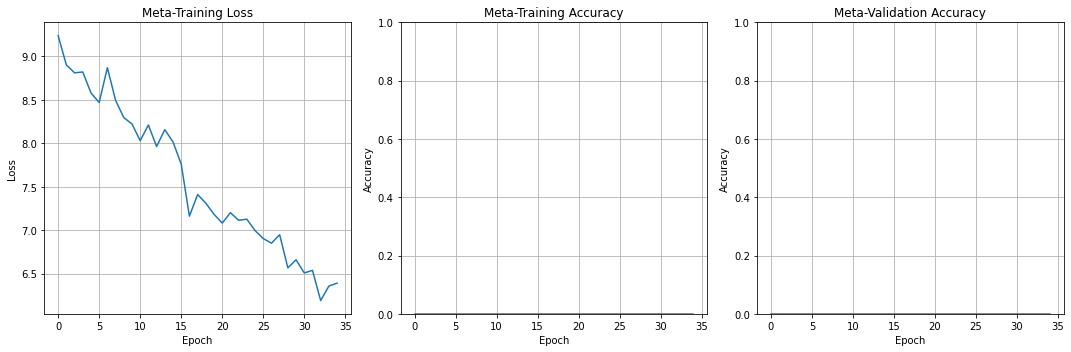

Training MAML: 100%|██████████| 320/320 [02:20<00:00,  2.27it/s, avg_loss=6.2768, loss=6.5121] 


Epoch 36/50 - Loss: 6.2768, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:20<00:00,  2.27it/s, avg_loss=6.2769, loss=5.7590] 


Epoch 37/50 - Loss: 6.2769, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:16<00:00,  2.34it/s, avg_loss=6.2932, loss=5.7588] 


Epoch 38/50 - Loss: 6.2932, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.26it/s, avg_loss=6.3706, loss=6.7539] 


Epoch 39/50 - Loss: 6.3706, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.26it/s, avg_loss=6.0395, loss=4.3530] 


Epoch 40/50 - Loss: 6.0395, Train Acc: 0.0000, Val Acc: 0.0000


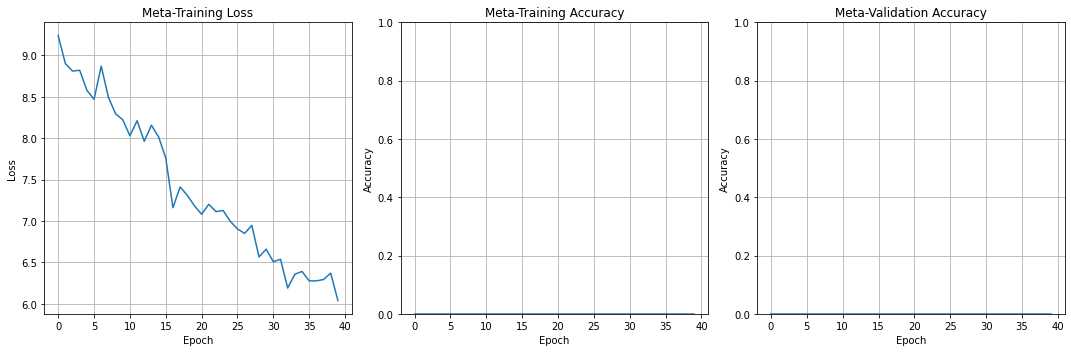

Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.27it/s, avg_loss=6.0006, loss=6.1033] 


Epoch 41/50 - Loss: 6.0006, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.24it/s, avg_loss=6.0267, loss=6.0542] 


Epoch 42/50 - Loss: 6.0267, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:20<00:00,  2.27it/s, avg_loss=5.8417, loss=6.0037] 


Epoch 43/50 - Loss: 5.8417, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:20<00:00,  2.27it/s, avg_loss=5.7662, loss=6.6423] 


Epoch 44/50 - Loss: 5.7662, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.27it/s, avg_loss=5.8524, loss=7.2228] 


Epoch 45/50 - Loss: 5.8524, Train Acc: 0.0000, Val Acc: 0.0000


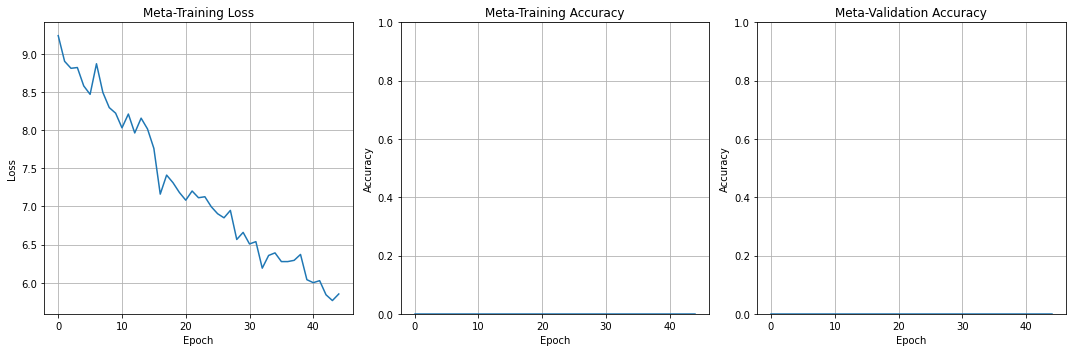

Training MAML: 100%|██████████| 320/320 [02:20<00:00,  2.27it/s, avg_loss=5.7955, loss=5.5136] 


Epoch 46/50 - Loss: 5.7955, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:20<00:00,  2.28it/s, avg_loss=6.0212, loss=6.2265] 


Epoch 47/50 - Loss: 6.0212, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.26it/s, avg_loss=5.7485, loss=12.5018]


Epoch 48/50 - Loss: 5.7485, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:21<00:00,  2.27it/s, avg_loss=5.6653, loss=13.3784]


Epoch 49/50 - Loss: 5.6653, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:22<00:00,  2.25it/s, avg_loss=5.6912, loss=11.1265]


Epoch 50/50 - Loss: 5.6912, Train Acc: 0.0000, Val Acc: 0.0000


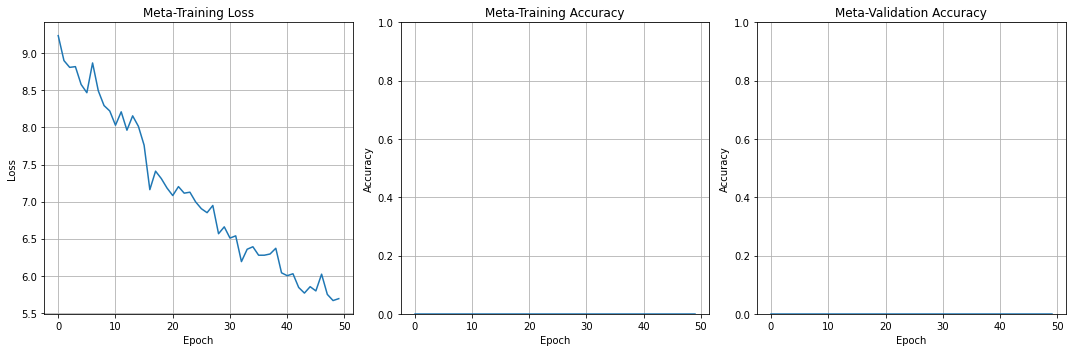

Fold 2 validation accuracy: 0.0000

--- Training UNIFIED with MAML on Fold 3/5 ---
Loading precomputed tasks from precomputed_tasks/training_400


Loading tasks from precomputed_tasks/training_400: 100%|██████████| 400/400 [00:02<00:00, 171.20it/s]


Loaded 400 precomputed tasks
Train tasks: 320, Validation tasks: 80
Model state loaded from output/models/unified/unified_reasoning_model_final.pt
Model weights loaded successfully


Training MAML: 100%|██████████| 320/320 [02:51<00:00,  1.86it/s, avg_loss=8.9337, loss=24.2971] 


Epoch 1/50 - Loss: 8.9337, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:59<00:00,  1.78it/s, avg_loss=9.4940, loss=29.1119] 


Epoch 2/50 - Loss: 9.4940, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:48<00:00,  1.90it/s, avg_loss=8.7159, loss=25.7329] 


Epoch 3/50 - Loss: 8.7159, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:02<00:00,  1.76it/s, avg_loss=8.4526, loss=24.1519] 


Epoch 4/50 - Loss: 8.4526, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:02<00:00,  1.75it/s, avg_loss=8.2113, loss=22.9922] 


Epoch 5/50 - Loss: 8.2113, Train Acc: 0.0000, Val Acc: 0.0000


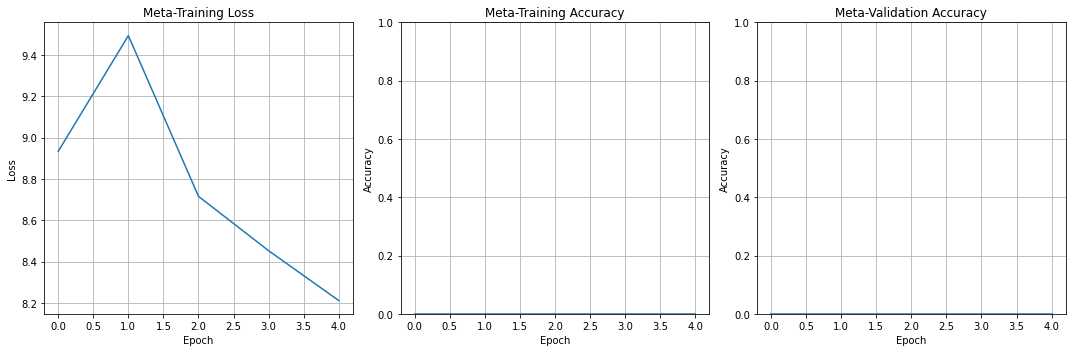

Training MAML: 100%|██████████| 320/320 [02:51<00:00,  1.86it/s, avg_loss=8.1784, loss=27.1156] 


Epoch 6/50 - Loss: 8.1784, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:04<00:00,  1.74it/s, avg_loss=8.0271, loss=23.2837] 


Epoch 7/50 - Loss: 8.0271, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:48<00:00,  1.90it/s, avg_loss=7.5995, loss=25.4731]


Epoch 8/50 - Loss: 7.5995, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.01it/s, avg_loss=8.1546, loss=25.1362] 


Epoch 9/50 - Loss: 8.1546, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:27<00:00,  2.17it/s, avg_loss=7.6644, loss=25.1656]


Epoch 10/50 - Loss: 7.6644, Train Acc: 0.0000, Val Acc: 0.0000


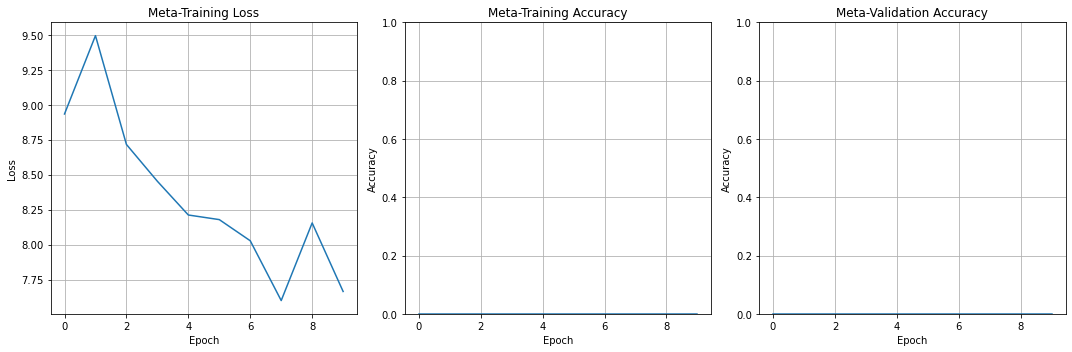

Training MAML: 100%|██████████| 320/320 [02:27<00:00,  2.16it/s, avg_loss=7.9038, loss=20.1152] 


Epoch 11/50 - Loss: 7.9038, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:45<00:00,  1.94it/s, avg_loss=7.8139, loss=23.1437] 


Epoch 12/50 - Loss: 7.8139, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:45<00:00,  1.94it/s, avg_loss=7.6439, loss=23.0599]


Epoch 13/50 - Loss: 7.6439, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:45<00:00,  1.93it/s, avg_loss=7.5978, loss=27.5225] 


Epoch 14/50 - Loss: 7.5978, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.92it/s, avg_loss=7.6503, loss=23.9910] 


Epoch 15/50 - Loss: 7.6503, Train Acc: 0.0000, Val Acc: 0.0000


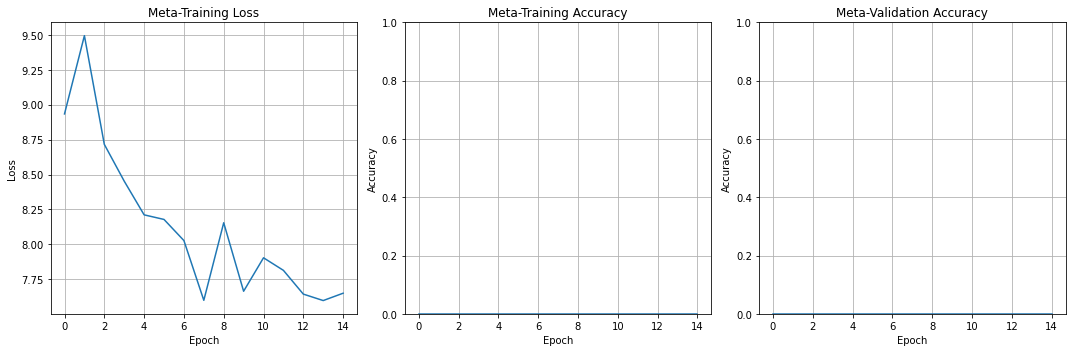

Training MAML: 100%|██████████| 320/320 [02:45<00:00,  1.93it/s, avg_loss=7.5866, loss=25.4884] 


Epoch 16/50 - Loss: 7.5866, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:45<00:00,  1.93it/s, avg_loss=7.4777, loss=23.7321] 


Epoch 17/50 - Loss: 7.4777, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.92it/s, avg_loss=7.7389, loss=25.3819] 


Epoch 18/50 - Loss: 7.7389, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:34<00:00,  2.08it/s, avg_loss=7.2279, loss=21.9911] 


Epoch 19/50 - Loss: 7.2279, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.93it/s, avg_loss=7.1356, loss=23.6240]


Epoch 20/50 - Loss: 7.1356, Train Acc: 0.0000, Val Acc: 0.0000


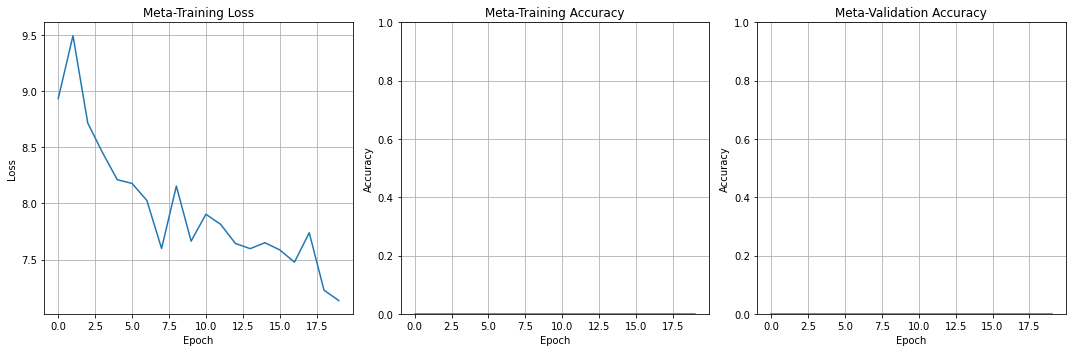

Training MAML: 100%|██████████| 320/320 [02:47<00:00,  1.91it/s, avg_loss=7.5088, loss=22.5526] 


Epoch 21/50 - Loss: 7.5088, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:48<00:00,  1.90it/s, avg_loss=6.8535, loss=20.7127] 


Epoch 22/50 - Loss: 6.8535, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=6.8428, loss=21.7088] 


Epoch 23/50 - Loss: 6.8428, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.92it/s, avg_loss=6.7656, loss=26.1248] 


Epoch 24/50 - Loss: 6.7656, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:35<00:00,  2.06it/s, avg_loss=6.8403, loss=26.9364] 


Epoch 25/50 - Loss: 6.8403, Train Acc: 0.0000, Val Acc: 0.0000


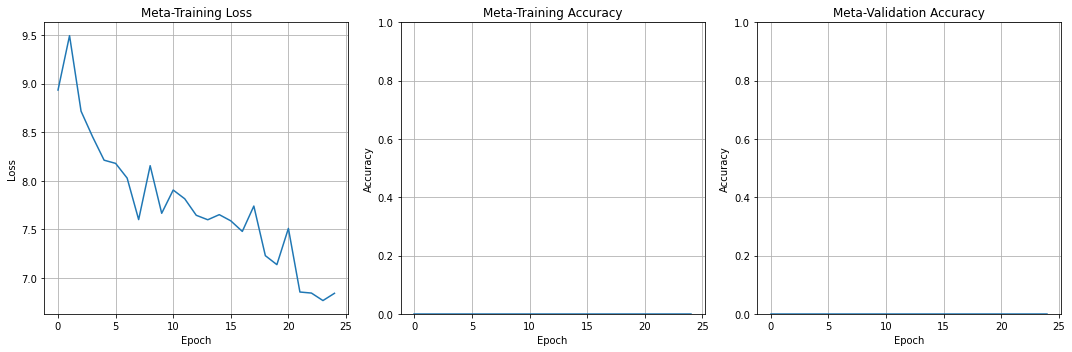

Training MAML: 100%|██████████| 320/320 [02:46<00:00,  1.93it/s, avg_loss=6.9171, loss=5.4145]  


Epoch 26/50 - Loss: 6.9171, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:51<00:00,  1.87it/s, avg_loss=6.8266, loss=6.1088]  


Epoch 27/50 - Loss: 6.8266, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=6.5068, loss=7.5243]  


Epoch 28/50 - Loss: 6.5068, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.02it/s, avg_loss=6.9825, loss=6.4205]  


Epoch 29/50 - Loss: 6.9825, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.00it/s, avg_loss=6.6464, loss=6.6252]  


Epoch 30/50 - Loss: 6.6464, Train Acc: 0.0000, Val Acc: 0.0000


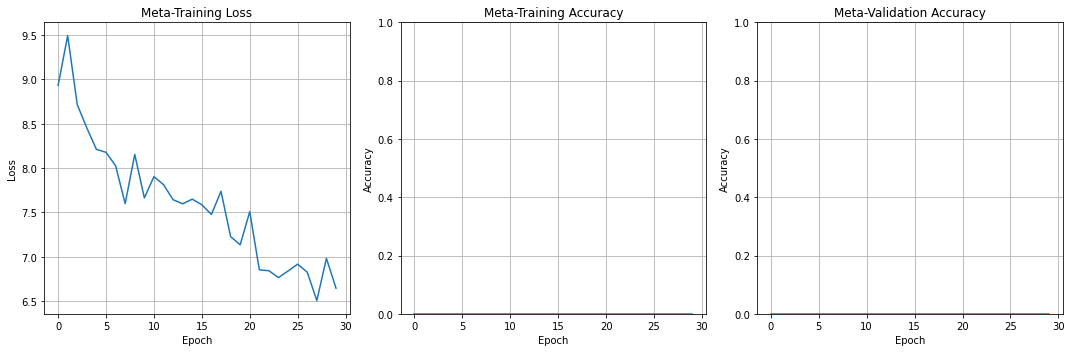

Training MAML: 100%|██████████| 320/320 [02:40<00:00,  1.99it/s, avg_loss=6.1887, loss=7.7017] 


Epoch 31/50 - Loss: 6.1887, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:39<00:00,  2.00it/s, avg_loss=6.1381, loss=5.8044] 


Epoch 32/50 - Loss: 6.1381, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:38<00:00,  2.01it/s, avg_loss=5.9128, loss=6.5618] 


Epoch 33/50 - Loss: 5.9128, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:54<00:00,  1.84it/s, avg_loss=6.2610, loss=6.9953] 


Epoch 34/50 - Loss: 6.2610, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:54<00:00,  1.83it/s, avg_loss=5.7734, loss=6.0389] 


Epoch 35/50 - Loss: 5.7734, Train Acc: 0.0000, Val Acc: 0.0000


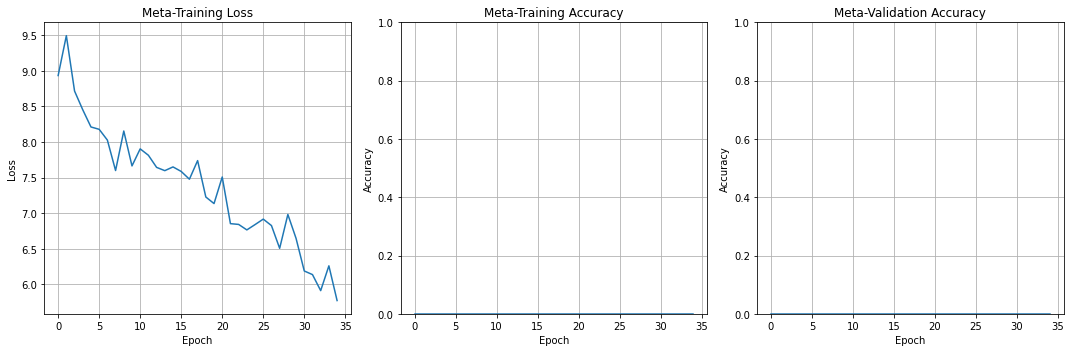

Training MAML: 100%|██████████| 320/320 [02:54<00:00,  1.84it/s, avg_loss=5.6420, loss=7.0159] 


Epoch 36/50 - Loss: 5.6420, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:54<00:00,  1.83it/s, avg_loss=5.7444, loss=5.7419] 


Epoch 37/50 - Loss: 5.7444, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.04it/s, avg_loss=5.7539, loss=5.8381] 


Epoch 38/50 - Loss: 5.7539, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.05it/s, avg_loss=5.5164, loss=7.3462] 


Epoch 39/50 - Loss: 5.5164, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:37<00:00,  2.03it/s, avg_loss=5.7392, loss=6.9620] 


Epoch 40/50 - Loss: 5.7392, Train Acc: 0.0000, Val Acc: 0.0000


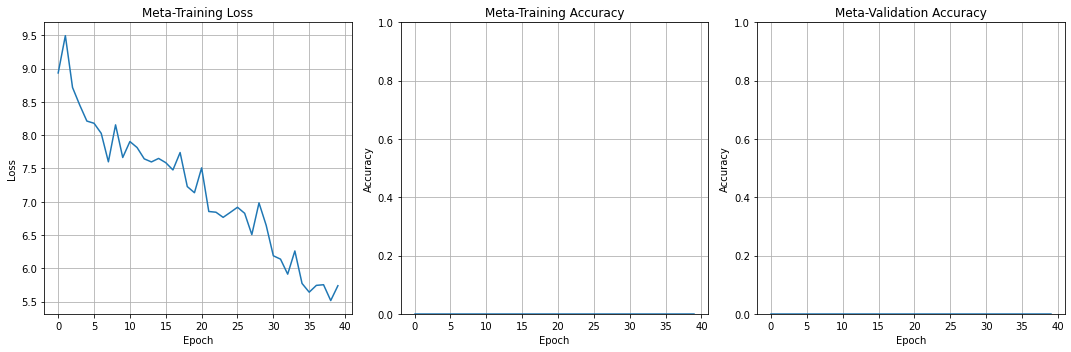

Training MAML: 100%|██████████| 320/320 [02:36<00:00,  2.05it/s, avg_loss=5.6005, loss=6.7890] 


Epoch 41/50 - Loss: 5.6005, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:54<00:00,  1.83it/s, avg_loss=5.4622, loss=6.5249] 


Epoch 42/50 - Loss: 5.4622, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:54<00:00,  1.83it/s, avg_loss=5.8664, loss=6.2709] 


Epoch 43/50 - Loss: 5.8664, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:57<00:00,  1.81it/s, avg_loss=5.4913, loss=6.2719] 


Epoch 44/50 - Loss: 5.4913, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:30<00:00,  1.52it/s, avg_loss=5.4952, loss=7.8074] 


Epoch 45/50 - Loss: 5.4952, Train Acc: 0.0000, Val Acc: 0.0000


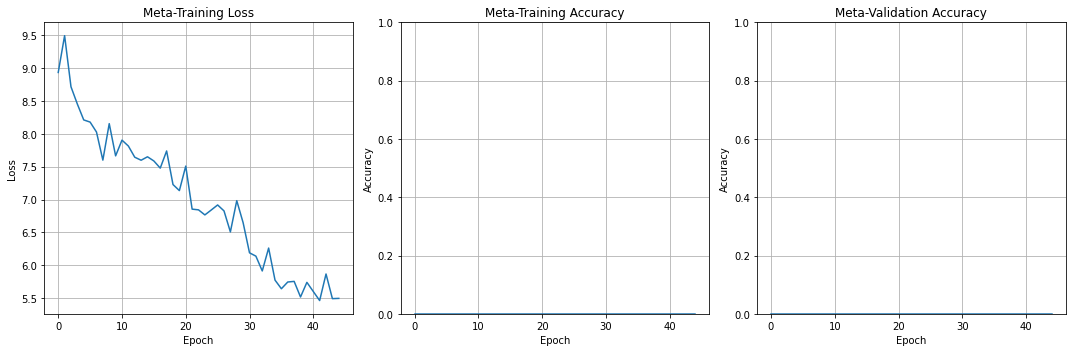

Training MAML: 100%|██████████| 320/320 [03:25<00:00,  1.56it/s, avg_loss=5.5286, loss=5.7205] 


Epoch 46/50 - Loss: 5.5286, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:57<00:00,  1.35it/s, avg_loss=5.4300, loss=5.8178] 


Epoch 47/50 - Loss: 5.4300, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [04:01<00:00,  1.33it/s, avg_loss=5.6124, loss=7.8506] 


Epoch 48/50 - Loss: 5.6124, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:57<00:00,  1.35it/s, avg_loss=5.6095, loss=6.9351] 


Epoch 49/50 - Loss: 5.6095, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:28<00:00,  1.54it/s, avg_loss=5.5394, loss=7.7597] 


Epoch 50/50 - Loss: 5.5394, Train Acc: 0.0000, Val Acc: 0.0000


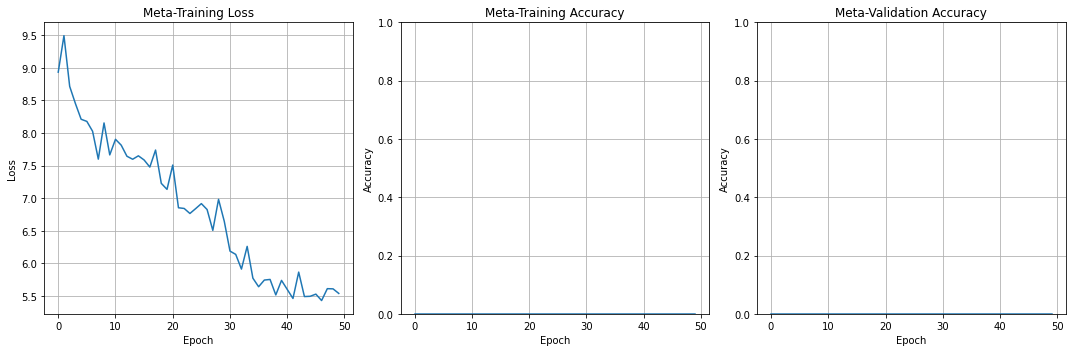

Training MAML: 100%|██████████| 320/320 [02:54<00:00,  1.84it/s, avg_loss=9.3949, loss=24.6085] 


Epoch 2/50 - Loss: 9.3949, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:02<00:00,  1.75it/s, avg_loss=8.8151, loss=23.3333] 


Epoch 3/50 - Loss: 8.8151, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:06<00:00,  1.72it/s, avg_loss=9.1616, loss=24.7333] 


Epoch 4/50 - Loss: 9.1616, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:44<00:00,  1.95it/s, avg_loss=8.9743, loss=21.6729] 


Epoch 5/50 - Loss: 8.9743, Train Acc: 0.0000, Val Acc: 0.0000


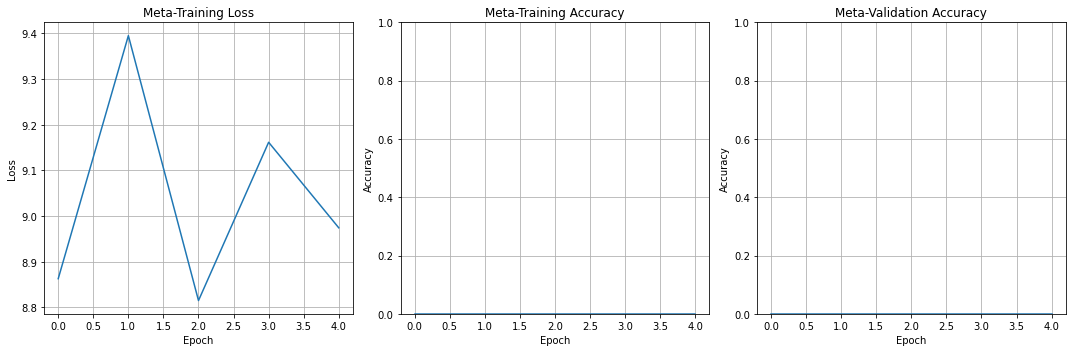

Training MAML: 100%|██████████| 320/320 [03:08<00:00,  1.70it/s, avg_loss=9.0555, loss=26.3731] 


Epoch 6/50 - Loss: 9.0555, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:54<00:00,  1.84it/s, avg_loss=8.6256, loss=24.7042] 


Epoch 7/50 - Loss: 8.6256, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:10<00:00,  1.68it/s, avg_loss=8.7665, loss=28.4703] 


Epoch 8/50 - Loss: 8.7665, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:51<00:00,  1.86it/s, avg_loss=8.3280, loss=24.0330] 


Epoch 9/50 - Loss: 8.3280, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:10<00:00,  1.68it/s, avg_loss=8.2106, loss=24.1333] 


Epoch 10/50 - Loss: 8.2106, Train Acc: 0.0000, Val Acc: 0.0000


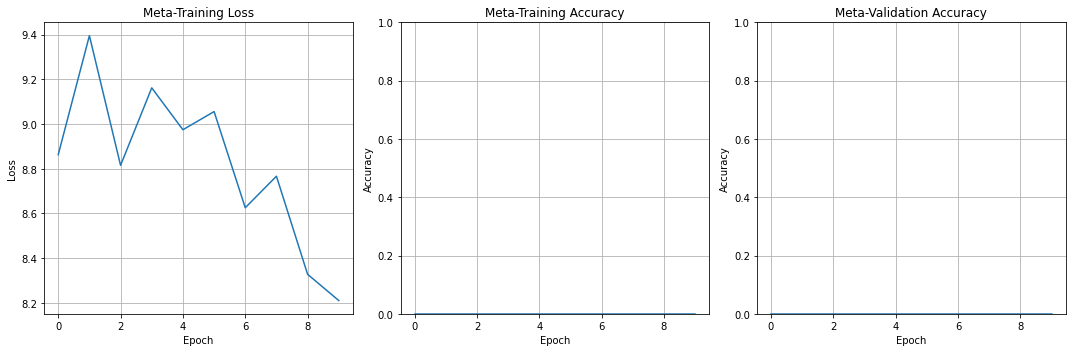

Training MAML: 100%|██████████| 320/320 [03:09<00:00,  1.69it/s, avg_loss=7.8459, loss=23.6364]


Epoch 11/50 - Loss: 7.8459, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [02:43<00:00,  1.96it/s, avg_loss=8.1577, loss=22.8455] 


Epoch 12/50 - Loss: 8.1577, Train Acc: 0.0000, Val Acc: 0.0000


Training MAML: 100%|██████████| 320/320 [03:02<00:00,  1.75it/s, avg_loss=8.1334, loss=22.1864] 


Epoch 13/50 - Loss: 8.1334, Train Acc: 0.0000, Val Acc: 0.0000


IOPub message rate exceeded.  | 188/320 [01:39<01:51,  1.19it/s, avg_loss=8.9990, loss=20.2634]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [2]:
import os
import json
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from task4 import Task, Blackboard
from unified_module import UnifiedReasoningModule
from nlm_module import NLMReasoningModule
from trainer import load_precomputed_tasks
import random
import traceback
from meta_learning import run_meta_learning, MAMLTrainer, ProtoNetTrainer
from torch_geometric.data import Batch

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
MODEL_DIR = "output/models"
TRAIN_DIR = "precomputed_tasks/training_400"
EVAL_DIR = "precomputed_tasks/evaluation_400"
METRICS_DIR = "output/metrics"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

# Create k-fold split of tasks
def create_kfold_splits(tasks, k=5):
    """Create k-fold splits of tasks"""
    random.shuffle(tasks)
    fold_size = len(tasks) // k
    folds = []
    
    for i in range(k):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size if i < k - 1 else len(tasks)
        val_tasks = tasks[start_idx:end_idx]
        train_tasks = tasks[:start_idx] + tasks[end_idx:]
        folds.append((train_tasks, val_tasks))
    
    return folds

# Initialize a new model for each fold
def initialize_model(model_type, model_path, input_dim=3, hidden_dim=128, output_dim=11):
    """Create a new model instance with fresh weights"""
    if model_type == "unified":
        model = UnifiedReasoningModule(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            device=device
        )
        model.load_complete_state(model_path)
        print("Model weights loaded successfully")
        
    elif model_type == "nlm":
        model = NLMReasoningModule(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            device=device
        )
        model.load_complete_state(model_path)
        print("Model weights loaded successfully")
    else:
        raise ValueError(f"Unknown model type: {model_type}")
        
    model.model = model.model.to(device)
    return model

# Train meta-learning models with k-fold cross-validation
def train_kfold_meta_learning(model_type, model_path, train_dir, test_dir, k=5, method="maml"):
    """
    Train meta-learning models using k-fold cross-validation.
    
    Args:
        model_type: Type of model to use ("unified" or "nlm")
        train_dir: Directory containing training tasks
        test_dir: Directory containing test tasks
        k: Number of folds
        method: Which meta-learning method to use ("maml" or "proto")
        
    Returns:
        Dictionary of trained models and fold metrics
    """
    # Create model-specific directories
    model_dir = os.path.join(MODEL_DIR, model_type)
    metrics_dir = os.path.join(METRICS_DIR, model_type)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(metrics_dir, exist_ok=True)
    
    # Log directory for this specific model-method combination
    method_log_dir = os.path.join(model_dir, method)
    os.makedirs(method_log_dir, exist_ok=True)
    
    # Load all tasks initially just to create the folds
    all_tasks = load_precomputed_tasks(train_dir)
    
    # Create k-fold splits (just the task indices, not the actual task objects)
    all_indices = list(range(len(all_tasks)))
    random.shuffle(all_indices)
    
    fold_size = len(all_indices) // k
    fold_indices = []
    
    for i in range(k):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size if i < k - 1 else len(all_indices)
        val_indices = all_indices[start_idx:end_idx]
        train_indices = [idx for idx in all_indices if idx not in val_indices]
        fold_indices.append((train_indices, val_indices))
    
    fold_results = []
    best_model = None
    best_val_accuracy = 0.0
    
    # Train on each fold
    for fold_idx, (train_indices, val_indices) in enumerate(fold_indices):
        print(f"\n--- Training {model_type.upper()} with {method.upper()} on Fold {fold_idx+1}/{k} ---")
        
        # Reload all tasks fresh for this fold
        all_tasks = load_precomputed_tasks(train_dir)
        
        # Split into train and validation based on indices
        train_tasks = [all_tasks[i] for i in train_indices]
        val_tasks = [all_tasks[i] for i in val_indices]
        
        print(f"Train tasks: {len(train_tasks)}, Validation tasks: {len(val_tasks)}")
        
        # Initialize a fresh model for this fold
        model = initialize_model(model_type, model_path)
        
        # Create a specific log directory for this fold
        fold_log_dir = os.path.join(method_log_dir, f"fold{fold_idx+1}")
        os.makedirs(fold_log_dir, exist_ok=True)

        # Before running MAML training, prepare the data properly
        if model_type == "nlm":
            # Process train and validation tasks for NLM
            for task in train_tasks:
                # This ensures the processed graphs have consistent shapes
                if hasattr(model, '_prepare_training_data'):
                    # First make sure the task data is in the right format for NLM
                    for graph in task.train_graphs + task.test_graphs:
                        # Ensure x has the right shape and type for NLM
                        if hasattr(graph, 'x'):
                            if graph.x.dim() == 2 and graph.x.size(1) == 11:
                                graph.x = graph.x.argmax(dim=1)
                            
                            # Convert to long type and reshape if needed
                            graph.x = graph.x.long()
                            if graph.x.dim() == 1:
                                graph.x = graph.x.unsqueeze(1)
                            
                            # Add position info if needed
                            if not hasattr(graph, 'pos') and graph.x.size(1) >= 3:
                                graph.pos = graph.x[:, 1:3].float()
                    
                    # Similar preprocessing for validation tasks
                    for val_task in val_tasks:
                        for graph in val_task.train_graphs + val_task.test_graphs:
                            if hasattr(graph, 'x'):
                                if graph.x.dim() == 2 and graph.x.size(1) == 11:
                                    graph.x = graph.x.argmax(dim=1)
                                graph.x = graph.x.long()
                                if graph.x.dim() == 1:
                                    graph.x = graph.x.unsqueeze(1)
                                if not hasattr(graph, 'pos') and graph.x.size(1) >= 3:
                                    graph.pos = graph.x[:, 1:3].float()
        
        # Train on this fold
        trainer = run_meta_learning(
            reasoning_module=model,
            train_tasks=train_tasks,
            val_tasks=val_tasks,
            method=method,
            epochs=50,
            lr=0.001,
            weight_decay=1e-5,
            log_dir=fold_log_dir
        )
        
        # Evaluate on validation set
        val_accuracy = evaluate_model(trainer, val_tasks, method=method)
        print(f"Fold {fold_idx+1} validation accuracy: {val_accuracy:.4f}")
        
        # Save fold results
        fold_results.append({
            "fold": fold_idx + 1,
            "model_type": model_type,
            "method": method,
            "val_accuracy": val_accuracy,
            "num_train": len(train_tasks),
            "num_val": len(val_tasks)
        })
        
        # Keep track of best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = trainer
            # Save the best model for this fold
            best_model_path = os.path.join(method_log_dir, f"fold{fold_idx+1}_best.pt")
            torch.save({
                "model_type": model_type,
                "method": method,
                "fold": fold_idx + 1,
                "accuracy": val_accuracy,
                "model_state_dict": model.model.state_dict(),
                "trainer_type": type(trainer).__name__
            }, best_model_path)
            print(f"New best model with validation accuracy: {val_accuracy:.4f}, saved to {best_model_path}")
        
        # Clean up memory
        del train_tasks
        del val_tasks
        del all_tasks
        torch.cuda.empty_cache()  # Clear CUDA cache if using GPU
    
    # Calculate average validation accuracy across folds
    avg_val_accuracy = np.mean([fold["val_accuracy"] for fold in fold_results])
    print(f"\n{model_type.upper()} with {method.upper()}: Average validation accuracy across {k} folds: {avg_val_accuracy:.4f}")
    
    # Load fresh test tasks and evaluate the best model
    test_tasks = load_precomputed_tasks(test_dir)
    print(f"Evaluating best {model_type.upper()} model with {method.upper()} on {len(test_tasks)} test tasks...")
    
    if best_model is not None:
        test_accuracy = evaluate_model(best_model, test_tasks, method=method)
        print(f"Best {model_type.upper()} model with {method.upper()} test accuracy: {test_accuracy:.4f}")
    else:
        test_accuracy = 0.0
        print(f"No best {model_type.upper()} model found")
    
    # Save k-fold metrics
    metrics_path = os.path.join(metrics_dir, f"{method}_metrics.json")
    metrics_data = {
        "model_type": model_type,
        "method": method,
        "avg_val_accuracy": avg_val_accuracy,
        "test_accuracy": test_accuracy,
        "fold_results": fold_results
    }
    
    with open(metrics_path, "w") as f:
        json.dump(metrics_data, f, indent=2)
    print(f"Metrics saved to {metrics_path}")
    
    return {
        "model_type": model_type,
        "method": method,
        "best_model": best_model,
        "avg_val_accuracy": avg_val_accuracy,
        "test_accuracy": test_accuracy,
        "fold_results": fold_results
    }

# Evaluate model on a set of tasks
def evaluate_model(trainer, tasks, method="maml"):
    """
    Evaluate a meta-learning model on a set of tasks.
    
    Args:
        trainer: Meta-learning trainer instance
        tasks: List of tasks to evaluate on
        method: Meta-learning method name
        
    Returns:
        Average accuracy across tasks
    """
    total_accuracy = 0.0
    valid_tasks = 0
    
    for task in tasks:
        try:
            # Prepare support and query sets
            support_graphs = task.train_graphs
            query_graphs = task.test_graphs
            
            if not support_graphs or not query_graphs:
                continue
                
            # Create batches
            support_batch = Batch.from_data_list(support_graphs).to(device)
            query_batch = Batch.from_data_list(query_graphs).to(device)
            
            # Evaluate with few-shot adaptation
            accuracy = trainer.validate_task(support_batch, query_batch, task)
            total_accuracy += accuracy
            valid_tasks += 1
            
        except Exception as e:
            print(f"Error evaluating task {task.task_id}: {e}")
    
    return total_accuracy / valid_tasks if valid_tasks > 0 else 0.0

# Plot k-fold results
def plot_kfold_results(fold_results, model_type, method, save_path=None):
    """Plot k-fold validation results"""
    plt.figure(figsize=(10, 6))
    
    # Extract data
    fold_indices = [fold["fold"] for fold in fold_results]
    val_accuracies = [fold["val_accuracy"] for fold in fold_results]
    
    # Plot validation accuracies
    plt.bar(fold_indices, val_accuracies, alpha=0.7)
    
    # Add average line
    avg_acc = np.mean(val_accuracies)
    plt.axhline(y=avg_acc, color='r', linestyle='--', label=f'Average: {avg_acc:.4f}')
    
    # Labels and title
    plt.xlabel('Fold')
    plt.ylabel('Validation Accuracy')
    plt.title(f'{model_type.upper()} with {method.upper()} K-Fold Cross-Validation Results')
    plt.xticks(fold_indices)
    plt.ylim([0, 1.0])
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    
    plt.show()

# Compare results across different models and methods
def compare_results(results, save_path=None):
    """
    Compare results across different models and methods.
    
    Args:
        results: Dictionary mapping (model_type, method) to result dicts
        save_path: Path to save the comparison plot
    """
    plt.figure(figsize=(12, 8))
    
    # Extract data
    models = []
    val_accs = []
    test_accs = []
    
    for key, result in results.items():
        model_type, method = key
        models.append(f"{model_type}-{method}")
        val_accs.append(result["avg_val_accuracy"])
        test_accs.append(result["test_accuracy"])
    
    # Set positions for bars
    x = np.arange(len(models))
    width = 0.35
    
    # Create grouped bars
    plt.bar(x - width/2, val_accs, width, label='Validation Accuracy', color='skyblue')
    plt.bar(x + width/2, test_accs, width, label='Test Accuracy', color='lightcoral')
    
    # Add details
    plt.xlabel('Model-Method')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Models and Meta-Learning Methods')
    plt.xticks(x, models, rotation=45, ha='right')
    plt.ylim([0, 1.0])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Comparison plot saved to {save_path}")
    
    plt.show()

# Main function
def main():
    try:
        print("Starting k-fold cross-validation...")
        all_results = {}
        
        # Run k-fold training for NLM with MAML
        nlm_maml_results = train_kfold_meta_learning(
            model_type="nlm",
            model_path="output/models/nlm/nlm_reasoning_module_final.pt",
            train_dir=TRAIN_DIR,
            test_dir=EVAL_DIR,
            k=5,
            method="maml"
        )
        all_results[("nlm", "maml")] = nlm_maml_results
        
        # Plot NLM-MAML k-fold results
        plot_kfold_results(
            nlm_maml_results["fold_results"], 
            "nlm",
            "maml",
            save_path=os.path.join(METRICS_DIR, "nlm", "maml_results.png")
        )
        
        # # Run k-fold training for NLM with Prototypical Networks
        # nlm_proto_results = train_kfold_meta_learning(
        #     model_type="nlm",
        #     train_dir=TRAIN_DIR,
        #     test_dir=EVAL_DIR,
        #     k=5,
        #     method="proto"
        # )
        # all_results[("nlm", "proto")] = nlm_proto_results
        
        # # Plot NLM-Proto k-fold results
        # plot_kfold_results(
        #     nlm_proto_results["fold_results"], 
        #     "nlm",
        #     "proto",
        #     save_path=os.path.join(METRICS_DIR, "nlm_proto_kfold_results.png")
        # )
        
        # Run k-fold training for Unified with MAML
        unified_maml_results = train_kfold_meta_learning(
            model_type="unified",
            model_path="output/models/unified/unified_reasoning_model_final.pt",
            train_dir=TRAIN_DIR,
            test_dir=EVAL_DIR,
            k=5,
            method="maml"
        )
        all_results[("unified", "maml")] = unified_maml_results
        
        # Plot Unified-MAML k-fold results
        plot_kfold_results(
            unified_maml_results["fold_results"], 
            "unified",
            "maml",
            save_path=os.path.join(METRICS_DIR, "unified", "maml_results.png")
        )
        
        # # Run k-fold training for Unified with Prototypical Networks
        # unified_proto_results = train_kfold_meta_learning(
        #     model_type="unified",
        #     train_dir=TRAIN_DIR,
        #     test_dir=EVAL_DIR,
        #     k=5,
        #     method="proto"
        # )
        # all_results[("unified", "proto")] = unified_proto_results
        
        # # Plot Unified-Proto k-fold results
        # plot_kfold_results(
        #     unified_proto_results["fold_results"], 
        #     "unified",
        #     "proto",
        #     save_path=os.path.join(METRICS_DIR, "unified_proto_kfold_results.png")
        # )
        
        # Compare all results
        compare_results(all_results, save_path=os.path.join(METRICS_DIR, "all_models_comparison.png"))
        
        # Print summary of results
        print("\n----- RESULTS SUMMARY -----")
        for (model_type, method), results in all_results.items():
            print(f"{model_type.upper()} with {method.upper()}: Val Acc = {results['avg_val_accuracy']:.4f}, Test Acc = {results['test_accuracy']:.4f}")
        
        print("\nK-fold meta-learning training and evaluation complete!")
        return all_results
        
    except Exception as e:
        print(f"Error in main function: {e}")
        traceback.print_exc()
        return None

# Run the main function when executed
if __name__ == "__main__":
    results = main()